In [1]:
import sys
import scipy
import agama
import seaborn as sns

In [2]:
import configparser
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import galpy.util.coords as guc
from astropy.table import Table
from laspec.mpl import set_cham
#set_cham(latex=True)
import gala.coordinates as gc
from astropy.coordinates import SkyCoord
import astropy.units as units
import astropy.units as u
import astropy.coordinates as coord
from astropy.io import fits

In [3]:
stream_name = "Zhujiang"
mass_nfw = 5.5

In [4]:
config_file = f"./stream/S2808stream/config_{stream_name}_mem.ini"
config = configparser.ConfigParser()
config.read(config_file)
Config_Section = config.sections()
print(config_file)

./stream/S2808stream/config_Zhujiang_mem.ini


In [5]:
X_Sun = config["MilkyWayConstant"].getfloat("X_Sun")
U_Sun = config["MilkyWayConstant"].getfloat("U_Sun")
V_Sun = config["MilkyWayConstant"].getfloat("V_Sun")
W_Sun = config["MilkyWayConstant"].getfloat("W_Sun")
V_LSR = config["MilkyWayConstant"].getfloat("V_LSR")

### read the extinction parameters
A_G = config["extinction"].getfloat("lambda_G")
A_BP = config["extinction"].getfloat("lambda_bp")
A_RP = config["extinction"].getfloat("lambda_rp")
print(A_G, A_BP, A_RP)

2.489 3.161 1.858


In [6]:
pm_err = config["pm_range"].getfloat("pm_err")
min_pmra = config["pm_range"].getfloat("min_pmra")
max_pmra = config["pm_range"].getfloat("max_pmra")
min_pmdec = config["pm_range"].getfloat("min_pmdec")
max_pmdec = config["pm_range"].getfloat("max_pmdec")

min_phi = config["phi_range"].getfloat("min_phi1")
max_phi = config["phi_range"].getfloat("max_phi1")
min_phi = config["phi_range"].getfloat("min_phi1")
max_phi = config["phi_range"].getfloat("max_phi1")

print(pm_err)

0.2


In [7]:
min_phi1, max_phi1 = config["phi_range"].getfloat("min_phi1"), config["phi_range"].getfloat("max_phi1")
min_phi2, max_phi2 = config["phi_range"].getfloat("min_phi2"), config["phi_range"].getfloat("max_phi2")

min_hist_phi1, max_hist_phi1, n_hist_phi1 = config["phi_range"].getfloat("min_hist_phi1"), config["phi_range"].getfloat("max_hist_phi1"), config["phi_range"].getint("n_hist_phi1")
min_hist_phi2, max_hist_phi2, n_hist_phi2 = config["phi_range"].getfloat("min_hist_phi2"), config["phi_range"].getfloat("max_hist_phi2"), config["phi_range"].getint("n_hist_phi2")

In [8]:
RA_shift = config["Coord_Conversion"].getboolean("RA_shift")
Check_by_RRL = config["RRL_DistanceValidation"].getboolean("Check_by_RRL")
Check_by_BHB = config["BHB_DistanceValidation"].getboolean("Check_by_BHB")
Check_by_GC = config["GC_DistanceValidation"].getboolean("Check_by_GlobularCluster")
Check_by_iso = config["isochrone"].getboolean("Check_by_isochrone")

print(f"RA_shift is set {RA_shift}")
if Check_by_RRL:
    dist_tracer = "RRL"
    abs_Gmag_RRL = config["RRL_DistanceValidation"].getfloat("abs_Gmag_RRL")
elif Check_by_GC:
    dist_tracer = "GC"
    DM_GC = config["GC_DistanceValidation"].getfloat("DM_GC") # distance module of the chosen globular cluster
    fn_GC = config["GC_DistanceValidation"]["fn_GC"]
    DM_Stream = config["GC_DistanceValidation"].getfloat("DM_Stream")
else:
    dist_tracer = "BHB"
    DM_Stream = config["BHB_DistanceValidation"].getfloat("DM_Stream")
    min_bprp_BHB = config["BHB_DistanceValidation"].getfloat("min_bprp")
    max_bprp_BHB = config["BHB_DistanceValidation"].getfloat("max_bprp")
    min_Gmag_BHB = config["BHB_DistanceValidation"].getfloat("min_Gmag")
    max_Gmag_BHB = config["BHB_DistanceValidation"].getfloat("max_Gmag")
    print(f"Check the CMD with {dist_tracer}")
print("-----------------------------------------------------------------------")

RA_shift is set None
Check the CMD with BHB
-----------------------------------------------------------------------


In [9]:
# Check_by_iso
##  isochrone should be shifted by Gabs+0.2 dex


if Check_by_GC:
    dt_gc = fits.open(fn_GC)
    data_gc = dt_gc[1].data
    ra_gc = data_gc["ra"]
    dec_gc = data_gc["dec"]
    llbb_gc = guc.radec_to_lb(ra_gc,dec_gc,degree=True)
    ll_gc = llbb_gc[:,0]
    bb_gc = llbb_gc[:,1]
    coords_gc = SkyCoord(ll_gc*units.deg, bb_gc*units.deg, distance=(np.zeros_like(bb_gc)+10**(DM_GC/5.0)/100)*units.kpc, frame="galactic")
    ebv_gc = 0.31 #planck(coords_gc)
    BPRP_gc = data_gc["phot_bp_mean_mag"]-data_gc["phot_rp_mean_mag"]-ebv_gc*(A_BP-A_RP)
    Gmag_gc = data_gc["phot_g_mean_mag"]- DM_GC - A_G*ebv_gc  # EBV from Vasiliev et al GC list
    plt.plot(BPRP_gc,Gmag_gc,'k.')
    plt.ylim([2,-7])
    print(DM_GC)
if Check_by_iso:
    age = config["isochrone"].getfloat("age")
    MH = config["isochrone"].getfloat("MH")
    print(f"MH:{MH:.2f}---age:{age:.3f}")
    fn_iso = "./stream/S2808stream/iso_lib.dat"
    data_iso = np.loadtxt(fn_iso,skiprows=1)
    T_MH = MH
    T_logT = age
    DM_iso = config["isochrone"].getfloat("DM_iso")
    ind_iso = (np.abs(data_iso[:,1]-T_MH)<0.06) & (np.abs(data_iso[:,2]-T_logT)<0.06)
    RPmag_iso = data_iso[:,-1][ind_iso]
    BPmag_iso = data_iso[:,-2][ind_iso]
    BPRP_iso = BPmag_iso-RPmag_iso
    Gmag_iso = data_iso[:,-3][ind_iso]

MH:-2.00---age:10.114


In [10]:
# read the points for conversion

ra1 = config["Coord_Conversion"].getfloat("ra1")
dec1 = config["Coord_Conversion"].getfloat("dec1")

ra2 = config["Coord_Conversion"].getfloat("ra2")
dec2 = config["Coord_Conversion"].getfloat("dec2")

print(f"ra1={ra1},dec1={dec1}")
print(f"ra2={ra2},dec2={dec2}")

ra1=-0.5,dec1=9.0
ra2=30.0,dec2=-46.2


In [11]:
fn_all = f"./stream/sgr member/FullSkyD10_htian_astro_pme0.2.fits"
fn_RRL = f"./stream/sgr member/RRL_GDR3_topcat.fits"
plot_path = f"./plot/"

In [12]:
# from dustmaps.bayestar import BayestarQuery
from dustmaps.sfd import SFDQuery
# bayestar = BayestarQuery(version='bayestar2019')
from dustmaps.planck import PlanckQuery
from dustmaps.config import config
import dustmaps
config['data_dir'] = './stream/DustMaps'
# dustmaps.planck.fetch()
planck = PlanckQuery()
sfd = SFDQuery()

In [13]:
dt = fits.open(fn_all)
data = dt[1].data
if RA_shift:
    ra = (data["ra"]+180)%360-180
else:
    ra = data["ra"]
SID = data["source_id"]
dec = data["dec"]
pmra = data["pmra"]
pmdec = data["pmdec"]
pmraerr = data["pmra_error"]
pmdecerr = data["pmdec_error"]
Gmag = data["phot_g_mean_mag"]
BPmag = data["phot_bp_mean_mag"]
RPmag = data["phot_rp_mean_mag"]
bb = data["b"]
ll = data["l"]

coords_G = SkyCoord(ll*units.deg, bb*units.deg, distance=(
    np.zeros_like(ra)+10)*units.kpc, frame="galactic")
ebv = planck(coords_G)
ebv[ebv!=ebv] = 0


In [14]:
# 已经检查过交叉的星都在范围内

fn_LAMOST = "./stream/S2808stream/mem_Zhujiang_xLAMOST.fits"

dt_L = fits.open(fn_LAMOST)
data_L = dt_L[1].data
SID_L = data_L["SID"]
ra_L = data_L["ra_1"]
dec_L = data_L["dec_1"]
pmra_L = data_L["pmra_1"]
pmdec_L = data_L["pmdec_1"]
pmraerr_L = data_L["pmraerr"]
pmdecerr_L = data_L["pmdecerr"]
Gmag_L = data_L["Gmag"]
BPmag_L = data_L["BPmag"]
RPmag_L = data_L["RPmag"]
bb_L = data_L["bb"]
ll_L = data_L["ll"]
phi1_L = data_L["phi1"]
phi2_L = data_L["phi2"]
RV_L = data_L["z"]*299792.458
RV_e_L = data_L["z_err"]*299792.458
MH_L = data_L["M_H"]
MH_e_L = data_L["M_H_err"]
coords_L = SkyCoord(ll_L*units.deg, bb_L*units.deg, distance=(np.zeros_like(ra_L)+10)*units.kpc, frame="galactic")
ebv_L = planck(coords_L)
ebv_L[ebv_L!=ebv_L] = 0

fn_DESI = "./stream/S2808stream/mem_Zhujiang_xDESI.fits"
dt_D = fits.open(fn_DESI)
data_D = dt_D[1].data
SID_D = data_D["SID"]
ra_D = data_D["ra"]
dec_D = data_D["dec"]
pmra_D = data_D["pmra"]
pmdec_D = data_D["pmdec"]
pmraerr_D = data_D["pmraerr"]
pmdecerr_D = data_D["pmdecerr"]
Gmag_D = data_D["Gmag"]
BPmag_D = data_D["BPmag"]
RPmag_D = data_D["RPmag"]
bb_D = data_D["bb"]
ll_D = data_D["ll"]
phi1_D = data_D["phi1"]
phi2_D = data_D["phi2"]
RV_D = data_D["VRAD"]
RV_e_D = data_D["VRAD_ERR"]
MH_D = data_D["FEH"]
coords_D = SkyCoord(ll_D*units.deg, bb_D*units.deg, distance=(np.zeros_like(ra_D)+10)*units.kpc, frame="galactic")
ebv_D = planck(coords_D)
ebv_D[ebv_D!=ebv_D] = 0


fn_S5 = "./stream/S2808stream/mem_Zhujiang_S5.fits"
dt_S = fits.open(fn_S5)
data_S = dt_S[1].data
SID_S = data_S["SID"]
ra_S = data_S["ra_1"]
dec_S = data_S["dec_1"]
pmra_S = data_S["pmra_1"]
pmdec_S = data_S["pmdec_1"]
pmraerr_S = data_S["pmraerr"]
pmdecerr_S = data_S["pmdecerr"]
Gmag_S = data_S["Gmag"]
BPmag_S = data_S["BPmag"]
RPmag_S = data_S["RPmag"]
bb_S = data_S["bb"]
ll_S = data_S["ll"]
phi1_S = data_S["phi1"]
phi2_S = data_S["phi2"]
RV_S = data_S["vel50"]
RV_e_S = data_S["vel_std"]
MH_S = data_S["feh50"]
MH_e_S = data_S["feh_std"]
coords_S = SkyCoord(ll_S*units.deg, bb_S*units.deg, distance=(np.zeros_like(ra_S)+10)*units.kpc, frame="galactic")
ebv_S = planck(coords_S)
ebv_S[ebv_S!=ebv_S] = 0

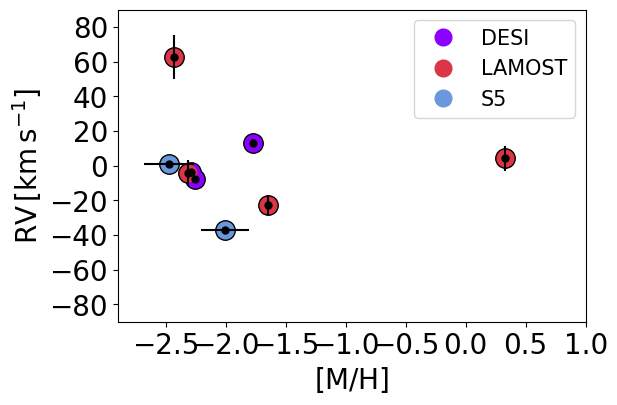

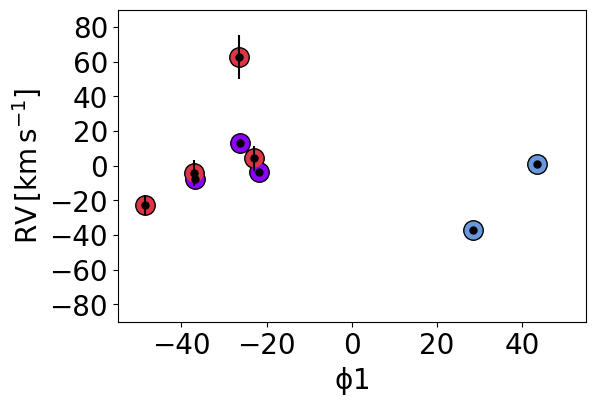

In [15]:
ind_mem_L = (MH_L>-2.5) & (MH_L<1) & (RV_L>-100) & (RV_L<100)
ind_mem_D = (MH_D>-2.5) & (MH_D<1) & (RV_D>-100) & (RV_D<100)
ind_mem_S = (MH_S>-2.5) & (MH_S<1) & (RV_S>-100) & (RV_S<100)
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.18,0.18,0.78,0.78])
plt.plot(MH_D,RV_D,'ko',ms=14)
plt.plot(MH_L,RV_L,'ko',ms=14)
plt.plot(MH_S,RV_S,'ko',ms=14)
plt.plot(MH_D,RV_D,'o',ms=12,color="#8B00FF",label="DESI")
plt.plot(MH_L,RV_L,'o',ms=12,color="#DC3545",label="LAMOST")
plt.plot(MH_S,RV_S,'o',ms=12,color="#6B98DC",label="S5")
plt.errorbar(MH_D,RV_D,yerr=RV_e_D,fmt=".",color="k",ms=10)
plt.errorbar(MH_L,RV_L,xerr=MH_e_L,yerr=RV_e_L,fmt=".",color="k",ms=10)
plt.errorbar(MH_S,RV_S,xerr=MH_e_S,yerr=RV_e_S,fmt=".",color="k",ms=10)
# plt.plot([-2.5,1,1,-2.5,-2.5],[-100,-100,100,100,-100],'k--')
plt.legend(fontsize=15)
plt.axis([-2.9,1,-90,90])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r"$\mathrm{[M/H]}$",fontsize=20)
plt.ylabel(r"$\mathrm{RV}\,[\mathrm{km\,s^{-1}}]$",fontsize=20)
plt.show()


fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.18,0.18,0.78,0.78])
plt.plot(phi1_D,RV_D,'ko',ms=14)
plt.plot(phi1_L,RV_L,'ko',ms=14)
plt.plot(phi1_S,RV_S,'ko',ms=14)
plt.plot(phi1_D,RV_D,'o',ms=12,color="#8B00FF",label="DESI")
plt.plot(phi1_L,RV_L,'o',ms=12,color="#DC3545",label="LAMOST")
plt.plot(phi1_S,RV_S,'o',ms=12,color="#6B98DC",label="S5")
plt.errorbar(phi1_D,RV_D,yerr=RV_e_D,fmt=".",color="k",ms=10)
plt.errorbar(phi1_L,RV_L,yerr=RV_e_L,fmt=".",color="k",ms=10)
plt.errorbar(phi1_S,RV_S,yerr=RV_e_S,fmt=".",color="k",ms=10)
# plt.plot([-2.5,1,1,-2.5,-2.5],[-100,-100,100,100,-100],'k--')
# plt.legend(fontsize=15)
plt.axis([-55,55,-90,90])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r"$\mathrm{\phi1}$",fontsize=20)
plt.ylabel(r"$\mathrm{RV}\,[\mathrm{km\,s^{-1}}]$",fontsize=20)
plt.show()

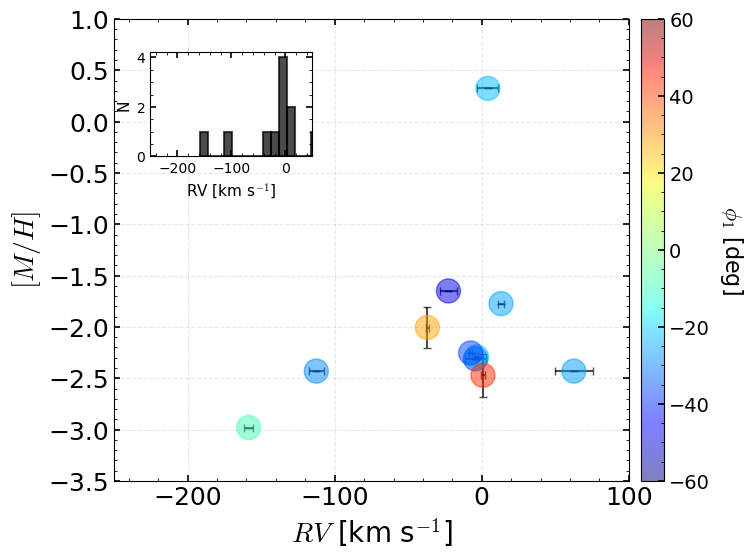

In [540]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 合并所有数据
MH_all = np.concatenate([MH_L, MH_D, MH_S])
RV_all = np.concatenate([RV_L, RV_D, RV_S])
MH_e_all = np.concatenate([MH_e_L, np.zeros(len(MH_D)), MH_e_S])
RV_e_all = np.concatenate([RV_e_L, RV_e_D, RV_e_S])
phi1_all = np.concatenate([phi1_L, phi1_D, phi1_S])

# ============ 图1: [M/H] vs RV ============
fig, ax = plt.subplots(figsize=(8, 6))

# 使用 phi1 作为颜色映射
scatter = ax.scatter(RV_all, MH_all, 
                     c=phi1_all, 
                     s=300,  # 点的大小
                     cmap='jet',  # 颜色映射
                     alpha=0.5,
                     vmin=-60, vmax=60,
                     zorder=3)

# 添加误差棒
ax.errorbar(RV_all, MH_all, 
            xerr=RV_e_all, 
            yerr=MH_e_all,
            fmt='none', 
            ecolor='black', 
            elinewidth=1.5,
            capsize=3,
            alpha=0.7,
            zorder=2)

# 添加垂直虚线
#ax.axvline(-100, color='black', linestyle='--', linewidth=2, zorder=1)

# 添加颜色条
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label(r'$\phi_1$ [deg]', fontsize=16, rotation=270, labelpad=25)
cbar.ax.tick_params(labelsize=14)

# 创建插图显示 RV 分布
ax_inset = inset_axes(ax, width="35%", height="25%", loc='upper left',
                      bbox_to_anchor=(0.05, 0.05, 0.9, 0.9),
                      bbox_transform=ax.transAxes)

# 绘制 RV 直方图
counts, bins, patches = ax_inset.hist(RV_all, bins=15, 
                                       color='black', 
                                       alpha=0.7,
                                       edgecolor='black',
                                       linewidth=1.5)

# 在插图中也添加垂直虚线
# ax_inset.axvline(-100, color='black', linestyle='--', linewidth=2)

# 插图样式设置
ax_inset.set_xlabel('RV [km s$^{-1}$]', fontsize=11)
ax_inset.set_ylabel('N', fontsize=11)
ax_inset.tick_params(labelsize=10)
ax_inset.set_xlim(-250, 50)

# 主图设置
ax.set_xlabel(r'$RV$ [km s$^{-1}$]', fontsize=20)
ax.set_ylabel(r'$[M/H]$', fontsize=20)
ax.tick_params(labelsize=18)
ax.set_xlim(-250, 100)
ax.set_ylim(-3.5, 1.0)
ax.grid(alpha=0.3, linestyle='--', linewidth=0.8)

plt.show()

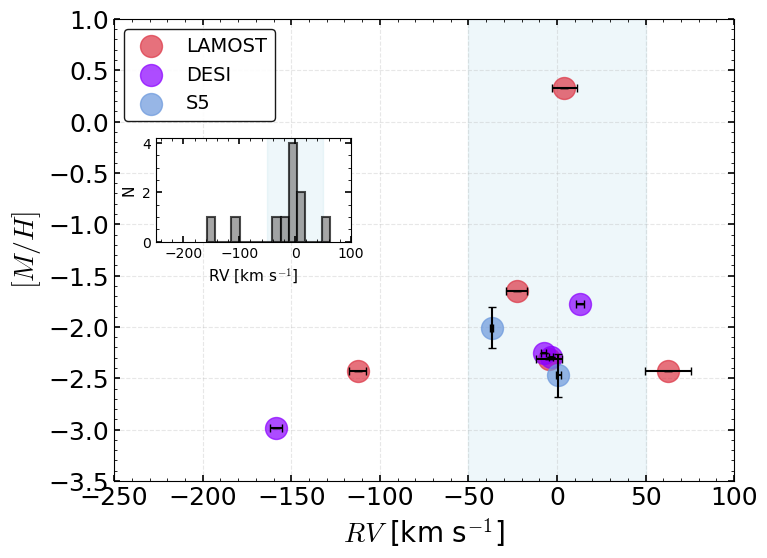

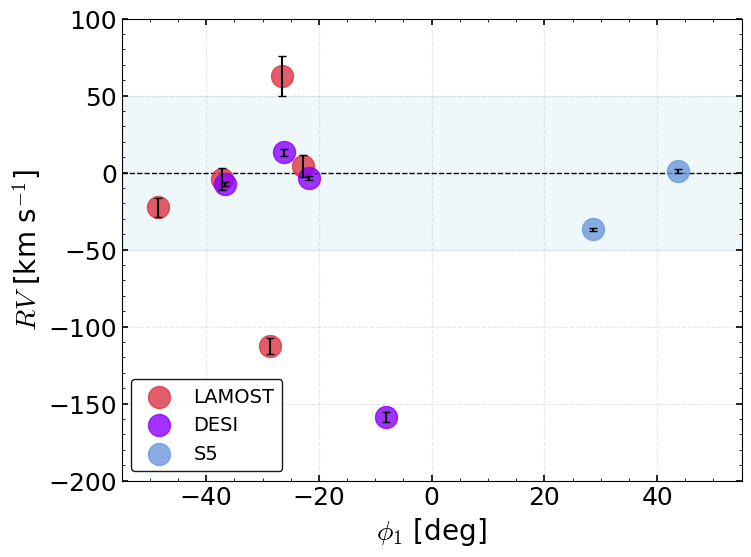

In [541]:
# ============ 图1: [M/H] vs RV ============
fig, ax = plt.subplots(figsize=(8, 6))

# 添加误差棒
ax.errorbar(RV_L, MH_L, xerr=RV_e_L, yerr=MH_e_L,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, alpha=1, zorder=4)
ax.errorbar(RV_D, MH_D, xerr=RV_e_D, yerr=np.zeros(len(MH_D)),
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, alpha=1, zorder=4)
ax.errorbar(RV_S, MH_S, xerr=RV_e_S, yerr=MH_e_S,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, alpha=1, zorder=4)

# 分别绘制不同survey的数据
ax.scatter(RV_L, MH_L, s=250, color='#DC3545', label='LAMOST', alpha=0.7, zorder=3)
ax.scatter(RV_D, MH_D, s=250, color='#8B00FF', label='DESI', alpha=0.7, zorder=3)
ax.scatter(RV_S, MH_S, s=250, color='#6B98DC', label='S5', alpha=0.7, zorder=3)

# 添加RV阴影区域（-50到50）- 垂直阴影
ax.axvspan(-50, 50, alpha=0.2, color='lightblue')

# 创建插图显示 RV 分布
ax_inset = inset_axes(ax, width="35%", height="25%", loc='center left',
                      bbox_to_anchor=(0.05, 0.18, 0.9, 0.9),
                      bbox_transform=ax.transAxes)

ax_inset.axvspan(-50, 50, alpha=0.2, color='lightblue')

# 绘制 RV 直方图
counts, bins, patches = ax_inset.hist(RV_all, bins=15, 
                                       color='gray', 
                                       alpha=0.7,
                                       edgecolor='black',
                                       linewidth=1.5)

# 插图样式设置
ax_inset.set_xlabel('RV [km s$^{-1}$]', fontsize=11)
ax_inset.set_ylabel('N', fontsize=11)
ax_inset.tick_params(labelsize=10)
ax_inset.set_xlim(-250, 100)

# 主图设置
ax.set_xlabel(r'$RV$ [km s$^{-1}$]', fontsize=20)
ax.set_ylabel(r'$[M/H]$', fontsize=20)
ax.tick_params(labelsize=18)
ax.set_xlim(-250, 100)
ax.set_ylim(-3.5, 1.0)
ax.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax.legend(fontsize=14,  framealpha=0.9, edgecolor='black')
plt.show()

# ============ 图2: phi1 vs RV ============
fig, ax = plt.subplots(figsize=(8, 6))

# 分别绘制不同survey的数据
ax.scatter(phi1_L, RV_L, s=250, color='#DC3545', label='LAMOST', alpha=0.8, zorder=3)
ax.scatter(phi1_D, RV_D, s=250, color='#8B00FF', label='DESI', alpha=0.8, zorder=3)
ax.scatter(phi1_S, RV_S, s=250, color='#6B98DC', label='S5', alpha=0.8, zorder=3)

# 添加误差棒
ax.errorbar(phi1_L, RV_L, yerr=RV_e_L,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=4)
ax.errorbar(phi1_D, RV_D, yerr=RV_e_D,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=4)
ax.errorbar(phi1_S, RV_S, yerr=RV_e_S,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=4)

ax.axhspan(-50, 50, alpha=0.2, color='lightblue')

# 插图样式设置
ax_inset.set_xlabel(r'$\phi_1$ [deg]', fontsize=11)
ax_inset.set_ylabel('N', fontsize=11)
ax_inset.tick_params(labelsize=10)
ax_inset.set_xlim(-55, 55)

# 主图设置
ax.set_xlabel(r'$\phi_1$ [deg]', fontsize=20)
ax.set_ylabel(r'$$]', fontsize=20)
ax.set_ylabel(r'$$]', fontsize=20)
ax.tick_params(labelsize=18)
ax.set_xlim(-55, 55)
ax.set_ylim(-200, 100)
ax.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.legend(fontsize=14, framealpha=0.9, edgecolor='black')
#plt.savefig("./stream/S2808stream/plot/feh_RV.png", bbox_inches='tight',dpi = 200)
plt.show()

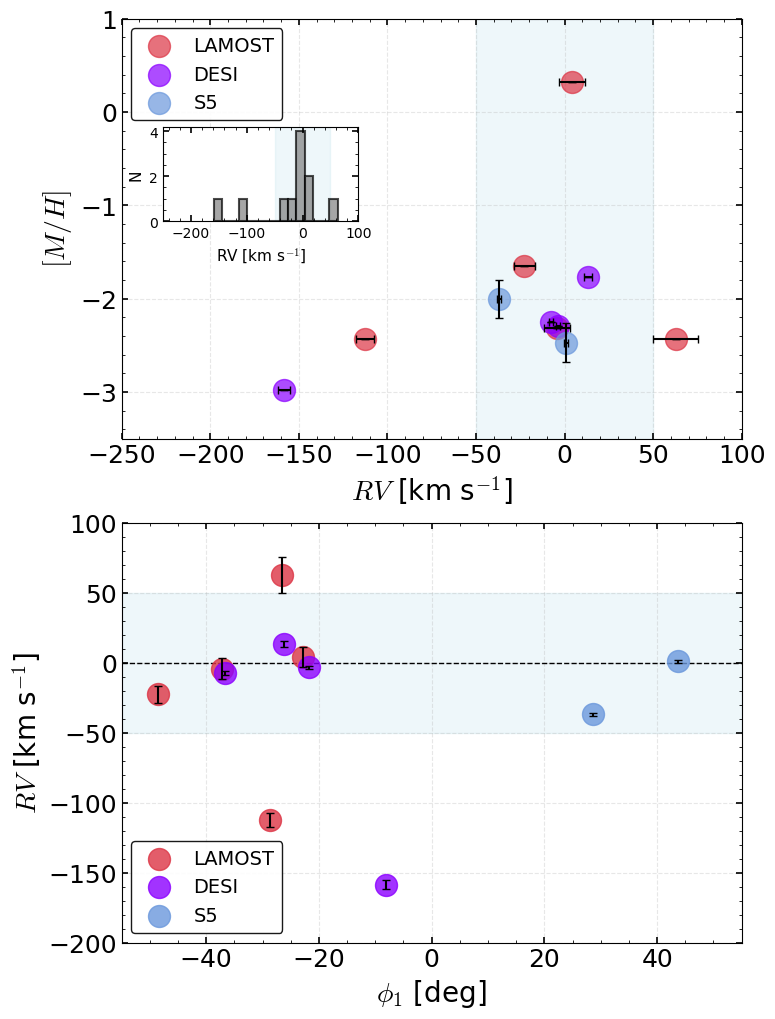

In [542]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ============ 创建包含两个子图的figure（上下排列）============
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# ============ 上图: [M/H] vs RV ============
# 添加误差棒
ax1.errorbar(RV_L, MH_L, xerr=RV_e_L, yerr=MH_e_L,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, alpha=1, zorder=4)
ax1.errorbar(RV_D, MH_D, xerr=RV_e_D, yerr=np.zeros(len(MH_D)),
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, alpha=1, zorder=4)
ax1.errorbar(RV_S, MH_S, xerr=RV_e_S, yerr=MH_e_S,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, alpha=1, zorder=4)

# 分别绘制不同survey的数据
ax1.scatter(RV_L, MH_L, s=250, color='#DC3545', label='LAMOST', alpha=0.7, zorder=3)
ax1.scatter(RV_D, MH_D, s=250, color='#8B00FF', label='DESI', alpha=0.7, zorder=3)
ax1.scatter(RV_S, MH_S, s=250, color='#6B98DC', label='S5', alpha=0.7, zorder=3)

# 添加RV阴影区域（-50到50）- 垂直阴影
ax1.axvspan(-50, 50, alpha=0.2, color='lightblue')

# 创建插图显示 RV 分布
ax_inset = inset_axes(ax1, width="35%", height="25%", loc='center left',
                      bbox_to_anchor=(0.05, 0.18, 0.9, 0.9),
                      bbox_transform=ax1.transAxes)

ax_inset.axvspan(-50, 50, alpha=0.2, color='lightblue')

# 绘制 RV 直方图
counts, bins, patches = ax_inset.hist(RV_all, bins=15, 
                                       color='gray', 
                                       alpha=0.7,
                                       edgecolor='black',
                                       linewidth=1.5)

# 插图样式设置
ax_inset.set_xlabel('RV [km s$^{-1}$]', fontsize=11)
ax_inset.set_ylabel('N', fontsize=11)
ax_inset.tick_params(labelsize=10)
ax_inset.set_xlim(-250, 100)

# 上图主图设置
ax1.set_xlabel(r'$RV$ [km s$^{-1}$]', fontsize=20)
ax1.set_ylabel(r'$[M/H]$', fontsize=20)
ax1.tick_params(labelsize=18)
ax1.set_xlim(-250, 100)
ax1.set_ylim(-3.5, 1.0)
ax1.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax1.legend(fontsize=14, framealpha=0.9, edgecolor='black')

# ============ 下图: phi1 vs RV ============
# 分别绘制不同survey的数据
ax2.scatter(phi1_L, RV_L, s=250, color='#DC3545', label='LAMOST', alpha=0.8, zorder=3)
ax2.scatter(phi1_D, RV_D, s=250, color='#8B00FF', label='DESI', alpha=0.8, zorder=3)
ax2.scatter(phi1_S, RV_S, s=250, color='#6B98DC', label='S5', alpha=0.8, zorder=3)

# 添加误差棒
ax2.errorbar(phi1_L, RV_L, yerr=RV_e_L,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=4)
ax2.errorbar(phi1_D, RV_D, yerr=RV_e_D,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=4)
ax2.errorbar(phi1_S, RV_S, yerr=RV_e_S,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=4)

ax2.axhspan(-50, 50, alpha=0.2, color='lightblue')

# 下图主图设置
ax2.set_xlabel(r'$\phi_1$ [deg]', fontsize=20)
ax2.set_ylabel(r'$RV$ [km s$^{-1}$]', fontsize=20)
ax2.tick_params(labelsize=18)
ax2.set_xlim(-55, 55)
ax2.set_ylim(-200, 100)
ax2.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.legend(fontsize=14, framealpha=0.9, edgecolor='black')

# 调整子图间距
plt.subplots_adjust(wspace=0.15)
#plt.savefig("./stream/S2808stream/plot/feh_RV.png", bbox_inches='tight',dpi = 200)
plt.show()

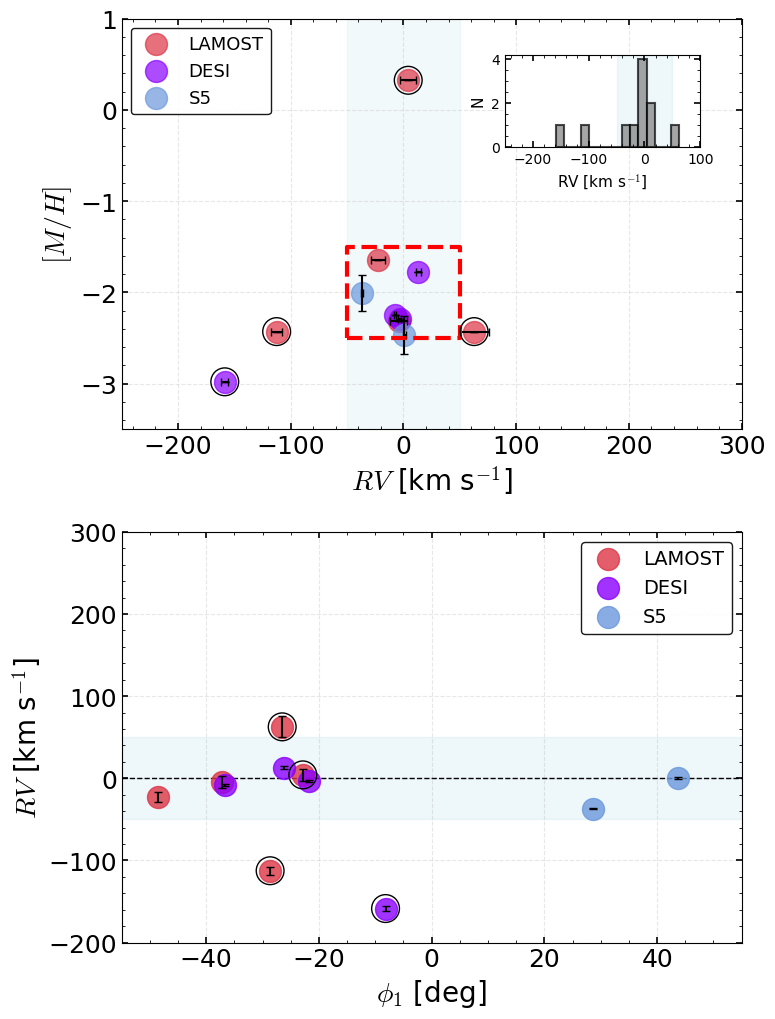

In [553]:
# 成员星
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 合并所有RV和MH数据
RV_all = np.concatenate([RV_L, RV_D, RV_S])
MH_all = np.concatenate([MH_L, MH_D, MH_S])
phi1_all_spec = np.concatenate([phi1_L, phi1_D, phi1_S])

# ============ 创建包含两个子图的figure（上下排列）============
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# ============ 上图: [M/H] vs RV ============
# 添加误差棒
ax1.errorbar(RV_L, MH_L, xerr=RV_e_L, yerr=MH_e_L,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, alpha=1, zorder=4)
ax1.errorbar(RV_D, MH_D, xerr=RV_e_D, yerr=np.zeros(len(MH_D)),
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, alpha=1, zorder=4)
ax1.errorbar(RV_S, MH_S, xerr=RV_e_S, yerr=MH_e_S,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, alpha=1, zorder=4)

# 分别绘制不同survey的数据
ax1.scatter(RV_L, MH_L, s=250, color='#DC3545', label='LAMOST', alpha=0.7, zorder=3)
ax1.scatter(RV_D, MH_D, s=250, color='#8B00FF', label='DESI', alpha=0.7, zorder=3)
ax1.scatter(RV_S, MH_S, s=250, color='#6B98DC', label='S5', alpha=0.7, zorder=3)

# ========== 添加红色选择框 ==========
# 定义选择框范围
rv_min, rv_max = -50, 50
mh_min, mh_max = -2.5,-1.5

# 方式2（可选）: 用plot画框边界
ax1.plot([rv_min, rv_max, rv_max, rv_min, rv_min],
          [mh_min, mh_min, mh_max, mh_max, mh_min],
          'r--', lw=3, zorder=5)

# ========== 找出并标记框外的星 ==========
# 判断哪些星在框外
mask_out_L = (RV_L < rv_min) | (RV_L > rv_max) | (MH_L < mh_min) | (MH_L > mh_max)
mask_out_D = (RV_D < rv_min) | (RV_D > rv_max) | (MH_D < mh_min) | (MH_D > mh_max)
mask_out_S = (RV_S < rv_min) | (RV_S > rv_max) | (MH_S < mh_min) | (MH_S > mh_max)

# 用黑色大圆圈标记框外的星
if np.any(mask_out_L):
    ax1.scatter(RV_L[mask_out_L], MH_L[mask_out_L], 
               s=400, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=6)
if np.any(mask_out_D):
    ax1.scatter(RV_D[mask_out_D], MH_D[mask_out_D], 
               s=400, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=6)
if np.any(mask_out_S):
    ax1.scatter(RV_S[mask_out_S], MH_S[mask_out_S], 
               s=400, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=6)


# 添加RV阴影区域（-50到50）- 垂直阴影
ax1.axvspan(-50, 50, alpha=0.15, color='lightblue', zorder=1)

# 创建插图显示 RV 分布
ax_inset = inset_axes(ax1, width="35%", height="25%", loc='center right',
                      bbox_to_anchor=(0.05, 0.35, 0.9, 0.9),
                      bbox_transform=ax1.transAxes)

ax_inset.axvspan(-50, 50, alpha=0.2, color='lightblue')

# 绘制 RV 直方图
counts, bins, patches = ax_inset.hist(RV_all, bins=15, 
                                       color='gray', 
                                       alpha=0.7,
                                       edgecolor='black',
                                       linewidth=1.5)

# 插图样式设置
ax_inset.set_xlabel('RV [km s$^{-1}$]', fontsize=11)
ax_inset.set_ylabel('N', fontsize=11)
ax_inset.tick_params(labelsize=10)
ax_inset.set_xlim(-250, 100)

# 上图主图设置
ax1.set_xlabel(r'$RV$ [km s$^{-1}$]', fontsize=20)
ax1.set_ylabel(r'$[M/H]$', fontsize=20)
ax1.tick_params(labelsize=18)
ax1.set_xlim(-250, 300)
ax1.set_ylim(-3.5, 1.0)
ax1.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax1.legend(fontsize=13, framealpha=0.9, edgecolor='black', loc='upper left')

# ============ 下图: phi1 vs RV ============
# 分别绘制不同survey的数据
ax2.scatter(phi1_L, RV_L, s=250, color='#DC3545', label='LAMOST', alpha=0.8, zorder=3)
ax2.scatter(phi1_D, RV_D, s=250, color='#8B00FF', label='DESI', alpha=0.8, zorder=3)
ax2.scatter(phi1_S, RV_S, s=250, color='#6B98DC', label='S5', alpha=0.8, zorder=3)

# 添加误差棒
ax2.errorbar(phi1_L, RV_L, yerr=RV_e_L,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=4)
ax2.errorbar(phi1_D, RV_D, yerr=RV_e_D,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=4)
ax2.errorbar(phi1_S, RV_S, yerr=RV_e_S,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=4)

# ========== 在下图也标记框外的星（可选）==========
if np.any(mask_out_L):
    ax2.scatter(phi1_L[mask_out_L], RV_L[mask_out_L], 
               s=400, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=6)
if np.any(mask_out_D):
    ax2.scatter(phi1_D[mask_out_D], RV_D[mask_out_D], 
               s=400, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=6)
if np.any(mask_out_S):
    ax2.scatter(phi1_S[mask_out_S], RV_S[mask_out_S], 
               s=400, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=6)

ax2.axhspan(-50, 50, alpha=0.2, color='lightblue')

# 下图主图设置
ax2.set_xlabel(r'$\phi_1$ [deg]', fontsize=20)
ax2.set_ylabel(r'$RV$ [km s$^{-1}$]', fontsize=20)
ax2.tick_params(labelsize=18)
ax2.set_xlim(-55, 55)
ax2.set_ylim(-200, 300)
ax2.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.legend(fontsize=14, framealpha=0.9, edgecolor='black')

# 调整子图间距
plt.subplots_adjust(hspace=0.25)
plt.savefig("./stream/S2808stream/plot/feh_RV.png", bbox_inches='tight', dpi=200)
plt.show()

In [554]:
mask_out_L

array([False, False,  True,  True,  True])

In [561]:
endpoints = coord.SkyCoord(ra = [ra1, ra2]*u.deg,
                           dec = [dec1,dec2]*u.deg)

frame = gc.GreatCircleICRSFrame.from_endpoints(endpoints[0],endpoints[1])

C_gaia = coord.SkyCoord(ra=ra*u.deg,dec=dec*u.deg,
                        pm_ra_cosdec=pmra*u.mas/u.yr,
                        pm_dec=pmdec*u.mas/u.yr)
CG_fr = C_gaia.transform_to(frame)
Gphi1 = CG_fr.phi1.deg
Gphi2 = CG_fr.phi2.deg
GPM_pmphi1 = CG_fr.pm_phi1_cosphi2.value
GPM_pmphi2 = CG_fr.pm_phi2.value


ra_Pyxis,dec_Pyxis = 136.991,-37.221
pmra_Pyxis,pmdec_Pyxis = 1.078,0.212

C_Pyxis = coord.SkyCoord(ra=ra_Pyxis*u.deg,dec=dec_Pyxis*u.deg,
                        pm_ra_cosdec=pmra_Pyxis*u.mas/u.yr,
                        pm_dec=pmdec_Pyxis*u.mas/u.yr)
CP_fr = C_Pyxis.transform_to(frame)
Pphi1 = CP_fr.phi1.deg
Pphi2 = CP_fr.phi2.deg
PPM_pmphi1 = CP_fr.pm_phi1_cosphi2.value
PPM_pmphi2 = CP_fr.pm_phi2.value

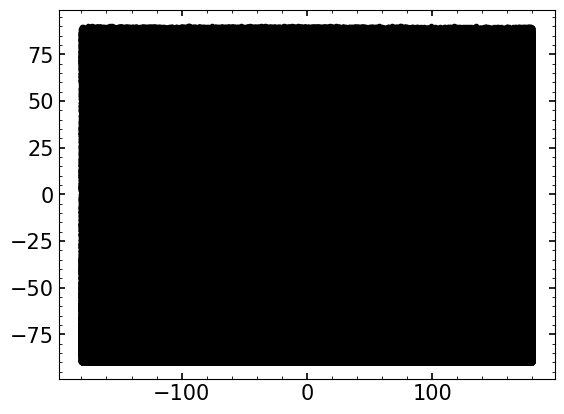

In [92]:
plt.plot(Gphi1,Gphi2,'k.')

In [562]:
print(min_pmra, max_pmra)
print(min_pmdec, max_pmdec)

-1.5 -0.5
1.0 2.0


In [563]:
ind_PM_1 = (pmra>min_pmra) & (pmra<max_pmra) & \
         (pmdec>min_pmdec) & (pmdec<max_pmdec)
ind_PM_2 = (pmra>-0.5) & (pmra<1) & \
         (pmdec>0.5) & (pmdec<1.5)
ind_PM = ind_PM_1 | ind_PM_2
ind_mem = (Gphi1[ind_PM]>min_phi1) & (Gphi1[ind_PM]<max_phi1) & \
          (Gphi2[ind_PM]<max_phi2) & (Gphi2[ind_PM]>min_phi2) & \
          (pmraerr[ind_PM]<0.5) & (pmdecerr[ind_PM]<0.5) 

In [564]:
output_mem = Table()
output_mem["SID"] = data["source_id"][ind_PM][ind_mem]
output_mem["ra"] = data["ra"][ind_PM][ind_mem]
output_mem["dec"] = data["dec"][ind_PM][ind_mem]
output_mem["pmra"] = data["pmra"][ind_PM][ind_mem]
output_mem["pmdec"] = data["pmdec"][ind_PM][ind_mem]
output_mem["pmraerr"] = data["pmra_error"][ind_PM][ind_mem]
output_mem["pmdecerr"] = data["pmdec_error"][ind_PM][ind_mem]
output_mem["Gmag"] = data["phot_g_mean_mag"][ind_PM][ind_mem]
output_mem["BPmag"] = data["phot_bp_mean_mag"][ind_PM][ind_mem]
output_mem["RPmag"] = data["phot_rp_mean_mag"][ind_PM][ind_mem]
output_mem["bb"] = data["b"][ind_PM][ind_mem]
output_mem["ll"] = data["l"][ind_PM][ind_mem]
output_mem["phi1"] = Gphi1[ind_PM][ind_mem]
output_mem["phi2"] = Gphi2[ind_PM][ind_mem]
#output_mem.write("mem_Zhujiang.fits",overwrite=True)

In [565]:
len(data["source_id"][ind_PM][ind_mem])

123

In [566]:
min_plot_phi1, max_plot_phi1 = config["plot_phi1_phi2"].getfloat("min_plot_phi1"), config["plot_phi1_phi2"].getfloat("max_plot_phi1")
min_plot_phi2, max_plot_phi2 = config["plot_phi1_phi2"].getfloat("min_plot_phi2"), config["plot_phi1_phi2"].getfloat("max_plot_phi2")

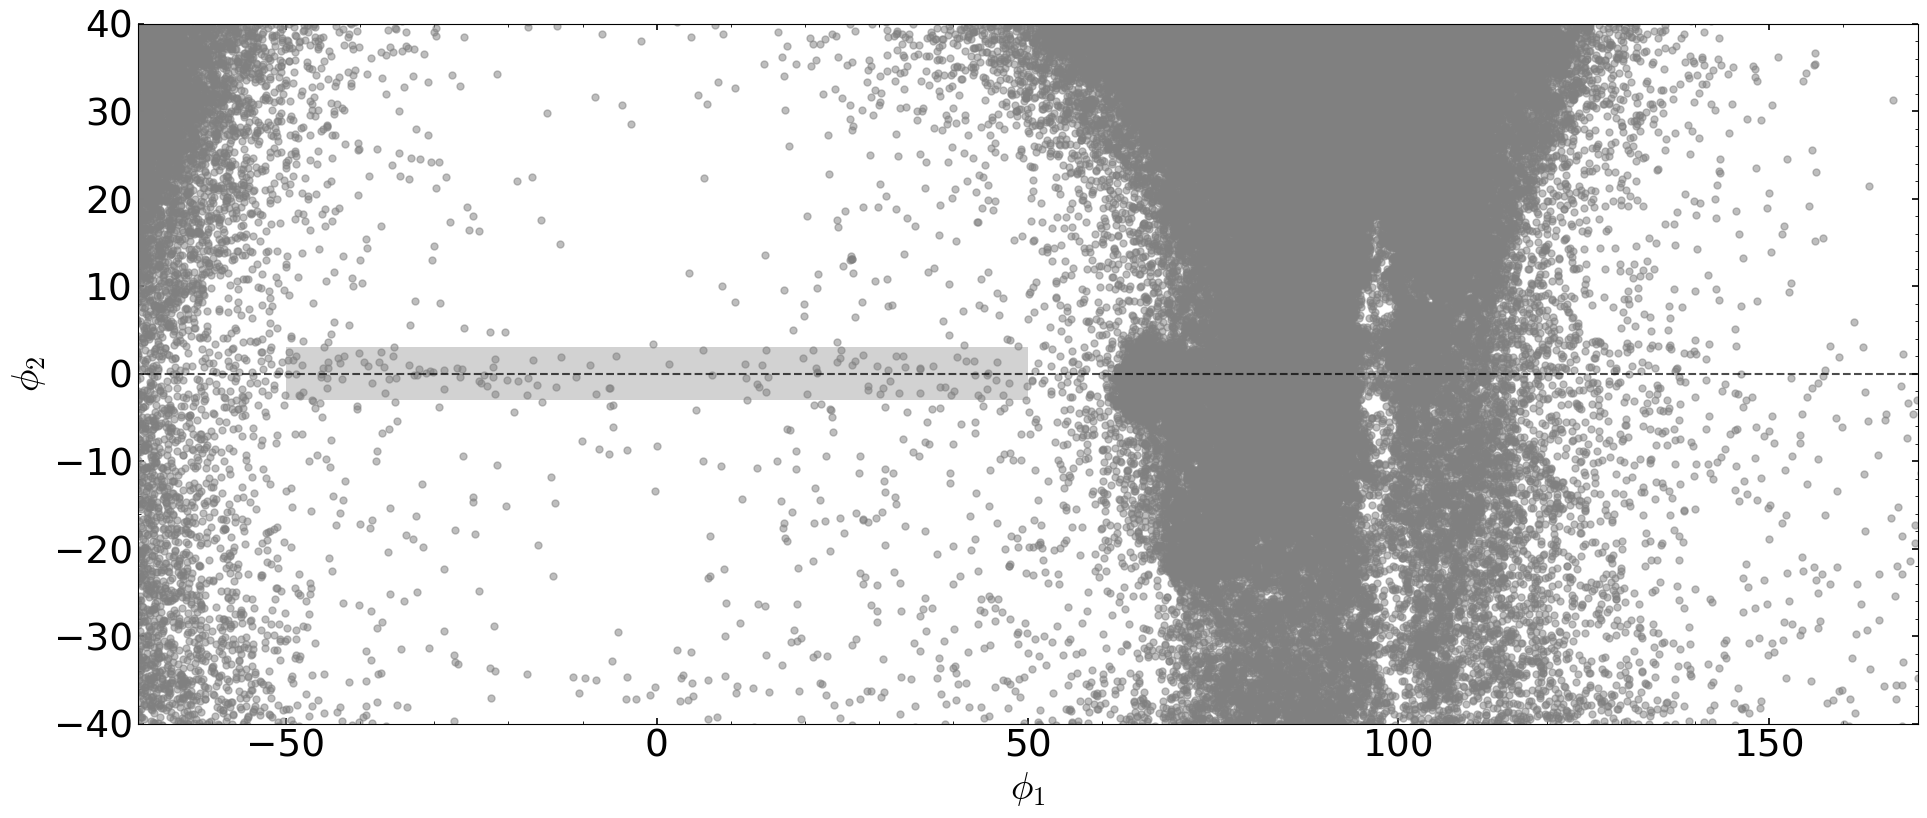

In [34]:
plt.rcParams['text.usetex'] = False

fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0.1, 0.25,0.89,0.7])
plt.fill_between(x=[min_phi1, max_phi1],
                 y1=[min_phi2, min_phi2],
                 y2=[max_phi2, max_phi2],facecolor="gray",alpha=0.35,ec=None)
plt.plot(Gphi1[ind_PM], Gphi2[ind_PM], '.', color="gray",alpha=.51,ms=10)
# plt.plot(Pphi1, Pphi2,"rp",ms=10)
# plt.plot(Gphi1[RV_LT==RV_LT],Gphi2[RV_LT==RV_LT],'r.')
# plt.axis([min_plot_phi1, max_plot_phi1, min_plot_phi2, max_plot_phi2])
plt.hlines(0,-300, 300, colors="k",linestyles="dashed",alpha=0.7)
plt.axis([min_plot_phi1, max_plot_phi1+100, min_plot_phi2, max_plot_phi2])
plt.axis([min_plot_phi1, max_plot_phi1+100, -40, 40])

plt.xlabel(r'$\phi_1$',fontsize=27)
plt.ylabel(r'$\phi_2$',fontsize=27)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
#plt.savefig(plot_path+"LBGC_phi1_phi2.png",dpi=200)
plt.show()

In [567]:
ind_phi1_all = (Gphi1[ind_PM]>min_phi1) & (Gphi1[ind_PM]<max_phi1) & (Gphi2[ind_PM]<max_phi2) & (Gphi2[ind_PM]>min_phi2)


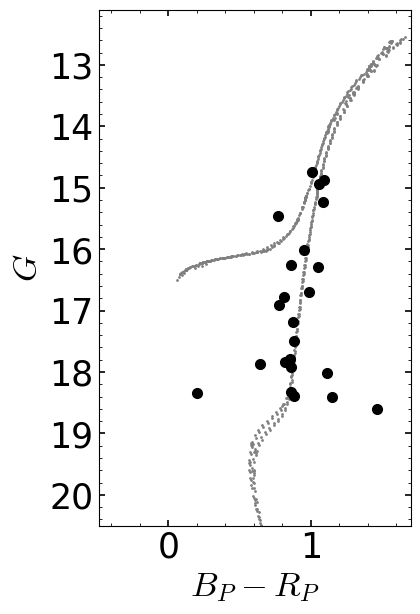

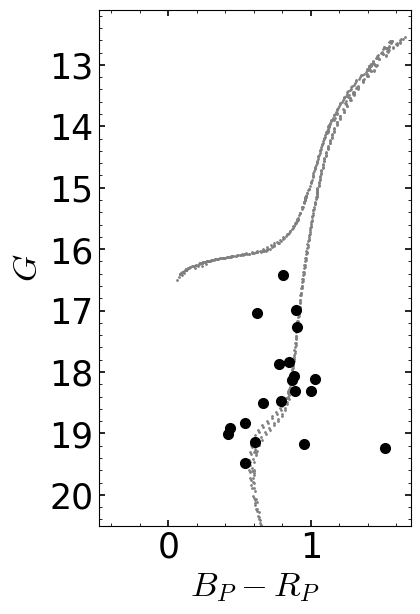

In [122]:
bin_phi1 = np.linspace(min_hist_phi1, max_hist_phi1, n_hist_phi1+1)
for i_phi1 in range(n_hist_phi1):
    ind_pm_phi1 = (Gphi1[ind_PM]>bin_phi1[i_phi1]) & (Gphi1[ind_PM]<bin_phi1[i_phi1+1]) & (np.abs(Gphi2[ind_PM])>max_phi2) & (np.abs(Gphi2[ind_PM])<max_phi2+2)
    # 选择距离中心线 max_phi2 到 max_phi2+1.5 度的星

    # ind_pm_phi1_perr = (Gphi1[ind_PM]>bin_phi1[i_phi1]) & (Gphi1[ind_PM]<bin_phi1[i_phi1+1]) & (Gphi2[ind_PM]<max_phi2) & \
    #                     (Gphi2[ind_PM]>min_phi2) & (pmraerr[ind_PM]<0.2) & (pmdecerr[ind_PM]<0.2) 
    
    
    
    fig = plt.figure(figsize=(4,6))
    ax = fig.add_axes([0.2,0.12,0.78,0.86])
    plt.plot(
             BPmag[ind_PM][ind_pm_phi1]-RPmag[ind_PM][ind_pm_phi1] - 1*(A_BP-A_RP)*ebv[ind_PM][ind_pm_phi1],
             Gmag[ind_PM][ind_pm_phi1]-1*A_G*ebv[ind_PM][ind_pm_phi1], 'o', color="k",  ms=7,alpha=1
            )
    
    if Check_by_BHB:
        plt.plot([min_bprp_BHB,max_bprp_BHB,max_bprp_BHB,min_bprp_BHB, min_bprp_BHB],
                 [min_Gmag_BHB,min_Gmag_BHB,max_Gmag_BHB,max_Gmag_BHB,min_Gmag_BHB],
                 '--'
                )
    # plt.text(-0.25, 20, "Control Sample",fontsize=25)
    # plt.text(-0.25, 13.2, f"{int(bin_phi1[i_phi1])}$^\circ<\\phi_1<${int(bin_phi1[i_phi1+1])}$^\circ$",fontsize=25)
    plt.xlabel("$B_P-R_P$", fontsize=25)
    plt.ylabel("$G$", fontsize=25)
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)
    plt.axis([-0.49, 1.7, 20.5, 12.1])
    if Check_by_iso:
        plt.plot(BPRP_iso, Gmag_iso + DM_iso,'.',color="gray",ms=2, zorder=1)
    
plt.show()

[-50.   0.  50.]


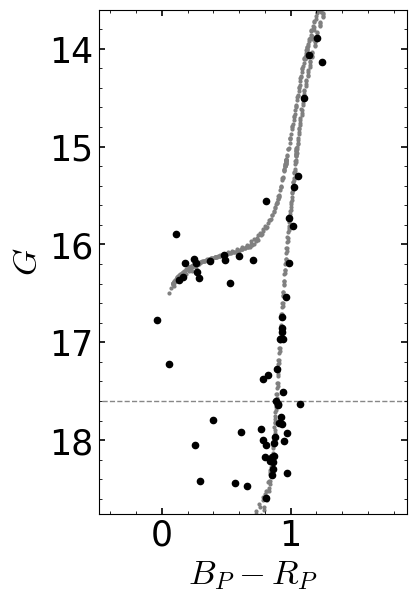

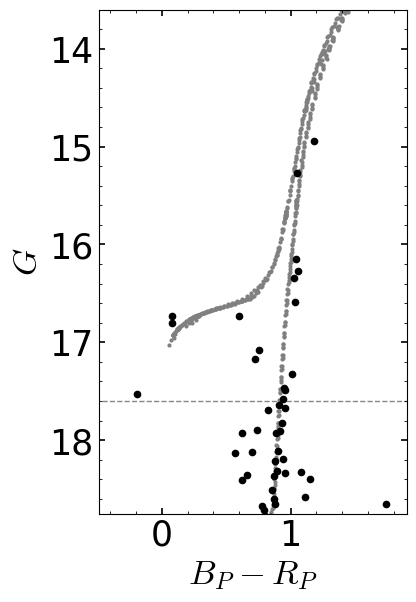

In [99]:
bin_phi1 = np.linspace(min_hist_phi1, max_hist_phi1, n_hist_phi1+1)
print(bin_phi1)

for i_phi1 in range(n_hist_phi1):
    ind_pm_phi1      = (Gphi1[ind_PM]>bin_phi1[i_phi1]) & (Gphi1[ind_PM]<bin_phi1[i_phi1+1]) & \
                        (Gphi2[ind_PM]<max_phi2) & (Gphi2[ind_PM]>min_phi2)
    
    ind_pm_phi1_perr = (Gphi1[ind_PM]>bin_phi1[i_phi1]) & (Gphi1[ind_PM]<bin_phi1[i_phi1+1]) & \
                        (Gphi2[ind_PM]<max_phi2) & (Gphi2[ind_PM]>min_phi2) & \
                        (pmraerr[ind_PM]<0.2) & (pmdecerr[ind_PM]<0.2) 
    
    fig = plt.figure(figsize=(4,6))
    ax = fig.add_axes([0.22,0.14,0.77,0.84])
    # plt.plot(
    #          BPmag[ind_PM][ind_pm_phi1]-RPmag[ind_PM][ind_pm_phi1] - (A_BP-A_RP)*ebv[ind_PM][ind_pm_phi1],
    #          Gmag[ind_PM][ind_pm_phi1]-A_G*ebv[ind_PM][ind_pm_phi1], 'o', color="gray",  ms=6,alpha=1
    #         )
    
    plt.plot(
             BPmag[ind_PM][ind_pm_phi1_perr]-RPmag[ind_PM][ind_pm_phi1_perr] - (A_BP-A_RP)*ebv[ind_PM][ind_pm_phi1_perr],
             Gmag[ind_PM][ind_pm_phi1_perr]-A_G*ebv[ind_PM][ind_pm_phi1_perr], '.',color="k",  ms=9,alpha=1
            )
    
    if Check_by_BHB:
        plt.plot([min_bprp_BHB,max_bprp_BHB,max_bprp_BHB,min_bprp_BHB, min_bprp_BHB],
                 [min_Gmag_BHB,min_Gmag_BHB,max_Gmag_BHB,max_Gmag_BHB,min_Gmag_BHB],
                 '--'
                )
    plt.hlines(y=17.6,xmin=-10,xmax=10, ls='--',color="gray",lw=1,zorder=1,alpha=0.94)
    plt.xlabel("$B_P-R_P$", fontsize=25)
    plt.ylabel("$G$", fontsize=25)
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)
    plt.axis([-0.49, 1.9, 18.75, 13.6])
    if Check_by_iso:
        plt.plot(BPRP_iso, Gmag_iso + DM_iso+i_phi1*0.53,'.',color="gray",ms=4, zorder=1)
plt.show()       

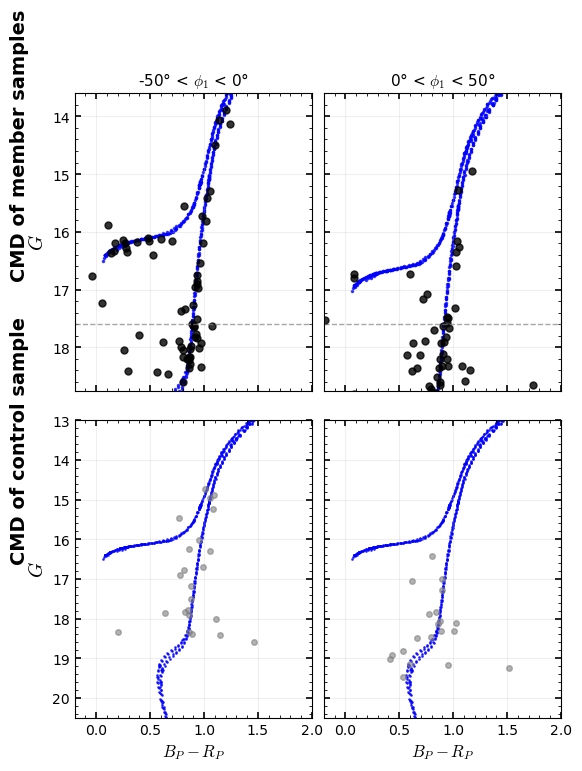

In [568]:
import matplotlib.pyplot as plt
import numpy as np

# 设置参数
bin_phi1 = np.linspace(min_hist_phi1, max_hist_phi1, n_hist_phi1+1)
n_bins = len(bin_phi1) - 1

# 创建一个大图，2行n_bins列
fig, axes = plt.subplots(2, n_bins, figsize=(3*n_bins, 8))

# 如果只有一列，确保axes是2D数组
if n_bins == 1:
    axes = axes.reshape(-1, 1)

# 遍历每个φ1区间
for i_phi1 in range(n_bins):
    
    # ========== 第一行：Member Sample（成员星） ==========
    ax1 = axes[0, i_phi1]
    
    # 成员星：选择星流中心附近的星
    ind_member = (Gphi1[ind_PM]>bin_phi1[i_phi1]) & \
                 (Gphi1[ind_PM]<bin_phi1[i_phi1+1]) & \
                 (Gphi2[ind_PM]<max_phi2) & \
                 (Gphi2[ind_PM]>min_phi2) & \
                 (pmraerr[ind_PM]<0.2) & \
                 (pmdecerr[ind_PM]<0.2)
    
    # 绘制成员星CMD
    ax1.plot(BPmag[ind_PM][ind_member] - RPmag[ind_PM][ind_member] - (A_BP-A_RP)*ebv[ind_PM][ind_member],
             Gmag[ind_PM][ind_member] - A_G*ebv[ind_PM][ind_member], 
             'o', color='black', ms=5, alpha=0.8)
    
    # 添加等龄线（每个区间偏移一点）
    if Check_by_iso:
        ax1.plot(BPRP_iso, Gmag_iso + DM_iso + i_phi1*0.53, 
                '.', color='blue', ms=3, zorder=1, alpha=0.7)
    
    # BHB选择框
    if Check_by_BHB:
        ax1.plot([min_bprp_BHB, max_bprp_BHB, max_bprp_BHB, min_bprp_BHB, min_bprp_BHB],
                 [min_Gmag_BHB, min_Gmag_BHB, max_Gmag_BHB, max_Gmag_BHB, min_Gmag_BHB],
                 'r--', lw=1.5)
    
    # 水平线
    ax1.axhline(y=17.6, ls='--', color='gray', lw=1, alpha=0.7)
    

    # 设置标题（φ1范围）
    ax1.set_title(f"{int(bin_phi1[i_phi1])}° < $\\phi_1$ < {int(bin_phi1[i_phi1+1])}°", 
                  fontsize=11)
    
    # 设置坐标轴
    ax1.set_xlim(-0.2, 2.0)
    ax1.set_ylim(18.75, 13.6)
    ax1.tick_params(labelsize=10)
    ax1.grid(alpha=0.2)
    
    # 只在最左边显示y轴标签
    if i_phi1 == 0:
        ax1.set_ylabel('$G$', fontsize=14)
        ax1.text(-0.8, 14.5, 'CMD of member samples', fontsize=14, 
                rotation=90, va='center', weight='bold')
    else:
        ax1.set_yticklabels([])
    
    # 不显示x轴标签
    ax1.set_xticklabels([])
    
    
    # ========== 第二行：Control Sample（背景星） ==========
    ax2 = axes[1, i_phi1]
    
    # 背景星：选择距离中心线较远的星
    ind_control = (Gphi1[ind_PM]>bin_phi1[i_phi1]) & \
                  (Gphi1[ind_PM]<bin_phi1[i_phi1+1]) & \
                  (np.abs(Gphi2[ind_PM])>max_phi2) & \
                  (np.abs(Gphi2[ind_PM])<max_phi2+2)
    
    # 绘制背景星CMD
    ax2.plot(BPmag[ind_PM][ind_control] - RPmag[ind_PM][ind_control] - (A_BP-A_RP)*ebv[ind_PM][ind_control],
             Gmag[ind_PM][ind_control] - A_G*ebv[ind_PM][ind_control], 
             'o', color='gray', ms=4, alpha=0.6)
    
    # 添加等龄线
    if Check_by_iso:
        ax2.plot(BPRP_iso, Gmag_iso + DM_iso, '.', color='blue', ms=2, zorder=1, alpha=0.7)
    
    # BHB选择框
    if Check_by_BHB:
        ax2.plot([min_bprp_BHB, max_bprp_BHB, max_bprp_BHB, min_bprp_BHB, min_bprp_BHB],
                 [min_Gmag_BHB, min_Gmag_BHB, max_Gmag_BHB, max_Gmag_BHB, min_Gmag_BHB],
                 'r--', lw=1.5)
    
    # 设置坐标轴
    ax2.set_xlim(-0.2, 2.0)
    ax2.set_ylim(20.5, 13)
    ax2.tick_params(labelsize=10)
    ax2.grid(alpha=0.2)
    
    # 只在最左边显示y轴标签
    if i_phi1 == 0:
        ax2.set_ylabel('$G$', fontsize=14)
        ax2.text(-0.8, 13.5, 'CMD of control sample', fontsize=14, 
                rotation=90, va='center', weight='bold')
    else:
        ax2.set_yticklabels([])
    
    # 显示x轴标签
    ax2.set_xlabel('$B_P - R_P$', fontsize=12)


# 调整子图间距
plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.05)

# 保存图片
plt.show()

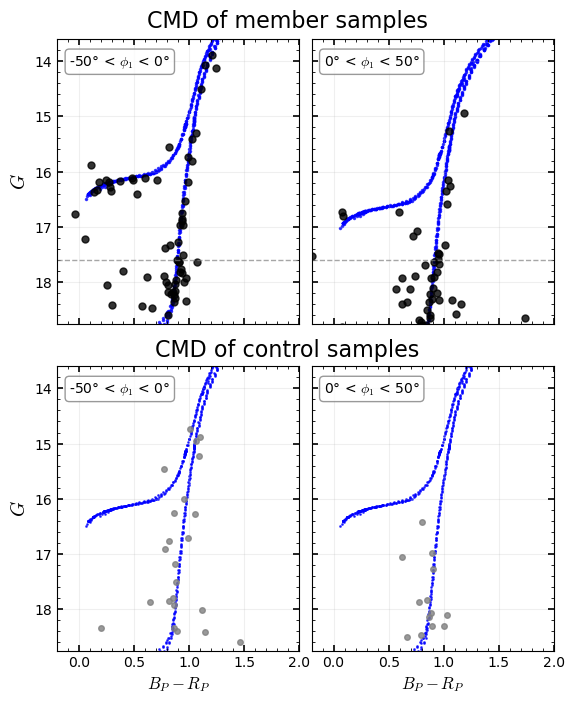

In [569]:
# 设置参数
bin_phi1 = np.linspace(min_hist_phi1, max_hist_phi1, n_hist_phi1+1)
n_bins = len(bin_phi1) - 1

# 创建一个大图，2行n_bins列
fig, axes = plt.subplots(2, n_bins, figsize=(3*n_bins, 7))

# 如果只有一列，确保axes是2D数组
if n_bins == 1:
    axes = axes.reshape(-1, 1)

# 遍历每个φ1区间
for i_phi1 in range(n_bins):
    
    # ========== 第一行：Member Sample（成员星） ==========
    ax1 = axes[0, i_phi1]
    
    # 成员星：选择星流中心附近的星
    ind_member = (Gphi1[ind_PM]>bin_phi1[i_phi1]) & \
                 (Gphi1[ind_PM]<bin_phi1[i_phi1+1]) & \
                 (Gphi2[ind_PM]<max_phi2) & \
                 (Gphi2[ind_PM]>min_phi2) & \
                 (pmraerr[ind_PM]<0.2) & \
                 (pmdecerr[ind_PM]<0.2)
    
    # 绘制成员星CMD
    ax1.plot(BPmag[ind_PM][ind_member] - RPmag[ind_PM][ind_member] - (A_BP-A_RP)*ebv[ind_PM][ind_member],
             Gmag[ind_PM][ind_member] - A_G*ebv[ind_PM][ind_member], 
             'o', color='black', ms=5, alpha=0.8)
    
    # 添加等龄线（每个区间偏移一点）
    if Check_by_iso:
        ax1.plot(BPRP_iso, Gmag_iso + DM_iso + i_phi1*0.53, 
                '.', color='blue', ms=3, zorder=1, alpha=0.7)
    
    # BHB选择框
    if Check_by_BHB:
        ax1.plot([min_bprp_BHB, max_bprp_BHB, max_bprp_BHB, min_bprp_BHB, min_bprp_BHB],
                 [min_Gmag_BHB, min_Gmag_BHB, max_Gmag_BHB, max_Gmag_BHB, min_Gmag_BHB],
                 'r--', lw=1.5)
    
    # 水平线
    ax1.axhline(y=17.6, ls='--', color='gray', lw=1, alpha=0.7)
    
    # 在图内添加φ1范围文本（左上角）
    ax1.text(0.05, 0.95, f"{int(bin_phi1[i_phi1])}° < $\\phi_1$ < {int(bin_phi1[i_phi1+1])}°",
             transform=ax1.transAxes, fontsize=10, va='top', ha='left',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # ax1.set_title('CMD of member samples', fontsize=14, loc='center', pad=10)
    
    # 设置坐标轴
    ax1.set_xlim(-0.2, 2.0)
    ax1.set_ylim(18.75, 13.6)
    ax1.tick_params(labelsize=10)
    ax1.grid(alpha=0.2)
    
    # 只在最左边显示y轴标签
    if i_phi1 == 0:
        ax1.set_ylabel('$G$', fontsize=14)
    else:
        ax1.set_yticklabels([])
    
    # 不显示x轴标签
    ax1.set_xticklabels([])
    
    
    # ========== 第二行：Control Sample（背景星） ==========
    ax2 = axes[1, i_phi1]
    
    # 背景星：选择距离中心线较远的星
    ind_control = (Gphi1[ind_PM]>bin_phi1[i_phi1]) & \
                  (Gphi1[ind_PM]<bin_phi1[i_phi1+1]) & \
                  (np.abs(Gphi2[ind_PM])>max_phi2) & \
                  (np.abs(Gphi2[ind_PM])<max_phi2+2)
    
    # 绘制背景星CMD
    ax2.plot(BPmag[ind_PM][ind_control] - RPmag[ind_PM][ind_control] - (A_BP-A_RP)*ebv[ind_PM][ind_control],
             Gmag[ind_PM][ind_control] - A_G*ebv[ind_PM][ind_control], 
             'o', color='gray', ms=4, alpha=0.8)
    
    # 添加等龄线
    if Check_by_iso:
        ax2.plot(BPRP_iso, Gmag_iso + DM_iso, '.', color='blue', ms=2, zorder=1, alpha=0.7)
    
    # BHB选择框
    if Check_by_BHB:
        ax2.plot([min_bprp_BHB, max_bprp_BHB, max_bprp_BHB, min_bprp_BHB, min_bprp_BHB],
                 [min_Gmag_BHB, min_Gmag_BHB, max_Gmag_BHB, max_Gmag_BHB, min_Gmag_BHB],
                 'r--', lw=1.5)
    
    # 在图内添加φ1范围文本（左上角）
    ax2.text(0.05, 0.95, f"{int(bin_phi1[i_phi1])}° < $\\phi_1$ < {int(bin_phi1[i_phi1+1])}°",
             transform=ax2.transAxes, fontsize=10, va='top', ha='left',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # ax2.set_title('CMD of control sample', fontsize=14, loc='center', pad=10)
    
    # 设置坐标轴
    ax2.set_xlim(-0.2, 2.0)
    ax2.set_ylim(18.75, 13.6)
    ax2.tick_params(labelsize=10)
    ax2.grid(alpha=0.2)
    
    # 只在最左边显示y轴标签
    if i_phi1 == 0:
        ax2.set_ylabel('$G$', fontsize=14)
    else:
        ax2.set_yticklabels([])
    
    # 显示x轴标签
    ax2.set_xlabel('$B_P - R_P$', fontsize=12)

# 添加每一行的总标题（居中）
fig.text(0.5, 1.01, 'CMD of member samples', ha='center', va='top', 
         fontsize=16 )
fig.text(0.5, 0.54, 'CMD of control samples', ha='center', va='top', 
         fontsize=16)
# 调整子图间距
plt.tight_layout()
plt.subplots_adjust(hspace=0.15, wspace=0.05)
plt.show()

In [570]:
# 首先找到LAMOST、DESI、S5星在原始数据中的索引
# 通过source_id匹配
def find_indices_in_PM(sid_spec, sid_pm):
    """找到光谱星在ind_PM中的索引"""
    indices = []
    for sid in sid_spec:
        match = np.where(sid_pm == sid)[0]
        if len(match) > 0:
            indices.append(match[0])
    return np.array(indices)

# 假设你的主数据中有source_id列，名称可能是SID或source_id
# 找到LAMOST、DESI、S5星的索引
idx_L_in_PM = find_indices_in_PM(SID_L, SID[ind_PM])
idx_D_in_PM = find_indices_in_PM(SID_D, SID[ind_PM])
idx_S_in_PM = find_indices_in_PM(SID_S, SID[ind_PM])

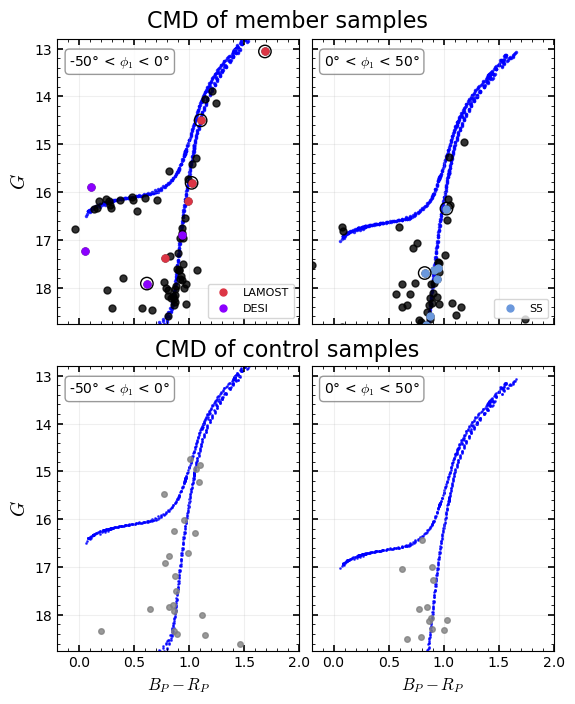

In [479]:
from matplotlib.lines import Line2D
# 设置参数
bin_phi1 = np.linspace(min_hist_phi1, max_hist_phi1, n_hist_phi1+1)
n_bins = len(bin_phi1) - 1

# 创建一个大图，2行n_bins列
fig, axes = plt.subplots(2, n_bins, figsize=(3*n_bins, 7))

# 如果只有一列，确保axes是2D数组
if n_bins == 1:
    axes = axes.reshape(-1, 1)

# 遍历每个φ1区间
for i_phi1 in range(n_bins):
    
    # ========== 第一行：Member Sample（成员星） ==========
    ax1 = axes[0, i_phi1]
    
    # 成员星：选择星流中心附近的星
    ind_member = (Gphi1[ind_PM]>bin_phi1[i_phi1]) & \
                 (Gphi1[ind_PM]<bin_phi1[i_phi1+1]) & \
                 (Gphi2[ind_PM]<max_phi2) & \
                 (Gphi2[ind_PM]>min_phi2) & \
                 (pmraerr[ind_PM]<0.2) & \
                 (pmdecerr[ind_PM]<0.2)
    
    # 绘制成员星CMD
    ax1.plot(BPmag[ind_PM][ind_member] - RPmag[ind_PM][ind_member] - (A_BP-A_RP)*ebv[ind_PM][ind_member],
             Gmag[ind_PM][ind_member] - A_G*ebv[ind_PM][ind_member], 
             'o', color='black', ms=5, alpha=0.8)
    
    # 叠加有光谱的星 - LAMOST (红色)
    idx_L_this_bin = np.where((phi1_L > bin_phi1[i_phi1]) & (phi1_L < bin_phi1[i_phi1+1]))[0]
    if len(idx_L_this_bin) > 0:
        ax1.plot(BPmag_L[idx_L_this_bin] - RPmag_L[idx_L_this_bin] - (A_BP-A_RP)*ebv_L[idx_L_this_bin],
                   Gmag_L[idx_L_this_bin] - A_G*ebv_L[idx_L_this_bin],
                   'o',ms=5, c='#DC3545', label='LAMOST')
    
    # 叠加有光谱的星 - DESI (紫色)
    idx_D_this_bin = np.where((phi1_D > bin_phi1[i_phi1]) & (phi1_D < bin_phi1[i_phi1+1]))[0]
    if len(idx_D_this_bin) > 0:
        ax1.plot(BPmag_D[idx_D_this_bin] - RPmag_D[idx_D_this_bin] - (A_BP-A_RP)*ebv_D[idx_D_this_bin],
                   Gmag_D[idx_D_this_bin] - A_G*ebv_D[idx_D_this_bin],
                   'o',ms=5, c='#8B00FF', label='DESI')
    
    # 叠加有光谱的星 - S5 (蓝色)
    idx_S_this_bin = np.where((phi1_S > bin_phi1[i_phi1]) & (phi1_S < bin_phi1[i_phi1+1]))[0]
    if len(idx_S_this_bin) > 0:
        ax1.plot(BPmag_S[idx_S_this_bin] - RPmag_S[idx_S_this_bin] - (A_BP-A_RP)*ebv_S[idx_S_this_bin],
                   Gmag_S[idx_S_this_bin] - A_G*ebv_S[idx_S_this_bin],
                   'o',ms=5, c='#6B98DC', label='S5')
        
    # ========== 用黑色圆圈标记框外的星 ==========
    # LAMOST 框外星
    idx_L_out = np.where((phi1_L > bin_phi1[i_phi1]) & 
                         (phi1_L < bin_phi1[i_phi1+1]) & 
                         mask_out_L)[0]
    if len(idx_L_out) > 0:
        ax1.scatter(BPmag_L[idx_L_out] - RPmag_L[idx_L_out] - (A_BP-A_RP)*ebv_L[idx_L_out],
                   Gmag_L[idx_L_out] - A_G*ebv_L[idx_L_out],
                   s=80, facecolors='none', edgecolors='black', 
                   linewidths=1, zorder=10)
    
    # DESI 框外星
    idx_D_out = np.where((phi1_D > bin_phi1[i_phi1]) & 
                         (phi1_D < bin_phi1[i_phi1+1]) & 
                         mask_out_D)[0]
    if len(idx_D_out) > 0:
        ax1.scatter(BPmag_D[idx_D_out] - RPmag_D[idx_D_out] - (A_BP-A_RP)*ebv_D[idx_D_out],
                   Gmag_D[idx_D_out] - A_G*ebv_D[idx_D_out],
                   s=80, facecolors='none', edgecolors='black', 
                   linewidths=1, zorder=10)
    
    # S5 框外星
    idx_S_out = np.where((phi1_S > bin_phi1[i_phi1]) & 
                         (phi1_S < bin_phi1[i_phi1+1]) & 
                         mask_out_S)[0]
    if len(idx_S_out) > 0:
        ax1.scatter(BPmag_S[idx_S_out] - RPmag_S[idx_S_out] - (A_BP-A_RP)*ebv_S[idx_S_out],
                   Gmag_S[idx_S_out] - A_G*ebv_S[idx_S_out],
                   s=80, facecolors='none', edgecolors='black', 
                   linewidths=1, zorder=10)
    
    # 添加等龄线（每个区间偏移一点）
    if Check_by_iso:
        ax1.plot(BPRP_iso, Gmag_iso + DM_iso + i_phi1*0.53, 
                '.', color='blue', ms=3, zorder=1, alpha=0.7)
    
    # BHB选择框
    if Check_by_BHB:
        ax1.plot([min_bprp_BHB, max_bprp_BHB, max_bprp_BHB, min_bprp_BHB, min_bprp_BHB],
                 [min_Gmag_BHB, min_Gmag_BHB, max_Gmag_BHB, max_Gmag_BHB, min_Gmag_BHB],
                 'r--', lw=1.5)
    
    # 水平线
    #ax1.axhline(y=17.6, ls='--', color='gray', lw=1, alpha=0.7)
    
    # 在图内添加φ1范围文本（左上角）
    ax1.text(0.05, 0.95, f"{int(bin_phi1[i_phi1])}° < $\\phi_1$ < {int(bin_phi1[i_phi1+1])}°",
             transform=ax1.transAxes, fontsize=10, va='top', ha='left',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # ax1.set_title('CMD of member samples', fontsize=14, loc='center', pad=10)
    
 
    ax1.legend(loc='lower right', fontsize=8)
    
    # 设置坐标轴
    ax1.set_xlim(-0.2, 2.0)
    ax1.set_ylim(18.75, 12.8)
    ax1.tick_params(labelsize=10)
    ax1.grid(alpha=0.2)
    
    # 只在最左边显示y轴标签
    if i_phi1 == 0:
        ax1.set_ylabel('$G$', fontsize=14)
    else:
        ax1.set_yticklabels([])
    
    # 不显示x轴标签
    ax1.set_xticklabels([])
    
    
    # ========== 第二行：Control Sample（背景星） ==========
    ax2 = axes[1, i_phi1]
    
    # 背景星：选择距离中心线较远的星
    ind_control = (Gphi1[ind_PM]>bin_phi1[i_phi1]) & \
                  (Gphi1[ind_PM]<bin_phi1[i_phi1+1]) & \
                  (np.abs(Gphi2[ind_PM])>max_phi2) & \
                  (np.abs(Gphi2[ind_PM])<max_phi2+2)
    
    # 绘制背景星CMD
    ax2.plot(BPmag[ind_PM][ind_control] - RPmag[ind_PM][ind_control] - (A_BP-A_RP)*ebv[ind_PM][ind_control],
             Gmag[ind_PM][ind_control] - A_G*ebv[ind_PM][ind_control], 
             'o', color='gray', ms=4, alpha=0.8)
    
    # 添加等龄线
    if Check_by_iso:
        ax2.plot(BPRP_iso, Gmag_iso + DM_iso + i_phi1*0.53, '.', color='blue', ms=2, zorder=1, alpha=0.7)
    
    # BHB选择框
    if Check_by_BHB:
        ax2.plot([min_bprp_BHB, max_bprp_BHB, max_bprp_BHB, min_bprp_BHB, min_bprp_BHB],
                 [min_Gmag_BHB, min_Gmag_BHB, max_Gmag_BHB, max_Gmag_BHB, min_Gmag_BHB],
                 'r--', lw=1.5)
    
    # 在图内添加φ1范围文本（左上角）
    ax2.text(0.05, 0.95, f"{int(bin_phi1[i_phi1])}° < $\\phi_1$ < {int(bin_phi1[i_phi1+1])}°",
             transform=ax2.transAxes, fontsize=10, va='top', ha='left',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # ax2.set_title('CMD of control sample', fontsize=14, loc='center', pad=10)
    
    # 设置坐标轴
    ax2.set_xlim(-0.2, 2.0)
    ax2.set_ylim(18.75, 12.8)
    ax2.tick_params(labelsize=10)
    ax2.grid(alpha=0.2)
    
    # 只在最左边显示y轴标签
    if i_phi1 == 0:
        ax2.set_ylabel('$G$', fontsize=14)
    else:
        ax2.set_yticklabels([])
    
    # 显示x轴标签
    ax2.set_xlabel('$B_P - R_P$', fontsize=12)

# 添加每一行的总标题（居中）
fig.text(0.5, 1.01, 'CMD of member samples', ha='center', va='top', 
         fontsize=16 )
fig.text(0.5, 0.54, 'CMD of control samples', ha='center', va='top', 
         fontsize=16)
# 调整子图间距
plt.tight_layout()
plt.subplots_adjust(hspace=0.15, wspace=0.05)
plt.savefig("./stream/S2808stream/plot/isochrone.png", dpi = 200, bbox_inches='tight')
plt.show()

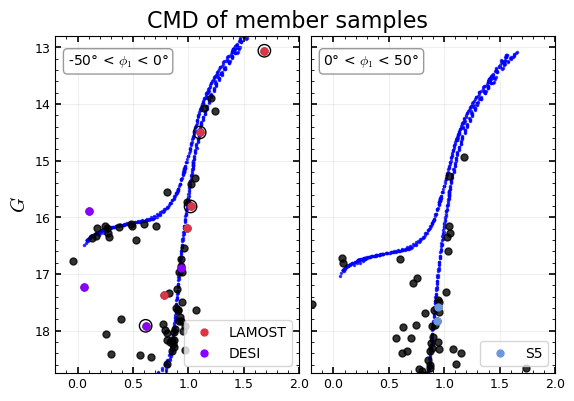

In [575]:
# 画一个没有control sample的图

# 设置参数
bin_phi1 = np.linspace(min_hist_phi1, max_hist_phi1, n_hist_phi1+1)
n_bins = len(bin_phi1) - 1

# 创建一个大图，2行n_bins列
fig, axes = plt.subplots(1, n_bins, figsize=(3*n_bins, 4))

# 如果只有一列，确保axes是2D数组
if n_bins == 1:
    axes = axes.reshape(-1, 1)

# 遍历每个φ1区间
for i_phi1 in range(n_bins):
    
    # ========== 第一行：Member Sample（成员星） ==========
    ax1 = axes[i_phi1]
    
    # 成员星：选择星流中心附近的星
    ind_member = (Gphi1[ind_PM]>bin_phi1[i_phi1]) & \
                 (Gphi1[ind_PM]<bin_phi1[i_phi1+1]) & \
                 (Gphi2[ind_PM]<max_phi2) & \
                 (Gphi2[ind_PM]>min_phi2) & \
                 (pmraerr[ind_PM]<0.2) & \
                 (pmdecerr[ind_PM]<0.2)
    
    # 绘制成员星CMD
    ax1.plot(BPmag[ind_PM][ind_member] - RPmag[ind_PM][ind_member] - (A_BP-A_RP)*ebv[ind_PM][ind_member],
             Gmag[ind_PM][ind_member] - A_G*ebv[ind_PM][ind_member], 
             'o', color='black', ms=5, alpha=0.8)
    
    # 叠加有光谱的星 - LAMOST (红色)
    idx_L_this_bin = np.where((phi1_L > bin_phi1[i_phi1]) & (phi1_L < bin_phi1[i_phi1+1]))[0]
    if len(idx_L_this_bin) > 0:
        ax1.plot(BPmag_L[idx_L_this_bin] - RPmag_L[idx_L_this_bin] - (A_BP-A_RP)*ebv_L[idx_L_this_bin],
                   Gmag_L[idx_L_this_bin] - A_G*ebv_L[idx_L_this_bin],
                   'o',ms=5, c='#DC3545', label='LAMOST')
    
    # 叠加有光谱的星 - DESI (紫色)
    idx_D_this_bin = np.where((phi1_D > bin_phi1[i_phi1]) & (phi1_D < bin_phi1[i_phi1+1]))[0]
    if len(idx_D_this_bin) > 0:
        ax1.plot(BPmag_D[idx_D_this_bin] - RPmag_D[idx_D_this_bin] - (A_BP-A_RP)*ebv_D[idx_D_this_bin],
                   Gmag_D[idx_D_this_bin] - A_G*ebv_D[idx_D_this_bin],
                   'o',ms=5, c='#8B00FF', label='DESI')
    
    # 叠加有光谱的星 - S5 (蓝色)
    idx_S_this_bin = np.where((phi1_S > bin_phi1[i_phi1]) & (phi1_S < bin_phi1[i_phi1+1]))[0]
    if len(idx_S_this_bin) > 0:
        ax1.plot(BPmag_S[idx_S_this_bin] - RPmag_S[idx_S_this_bin] - (A_BP-A_RP)*ebv_S[idx_S_this_bin],
                   Gmag_S[idx_S_this_bin] - A_G*ebv_S[idx_S_this_bin],
                   'o',ms=5, c='#6B98DC', label='S5')
        
    # ========== 用黑色圆圈标记框外的星 ==========
    # LAMOST 框外星
    idx_L_out = np.where((phi1_L > bin_phi1[i_phi1]) & 
                         (phi1_L < bin_phi1[i_phi1+1]) & 
                         mask_out_L)[0]
    if len(idx_L_out) > 0:
        ax1.scatter(BPmag_L[idx_L_out] - RPmag_L[idx_L_out] - (A_BP-A_RP)*ebv_L[idx_L_out],
                   Gmag_L[idx_L_out] - A_G*ebv_L[idx_L_out],
                   s=80, facecolors='none', edgecolors='black', 
                   linewidths=1, zorder=10)
    
    # DESI 框外星
    idx_D_out = np.where((phi1_D > bin_phi1[i_phi1]) & 
                         (phi1_D < bin_phi1[i_phi1+1]) & 
                         mask_out_D)[0]
    if len(idx_D_out) > 0:
        ax1.scatter(BPmag_D[idx_D_out] - RPmag_D[idx_D_out] - (A_BP-A_RP)*ebv_D[idx_D_out],
                   Gmag_D[idx_D_out] - A_G*ebv_D[idx_D_out],
                   s=80, facecolors='none', edgecolors='black', 
                   linewidths=1, zorder=10)
    
    # S5 框外星
    idx_S_out = np.where((phi1_S > bin_phi1[i_phi1]) & 
                         (phi1_S < bin_phi1[i_phi1+1]) & 
                         mask_out_S)[0]
    if len(idx_S_out) > 0:
        ax1.scatter(BPmag_S[idx_S_out] - RPmag_S[idx_S_out] - (A_BP-A_RP)*ebv_S[idx_S_out],
                   Gmag_S[idx_S_out] - A_G*ebv_S[idx_S_out],
                   s=80, facecolors='none', edgecolors='black', 
                   linewidths=1, zorder=10)
    
    # 添加等龄线（每个区间偏移一点）
    if Check_by_iso:
        ax1.plot(BPRP_iso, Gmag_iso + DM_iso + i_phi1*0.53, 
                '.', color='blue', ms=3, zorder=1, alpha=0.7)
    
    # BHB选择框
    if Check_by_BHB:
        ax1.plot([min_bprp_BHB, max_bprp_BHB, max_bprp_BHB, min_bprp_BHB, min_bprp_BHB],
                 [min_Gmag_BHB, min_Gmag_BHB, max_Gmag_BHB, max_Gmag_BHB, min_Gmag_BHB],
                 'r--', lw=1.5)
    
    # 水平线
    #ax1.axhline(y=17.6, ls='--', color='gray', lw=1, alpha=0.7)
    
    # 在图内添加φ1范围文本（左上角）
    ax1.text(0.05, 0.95, f"{int(bin_phi1[i_phi1])}° < $\\phi_1$ < {int(bin_phi1[i_phi1+1])}°",
             transform=ax1.transAxes, fontsize=10, va='top', ha='left',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # ax1.set_title('CMD of member samples', fontsize=14, loc='center', pad=10)
    
 
    ax1.legend(loc='lower right', fontsize=10)
    
    # 设置坐标轴
    ax1.set_xlim(-0.2, 2.0)
    ax1.set_ylim(18.75, 12.8)
    ax1.tick_params(labelsize=9)
    ax1.grid(alpha=0.2)
    
    # 只在最左边显示y轴标签
    if i_phi1 == 0:
        ax1.set_ylabel('$G$', fontsize=14)
    else:
        ax1.set_yticklabels([])


# 添加每一行的总标题（居中）
fig.text(0.5, 1.01, 'CMD of member samples', ha='center', va='top', 
         fontsize=16 )

# 调整子图间距
plt.tight_layout()
plt.subplots_adjust(hspace=0.15, wspace=0.05)
plt.savefig("./stream/S2808stream/plot/isochrone.png", dpi = 200, bbox_inches='tight')
plt.show()

In [584]:
# 修改切向速度和画图

def Correct_PM_From_Solar_Motion(ra, dec, pmra, pmdec, dist, degree=True, kpc=True,
                                 radec=True, X_Sun=8.34, UVW_Sun=[11.1, 12.24, 7.25], V_LSR=232):
    """
    This is used to correct the proper motions from the solar motion,
    the default values are
    X_Sun=8.34, UVW_Sun=[11.1, 12.24, 7.25], V_LSR=232
    return the corrected proper motion along l and b
    """
    import galpy.util.coords as gub
    import numpy as np
    # convert the proper motion along ra dec to those along l b
    if radec:
        llbb = gub.radec_to_lb(ra, dec, degree=True)
        ll = llbb[:, 0]
        bb = llbb[:, 1]
        pmllbb = gub.pmrapmdec_to_pmllpmbb(pmra, pmdec, ra, dec, degree=True)
        pmll = pmllbb[:, 0]
        pmbb = pmllbb[:, 1]
    else:
        ll = ra * 1.
        bb = dec * 1.
        pmll = pmra * 1.
        pmbb = pmdec * 1.

    rvpm = gub.vxvyvz_to_vrpmllpmbb(dist * 0 - UVW_Sun[0], dist * 0 - (V_LSR + UVW_Sun[1]), dist * 0 - UVW_Sun[2],
                                    ll, bb, dist, XYZ=False, degree=True)
    pmlMC = pmll - rvpm[:, 1]
    pmbMC = pmbb - rvpm[:, 2]
    pmradecMC = gub.pmllpmbb_to_pmrapmdec(pmlMC, pmbMC, ll, bb, degree=True)
    return pmlMC, pmbMC, pmradecMC[:, 0], pmradecMC[:, 1]

In [586]:
# get the bright stars with G>17
# 我改成了17.6 为了和CMD的线对齐
ind_G17 = Gmag[ind_PM][ind_pm_phi1]<17.6
dist_iso = 10**(DM_iso*0.2)/100
dist_iso_2 = 10**((DM_iso+0.53)*0.2)/100
print(dist_iso,dist_iso_2)

14.25607593602188 18.197008586099845


In [585]:
# left segment

ind_mem_1 = (Gphi1[ind_PM]>min_phi1) & (Gphi1[ind_PM]<0) & \
          (Gphi2[ind_PM]<max_phi2) & (Gphi2[ind_PM]>min_phi2) & \
          (pmraerr[ind_PM]<0.5) & (pmdecerr[ind_PM]<0.5) 

S_pmlMC_1, S_pmbMC_1, S_pmraMC_1, S_pmdecMC_1 = Correct_PM_From_Solar_Motion(ra[ind_PM][ind_mem_1], dec[ind_PM][ind_mem_1],
                                                                     pmra[ind_PM][ind_mem_1], pmdec[ind_PM][ind_mem_1],
                                                                     ra[ind_PM][ind_mem_1]*0+dist_iso,
                                                                     degree=True, radec=True)

C_RRL_PM_1 = coord.SkyCoord(ra=ra[ind_PM][ind_mem_1]*u.deg,
                          dec=dec[ind_PM][ind_mem_1]*u.deg,
                          pm_ra_cosdec=S_pmraMC_1*u.mas/u.yr,
                          pm_dec=S_pmdecMC_1*u.mas/u.yr)

CRPM_fr_1 = C_RRL_PM_1.transform_to(frame)
RPMphi1_1 = CRPM_fr_1.phi1.deg
RPMphi2_1 = CRPM_fr_1.phi2.deg
RPM_pmphi1_1 = CRPM_fr_1.pm_phi1_cosphi2.value
RPM_pmphi2_1 = CRPM_fr_1.pm_phi2.value

In [587]:
#right segment

ind_mem_2 = (Gphi1[ind_PM]>min_phi1) & (Gphi1[ind_PM]<max_phi1) & \
          (Gphi2[ind_PM]<max_phi2) & (Gphi2[ind_PM]>min_phi2) & \
          (pmraerr[ind_PM]<0.5) & (pmdecerr[ind_PM]<0.5) 

S_pmlMC_2, S_pmbMC_2, S_pmraMC_2, S_pmdecMC_2 = Correct_PM_From_Solar_Motion(ra[ind_PM][ind_mem_2], dec[ind_PM][ind_mem_2],
                                                                     pmra[ind_PM][ind_mem_2], pmdec[ind_PM][ind_mem_2],
                                                                     ra[ind_PM][ind_mem_2]*0+dist_iso_2,
                                                                     degree=True, radec=True)

C_RRL_PM_2 = coord.SkyCoord(ra=ra[ind_PM][ind_mem_2]*u.deg,
                          dec=dec[ind_PM][ind_mem_2]*u.deg,
                          pm_ra_cosdec=S_pmraMC_2*u.mas/u.yr,
                          pm_dec=S_pmdecMC_2*u.mas/u.yr)

CRPM_fr_2 = C_RRL_PM_2.transform_to(frame)
RPMphi1_2 = CRPM_fr_2.phi1.deg
RPMphi2_2 = CRPM_fr_2.phi2.deg
RPM_pmphi1_2 = CRPM_fr_2.pm_phi1_cosphi2.value
RPM_pmphi2_2 = CRPM_fr_2.pm_phi2.value

In [588]:
coords_gala = coord.SkyCoord(ra=ra[ind_PM][ind_pm_phi1]*u.deg,
                             dec=dec[ind_PM][ind_pm_phi1]*u.deg,
                             pm_ra_cosdec=pmra[ind_PM][ind_pm_phi1]*u.mas/u.yr,
                             pm_dec=pmdec[ind_PM][ind_pm_phi1]*u.mas/u.yr,
                             distance=(ra[ind_PM][ind_pm_phi1]*0+10**(DM_iso/5)/100)*u.kpc,
                             radial_velocity=0 * u.km/u.s
                            )


NN = gc.reflex_correct(coords_gala)
pmra_cc = NN.pm_ra_cosdec
pmdec_cc = NN.pm_dec


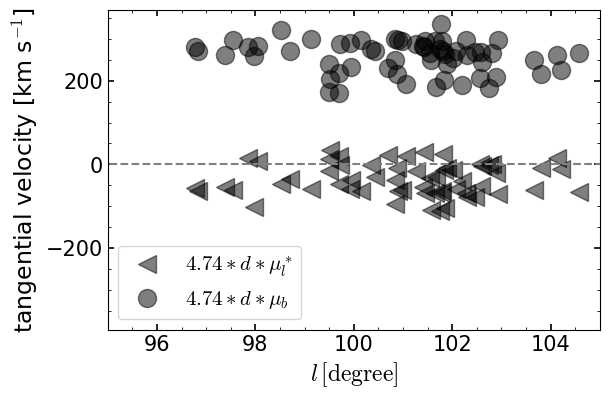

In [156]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.15,0.18, 0.82, 0.8])
plt.plot((ll[ind_PM][ind_mem]+180)%360-180, 4.74*S_pmlMC*dist_iso, "k<", label=r"$4.74*d*\mu_{l}^*$",ms=13, alpha=0.5)
plt.plot((ll[ind_PM][ind_mem]+180)%360-180, 4.74*S_pmbMC*dist_iso, "ko", label=r"$4.74*d*\mu_{b}$",ms=13, alpha=0.5)

plt.hlines(y=0, xmin=-200, xmax=200, linestyle="--",color="gray")
plt.legend(fontsize=15)
plt.xlim([95,105])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r"$l\,\mathrm{[degree]}$",fontsize=17)
plt.ylabel(r"tangential velocity [km s$^{-1}$]", fontsize=17)
plt.show()

In [527]:
DM_iso, DM_iso + 0.53

(15.77, 16.3)

In [589]:
# 假设距离都使用相同的等龄线距离
# dist_iso = 10**(DM_iso*0.2)/100

# ========== LAMOST 数据处理 ==========
S_pmlMC_L, S_pmbMC_L, S_pmraMC_L, S_pmdecMC_L = Correct_PM_From_Solar_Motion(
    ra_L, dec_L, pmra_L, pmdec_L, 
    ra_L*0 + dist_iso,
    degree=True, radec=True
)

# ========== DESI 数据处理 ==========
S_pmlMC_D, S_pmbMC_D, S_pmraMC_D, S_pmdecMC_D = Correct_PM_From_Solar_Motion(
    ra_D, dec_D, pmra_D, pmdec_D, 
    ra_D*0 + dist_iso,
    degree=True, radec=True
)

# ========== S5 数据处理 ==========
S_pmlMC_S, S_pmbMC_S, S_pmraMC_S, S_pmdecMC_S = Correct_PM_From_Solar_Motion(
    ra_S, dec_S, pmra_S, pmdec_S, 
    ra_S*0 + dist_iso_2,
    degree=True, radec=True
)

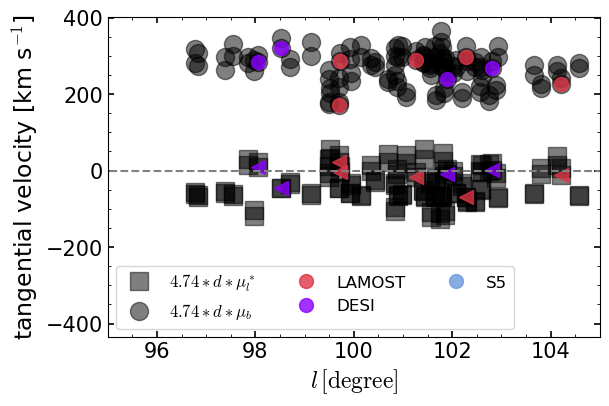

In [591]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.15,0.18, 0.82, 0.8])

plt.plot((ll[ind_PM][ind_mem_1]+180)%360-180, 4.74*S_pmlMC_1*dist_iso, "ks", label=r"$4.74*d*\mu_{l}^*$",ms=13, alpha=0.5)
plt.plot((ll[ind_PM][ind_mem_1]+180)%360-180, 4.74*S_pmbMC_1*dist_iso, "ko", label=r"$4.74*d*\mu_{b}$",ms=13, alpha=0.5)

plt.plot((ll[ind_PM][ind_mem_2]+180)%360-180, 4.74*S_pmlMC_2*dist_iso_2, "ks",ms=13, alpha=0.5)
plt.plot((ll[ind_PM][ind_mem_2]+180)%360-180, 4.74*S_pmbMC_2*dist_iso_2, "ko",ms=13, alpha=0.5)

# LAMOST (红色)
plt.plot((ll_L+180)%360-180, 4.74*S_pmlMC_L*dist_iso, 
         "<", ms=10, color="#DC3545", alpha=0.8,)
plt.plot((ll_L+180)%360-180, 4.74*S_pmbMC_L*dist_iso, 
         "o", ms=10, color="#DC3545", alpha=0.8,label="LAMOST")

# DESI (紫色)
plt.plot((ll_D+180)%360-180, 4.74*S_pmlMC_D*dist_iso, 
         "<", ms=10, color="#8B00FF", alpha=0.8)
plt.plot((ll_D+180)%360-180, 4.74*S_pmbMC_D*dist_iso, 
         "o", ms=10, color="#8B00FF", alpha=0.8,label="DESI")

# S5 (蓝色)
plt.plot((ll_S+180)%360-180, 4.74*S_pmlMC_S*dist_iso_2, 
         "<", ms=10, color="#6B98DC", alpha=0.8)
plt.plot((ll_S+180)%360-180, 4.74*S_pmbMC_S*dist_iso_2, 
         "o", ms=10, color="#6B98DC", alpha=0.8,label="S5")

# 零速度参考线
plt.hlines(y=0, xmin=-200, xmax=200, linestyle="--",color="gray")

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#DC3545', markersize=10, 
           label='LAMOST'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#8B00FF', markersize=10, 
           label='DESI'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#6B98DC', markersize=10, 
           label='S5')
]

plt.legend(fontsize=12,ncol=3)
plt.xlim([95,105])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r"$l\,\mathrm{[degree]}$",fontsize=17)
plt.ylabel(r"tangential velocity [km s$^{-1}$]", fontsize=17)
plt.show()

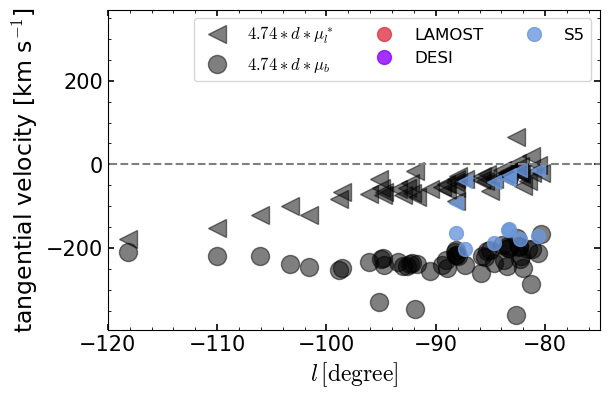

In [530]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.15,0.18, 0.82, 0.8])

plt.plot((ll[ind_PM][ind_mem]+180)%360-180, 4.74*S_pmlMC*dist_iso, "k<", label=r"$4.74*d*\mu_{l}^*$",ms=13, alpha=0.5)
plt.plot((ll[ind_PM][ind_mem]+180)%360-180, 4.74*S_pmbMC*dist_iso, "ko", label=r"$4.74*d*\mu_{b}$",ms=13, alpha=0.5)

# LAMOST (红色)
plt.plot((ll_L+180)%360-180, 4.74*S_pmlMC_L*dist_iso, 
         "<", ms=10, color="#DC3545", alpha=0.8,)
plt.plot((ll_L+180)%360-180, 4.74*S_pmbMC_L*dist_iso, 
         "o", ms=10, color="#DC3545", alpha=0.8,label="LAMOST")

# DESI (紫色)
plt.plot((ll_D+180)%360-180, 4.74*S_pmlMC_D*dist_iso, 
         "<", ms=10, color="#8B00FF", alpha=0.8)
plt.plot((ll_D+180)%360-180, 4.74*S_pmbMC_D*dist_iso, 
         "o", ms=10, color="#8B00FF", alpha=0.8,label="DESI")

# S5 (蓝色)
plt.plot((ll_S+180)%360-180, 4.74*S_pmlMC_S*dist_iso, 
         "<", ms=10, color="#6B98DC", alpha=0.8)
plt.plot((ll_S+180)%360-180, 4.74*S_pmbMC_S*dist_iso, 
         "o", ms=10, color="#6B98DC", alpha=0.8,label="S5")

# 零速度参考线
plt.hlines(y=0, xmin=-200, xmax=200, linestyle="--",color="gray")

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#DC3545', markersize=10, 
           label='LAMOST'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#8B00FF', markersize=10, 
           label='DESI'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#6B98DC', markersize=10, 
           label='S5')
]

plt.legend(fontsize=12,ncol=3)
plt.xlim([-120,-75])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r"$l\,\mathrm{[degree]}$",fontsize=17)
plt.ylabel(r"tangential velocity [km s$^{-1}$]", fontsize=17)
plt.show()

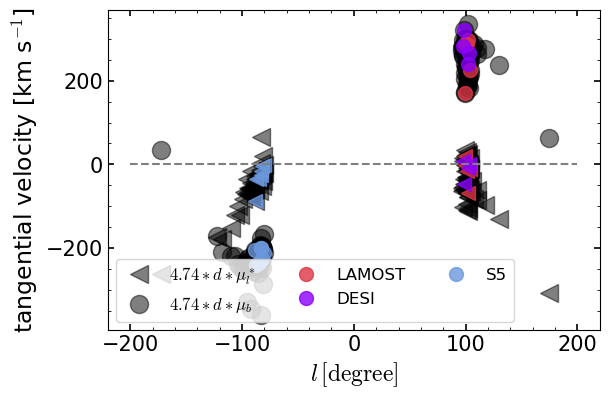

In [192]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.15,0.18, 0.82, 0.8])

plt.plot((ll[ind_PM][ind_mem]+180)%360-180, 4.74*S_pmlMC*dist_iso, "k<", label=r"$4.74*d*\mu_{l}^*$",ms=13, alpha=0.5)
plt.plot((ll[ind_PM][ind_mem]+180)%360-180, 4.74*S_pmbMC*dist_iso, "ko", label=r"$4.74*d*\mu_{b}$",ms=13, alpha=0.5)

# LAMOST (红色)
plt.plot((ll_L+180)%360-180, 4.74*S_pmlMC_L*dist_iso, 
         "<", ms=10, color="#DC3545", alpha=0.8,)
plt.plot((ll_L+180)%360-180, 4.74*S_pmbMC_L*dist_iso, 
         "o", ms=10, color="#DC3545", alpha=0.8,label="LAMOST")

# DESI (紫色)
plt.plot((ll_D+180)%360-180, 4.74*S_pmlMC_D*dist_iso, 
         "<", ms=10, color="#8B00FF", alpha=0.8)
plt.plot((ll_D+180)%360-180, 4.74*S_pmbMC_D*dist_iso, 
         "o", ms=10, color="#8B00FF", alpha=0.8,label="DESI")

# S5 (蓝色)
plt.plot((ll_S+180)%360-180, 4.74*S_pmlMC_S*dist_iso, 
         "<", ms=10, color="#6B98DC", alpha=0.8)
plt.plot((ll_S+180)%360-180, 4.74*S_pmbMC_S*dist_iso, 
         "o", ms=10, color="#6B98DC", alpha=0.8,label="S5")

# 零速度参考线
plt.hlines(y=0, xmin=-200, xmax=200, linestyle="--",color="gray")

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#DC3545', markersize=10, 
           label='LAMOST'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#8B00FF', markersize=10, 
           label='DESI'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#6B98DC', markersize=10, 
           label='S5')
]

plt.legend(fontsize=12,ncol=3)
#plt.xlim([-120,-75])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r"$l\,\mathrm{[degree]}$",fontsize=17)
plt.ylabel(r"tangential velocity [km s$^{-1}$]", fontsize=17)
plt.show()

In [610]:
mock_n = 10000
#mock_pmra=np.random.uniform(min_pmra,max_pmra,mock_n)
mock_pmra=np.random.uniform(min_pmra,1,mock_n)
mock_pmdec=np.random.uniform(0.5,max_pmdec,mock_n)
mock_phi1 = np.linspace(min_phi1,max_phi1,201)
mock_dist = np.zeros_like(mock_phi1)+dist_iso #dist_phi1(mock_phi1)

# 按phi1的值分段
#transition_phi1 = (min_phi1 + max_phi1) / 2  # 或者你指定的具体phi1值
#mock_dist = np.where(mock_phi1 < transition_phi1, dist_iso, dist_iso_2)

mock_phi2 = np.random.uniform(min_phi2, max_phi2, mock_n)
min_vphi1_mock = np.zeros_like(mock_phi1)
max_vphi1_mock = np.zeros_like(mock_phi1)
min_vphi2_mock = np.zeros_like(mock_phi1)
max_vphi2_mock = np.zeros_like(mock_phi1)
for i_mock_phi1 in range(len(mock_phi1)):
# for i_mock_phi1 in range(1):
    mock_fr = gc.GreatCircleICRSFrame(
        phi1=(np.zeros_like(mock_phi2)+mock_phi1[i_mock_phi1])*u.degree,
        phi2=mock_phi2*u.degree,
        pole=frame.pole,
        origin=frame.origin
    )
    mock_equ = mock_fr.transform_to(coord.ICRS())
    mock_ra = mock_equ.ra.deg
    mock_dec = mock_equ.dec.deg

    mock_pmlMC, mock_pmbMC, mock_pmraMC, mock_pmdecMC = Correct_PM_From_Solar_Motion(mock_ra, mock_dec,
                                                                                     mock_pmra, mock_pmdec,
                                                                                     mock_ra*0+mock_dist[i_mock_phi1],
                                                                                     degree=True, radec=True)

    mock_coord = coord.SkyCoord(ra=mock_ra*u.deg,
                                dec=mock_dec*u.deg,
                                pm_ra_cosdec=mock_pmraMC*u.mas/u.yr,
                                pm_dec=mock_pmdecMC*u.mas/u.yr)
    
    mock_fr = mock_coord.transform_to(frame)
    cmock_phi1 = mock_fr.phi1.deg
    cmock_phi2 = mock_fr.phi2.deg
    cmock_pmphi1 = mock_fr.pm_phi1_cosphi2.value
    cmock_pmphi2 = mock_fr.pm_phi2.value
    
    min_vphi1_mock[i_mock_phi1] = np.min(cmock_pmphi1*mock_dist[i_mock_phi1]*4.74)
    max_vphi1_mock[i_mock_phi1] = np.max(cmock_pmphi1*mock_dist[i_mock_phi1]*4.74)
    
    min_vphi2_mock[i_mock_phi1] = np.min(cmock_pmphi2*mock_dist[i_mock_phi1]*4.74)
    max_vphi2_mock[i_mock_phi1] = np.max(cmock_pmphi2*mock_dist[i_mock_phi1]*4.74)
    
# here below is used to check the conversion
# c_mock = coord.SkyCoord(ra=mock_ra*u.deg,
#                         dec=mock_dec*u.deg,
#                         pm_ra_cosdec=mock_pmra*u.mas/u.yr,
#                         pm_dec=mock_pmdec*u.mas/u.yr)
# fr_mock = c_mock.transform_to(frame)
# plt.plot(mock_phi2, fr_mock.phi2.deg,'k.',ms=1)

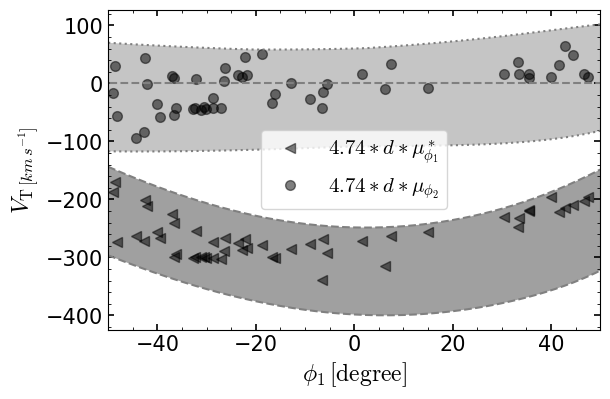

In [228]:
ind_G18 = Gmag[ind_PM][ind_mem]<17.6
bin_phi1_vphi = np.linspace(min_phi1,max_phi1,n_hist_phi1+1)

mean_Vphi1 = np.zeros_like(bin_phi1_vphi[1:])
std_Vphi1 = np.zeros_like(bin_phi1_vphi[1:])
mean_Vphi2 = np.zeros_like(bin_phi1_vphi[1:])
std_Vphi2 = np.zeros_like(bin_phi1_vphi[1:])

for i_vphi1 in range(len(bin_phi1_vphi)-1):
    ind_phi1_tmp = (RPMphi1[ind_G18]>bin_phi1_vphi[i_vphi1]) & (RPMphi1[ind_G18]<bin_phi1_vphi[i_vphi1+1])
    mean_Vphi1[i_vphi1] = np.mean(4.74*RPM_pmphi1[ind_G18][ind_phi1_tmp]*dist_iso)
    std_Vphi1[i_vphi1] = np.std(4.74*RPM_pmphi1[ind_G18][ind_phi1_tmp]*dist_iso)
    mean_Vphi2[i_vphi1] = np.mean(4.74*RPM_pmphi2[ind_G18][ind_phi1_tmp]*dist_iso)
    std_Vphi2[i_vphi1] = np.std(4.74*RPM_pmphi2[ind_G18][ind_phi1_tmp]*dist_iso)


fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.15,0.18, 0.82, 0.8])
# plt.plot(RPMphi1, 4.74*RPM_pmphi1*dist_iso, "k<", label="$4.74*d*\mu_{\phi_1}^*$",ms=13, alpha=0.25)
# plt.plot(RPMphi1, 4.74*RPM_pmphi2*dist_iso, "ko", label="$4.74*d*\mu_{\phi_2}$",ms=13, alpha=0.25)
plt.plot(RPMphi1[ind_G18], 4.74*RPM_pmphi1[ind_G18]*dist_iso, "k<", label=r"$4.74*d*\mu_{\phi_1}^*$",ms=7, alpha=0.5)
plt.plot(RPMphi1[ind_G18], 4.74*RPM_pmphi2[ind_G18]*dist_iso, "ko", label=r"$4.74*d*\mu_{\phi_2}$",ms=7, alpha=0.5)

# plt.plot(LPMphi1, 4.74*LPM_pmphi1*dist_iso, "<",color="#DC3545", ms=7, alpha=0.95)
# plt.plot(LPMphi1, 4.74*LPM_pmphi2*dist_iso, "o",color="#DC3545", ms=7, alpha=0.95)

# plt.plot(DPMphi1, 4.74*DPM_pmphi1*dist_iso, "<",color="#8B00FF", ms=7, alpha=0.95)
# plt.plot(DPMphi1, 4.74*DPM_pmphi2*dist_iso, "o",color="#8B00FF", ms=7, alpha=0.95)

# plt.plot(RPMphi1[ind_RV_GRV], 4.74*RPM_pmphi1[ind_RV_GRV]*dist_iso, "m<",ms=13, alpha=1)
# plt.plot(RPMphi1[ind_RV_GRV], 4.74*RPM_pmphi2[ind_RV_GRV]*dist_iso, "mo",ms=13, alpha=1)

# plt.plot(RPMphi1[ind_RV_GLT], 4.74*RPM_pmphi1[ind_RV_GLT]*dist_iso, "b<",ms=13, alpha=1)
# plt.plot(RPMphi1[ind_RV_GLT], 4.74*RPM_pmphi2[ind_RV_GLT]*dist_iso, "bo",ms=13, alpha=1)
plt.legend(fontsize=15)

plt.fill_between(x=mock_phi1,
                 y1=min_vphi1_mock,
                 y2=max_vphi1_mock,facecolor="gray",alpha=0.75,ec=None)

plt.fill_between(x=mock_phi1,
                 y1=min_vphi2_mock,
                 y2=max_vphi2_mock,facecolor="gray",alpha=0.45,ec=None)
plt.plot(mock_phi1,min_vphi1_mock,'--',color="gray")
plt.plot(mock_phi1,max_vphi1_mock,'--',color="gray")

plt.plot(mock_phi1,min_vphi2_mock,':',color="gray")
plt.plot(mock_phi1,max_vphi2_mock,':',color="gray")

plt.hlines(y=0,xmin=-100,xmax=100,color="gray",ls="--")

# plt.errorbar((bin_phi1_vphi[1:]+bin_phi1_vphi[:-1])/2, mean_Vphi1,
#              yerr=std_Vphi1,color="#2ca02c",capsize=2,lw=3)
# plt.errorbar((bin_phi1_vphi[1:]+bin_phi1_vphi[:-1])/2, mean_Vphi2,
#              yerr=std_Vphi2,color="#2ca02c",capsize=2,lw=3)

plt.xlim([-50,50])
plt.legend(loc="center")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r"$\phi_1\,\mathrm{[degree]}$",fontsize=17)
plt.ylabel(r"$V_{\mathrm{T}\,[km\,s^{-1}]}$", fontsize=17)
plt.show()

In [595]:
bin_phi1_vphi = np.linspace(min_phi1,max_phi1,n_hist_phi1+1)
bin_phi1_vphi[1:]

array([ 0., 50.])

In [611]:
ind_G18_1 = Gmag[ind_PM][ind_mem_1]<17.6
ind_G18_2 = Gmag[ind_PM][ind_mem_2]<17.6

bin_phi1_vphi = np.linspace(min_phi1,max_phi1,n_hist_phi1+1)
bin_phi1_vphi[1:]

mean_Vphi1 = np.zeros_like(bin_phi1_vphi[1:])
std_Vphi1 = np.zeros_like(bin_phi1_vphi[1:])
mean_Vphi2 = np.zeros_like(bin_phi1_vphi[1:])
std_Vphi2 = np.zeros_like(bin_phi1_vphi[1:])

ind_phi1_tmp_1 = (RPMphi1_1[ind_G18_1]>-50) & (RPMphi1_1[ind_G18_1]<0)
mean_Vphi1[0] = np.mean(4.74*RPM_pmphi1_1[ind_G18_1][ind_phi1_tmp_1]*dist_iso)
std_Vphi1[0] = np.std(4.74*RPM_pmphi1_1[ind_G18_1][ind_phi1_tmp_1]*dist_iso)
mean_Vphi2[0] = np.mean(4.74*RPM_pmphi2_1[ind_G18_1][ind_phi1_tmp_1]*dist_iso)
std_Vphi2[0] = np.std(4.74*RPM_pmphi2_1[ind_G18_1][ind_phi1_tmp_1]*dist_iso)

ind_phi1_tmp_2 = (RPMphi1_2[ind_G18_2]>-50) & (RPMphi1_2[ind_G18_2]<0)
mean_Vphi1[1] = np.mean(4.74*RPM_pmphi1_2[ind_G18_2][ind_phi1_tmp_2]*dist_iso_2)
std_Vphi1[1] = np.std(4.74*RPM_pmphi1_2[ind_G18_2][ind_phi1_tmp_2]*dist_iso_2)
mean_Vphi2[1] = np.mean(4.74*RPM_pmphi1_2[ind_G18_2][ind_phi1_tmp_2]*dist_iso_2)
std_Vphi2[1] = np.std(4.74*RPM_pmphi2_2[ind_G18_2][ind_phi1_tmp_2]*dist_iso_2)


In [598]:
# 定义选择框范围
rv_min, rv_max = -50, 50
mh_min, mh_max = -2.5, -1.5

# 计算哪些星在框外
mask_out_L = (RV_L < rv_min) | (RV_L > rv_max) | (MH_L < mh_min) | (MH_L > mh_max)
mask_out_D = (RV_D < rv_min) | (RV_D > rv_max) | (MH_D < mh_min) | (MH_D > mh_max)
mask_out_S = (RV_S < rv_min) | (RV_S > rv_max) | (MH_S < mh_min) | (MH_S > mh_max)

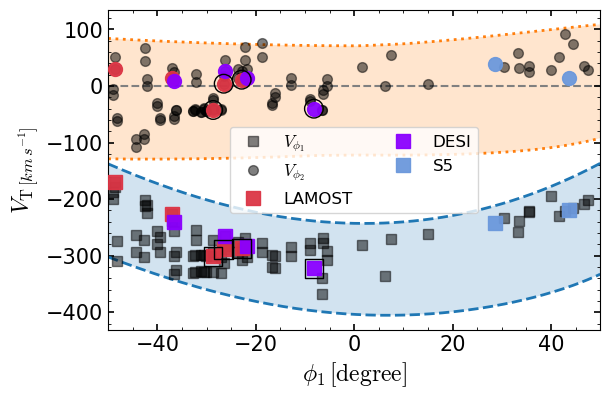

In [612]:
# ========== 转换到流坐标系 ==========
# LAMOST
Lcoord = coord.SkyCoord(
    ra=ra_L*u.deg,
    dec=dec_L*u.deg,
    pm_ra_cosdec=S_pmraMC_L*u.mas/u.yr,
    pm_dec=S_pmdecMC_L*u.mas/u.yr
)
Lfr = Lcoord.transform_to(frame)
LPMphi1 = Lfr.phi1.deg
LPM_pmphi1 = Lfr.pm_phi1_cosphi2.value
LPM_pmphi2 = Lfr.pm_phi2.value

# DESI
Dcoord = coord.SkyCoord(
    ra=ra_D*u.deg,
    dec=dec_D*u.deg,
    pm_ra_cosdec=S_pmraMC_D*u.mas/u.yr,
    pm_dec=S_pmdecMC_D*u.mas/u.yr
)
Dfr = Dcoord.transform_to(frame)
DPMphi1 = Dfr.phi1.deg
DPM_pmphi1 = Dfr.pm_phi1_cosphi2.value
DPM_pmphi2 = Dfr.pm_phi2.value

# S5
Scoord = coord.SkyCoord(
    ra=ra_S*u.deg,
    dec=dec_S*u.deg,
    pm_ra_cosdec=S_pmraMC_S*u.mas/u.yr,
    pm_dec=S_pmdecMC_S*u.mas/u.yr
)
Sfr = Scoord.transform_to(frame)
SPMphi1 = Sfr.phi1.deg
SPM_pmphi1 = Sfr.pm_phi1_cosphi2.value
SPM_pmphi2 = Sfr.pm_phi2.value

# ========== 绘图 ==========

fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.15,0.18, 0.82, 0.8])

# 灰色阴影区域
plt.fill_between(x=mock_phi1,
                 y1=min_vphi1_mock,
                 y2=max_vphi1_mock,
                 facecolor="#1f77b4", alpha=0.2, ec=None, zorder=1)

plt.fill_between(x=mock_phi1,
                 y1=min_vphi2_mock,
                 y2=max_vphi2_mock,
                 facecolor="#ff7f0e", alpha=0.2, ec=None, zorder=1)

plt.plot(mock_phi1, min_vphi1_mock, '--', color="#1f77b4", lw=2, zorder=2)
plt.plot(mock_phi1, max_vphi1_mock, '--', color="#1f77b4", lw=2, zorder=2)
plt.plot(mock_phi1, min_vphi2_mock, ':', color="#ff7f0e", lw=2, zorder=2)
plt.plot(mock_phi1, max_vphi2_mock, ':', color="#ff7f0e", lw=2, zorder=2)

# 零线
plt.hlines(y=0, xmin=-100, xmax=100, color="gray", ls="--", zorder=1)

# Gaia 主样本（黑色小点）
plt.plot(RPMphi1_1[ind_G18_1], 4.74*RPM_pmphi1_1[ind_G18_1]*dist_iso, 
         "ks", label=r"$V_{\phi_1}$", ms=7, alpha=0.5, zorder=2)
plt.plot(RPMphi1_1[ind_G18_1], 4.74*RPM_pmphi2_1[ind_G18_1]*dist_iso, 
         "ko", label=r"$V_{\phi_2}$", ms=7, alpha=0.5, zorder=2)

plt.plot(RPMphi1_2[ind_G18_2], 4.74*RPM_pmphi1_2[ind_G18_2]*dist_iso_2, 
         "ks", ms=7, alpha=0.5, zorder=2)
plt.plot(RPMphi1_2[ind_G18_2], 4.74*RPM_pmphi2_2[ind_G18_2]*dist_iso_2, 
         "ko", ms=7, alpha=0.5, zorder=2)

# 光谱巡天数据（彩色大点）
# LAMOST
plt.plot(LPMphi1, 4.74*LPM_pmphi1*dist_iso, 
           "s", color='#DC3545', ms=10,
           label='LAMOST', alpha=0.95, zorder=4)
plt.plot(LPMphi1, 4.74*LPM_pmphi2*dist_iso, 
           "o", color='#DC3545', ms=10,
           alpha=0.95, zorder=4)

# DESI
plt.plot(DPMphi1, 4.74*DPM_pmphi1*dist_iso, 
           "s", color='#8B00FF', ms=10,
           label='DESI', alpha=0.95, zorder=4)
plt.plot(DPMphi1, 4.74*DPM_pmphi2*dist_iso, 
           "o", color='#8B00FF', ms=10,
           alpha=0.95, zorder=4)

# S5
plt.plot(SPMphi1, 4.74*SPM_pmphi1*dist_iso_2, 
           "s", color='#6B98DC', ms=10,
           label='S5', alpha=0.95, zorder=4)
plt.plot(SPMphi1, 4.74*SPM_pmphi2*dist_iso_2, 
           "o", color='#6B98DC', ms=10,
           alpha=0.95, zorder=4)

# ========== 用黑色圆圈标记框外的星 ==========
# LAMOST 框外星 - 需要同时标记 phi1 和 phi2 方向
if np.any(mask_out_L):
    plt.scatter(LPMphi1[mask_out_L], 4.74*LPM_pmphi1[mask_out_L]*dist_iso,
               s=180, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=10, marker='s')
    plt.scatter(LPMphi1[mask_out_L], 4.74*LPM_pmphi2[mask_out_L]*dist_iso,
               s=180, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=10, marker='o')

# DESI 框外星
if np.any(mask_out_D):
    plt.scatter(DPMphi1[mask_out_D], 4.74*DPM_pmphi1[mask_out_D]*dist_iso,
               s=180, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=10, marker='s')
    plt.scatter(DPMphi1[mask_out_D], 4.74*DPM_pmphi2[mask_out_D]*dist_iso,
               s=180, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=10, marker='o')

# S5 框外星
if np.any(mask_out_S):
    plt.scatter(SPMphi1[mask_out_S], 4.74*SPM_pmphi1[mask_out_S]*dist_iso_2,
               s=180, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=10, marker='s')
    plt.scatter(SPMphi1[mask_out_S], 4.74*SPM_pmphi2[mask_out_S]*dist_iso_2,
               s=180, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=10, marker='o')

# 图例和标签
plt.xlim([-50, 50])
plt.legend(loc="center", fontsize=12, ncol=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r"$\phi_1\,\mathrm{[degree]}$", fontsize=17)
plt.ylabel(r"$V_{\mathrm{T}\,[km\,s^{-1}]}$", fontsize=17)
plt.savefig("./stream/S2808stream/plot/velocity.png", dpi=200, bbox_inches='tight')
plt.show()

In [307]:
SPMphi1[idx_S_out]

array([45.89018421, 42.77967152])

plot the space distribution
空间分布图

In [193]:
ll_disk = np.linspace(0,360,10001)
bb_disk_list = np.array([17,18,19,20,21])
str_bb_disk_list = np.array(['17','18','19','20','21'])
clr_bb_disk_list = np.array(["orangered","sandybrown","dodgerblue","darkturquoise","darkviolet","deeppink"])

Phi_disk_rcd = {}
for i_bb_disk_list in range(len(str_bb_disk_list)):
    radec_disk_tmp = guc.lb_to_radec(ll_disk, ll_disk*0+bb_disk_list[i_bb_disk_list], degree=True)
    C_disk_tmp = coord.SkyCoord(ra=radec_disk_tmp[:,0]*u.deg,dec=radec_disk_tmp[:,1]*u.deg)
    C_disk_fr = C_disk_tmp.transform_to(frame)
    Phi_disk_rcd[str_bb_disk_list[i_bb_disk_list]+"_phi1"] = C_disk_fr.phi1.deg
    Phi_disk_rcd[str_bb_disk_list[i_bb_disk_list]+"_phi2"] = C_disk_fr.phi2.deg


In [194]:
Phi_disk_rcd[str_bb_disk_list[i_bb_disk_list]]=10

In [197]:
fn_sl = "./stream/S2808stream/GDR3_SCAN_LAW.fits"
dt_sl = fits.open(fn_sl)
data_sl = dt_sl[1].data
ra_sl = data_sl["ra_fov1"]
dec_sl = data_sl["dec_fov1"]

C_SL = coord.SkyCoord(ra=ra_sl*u.deg,dec=dec_sl*u.deg)
C_SL_fr = C_SL.transform_to(frame)
SLphi1 = C_SL_fr.phi1.deg
SLphi2 = C_SL_fr.phi2.deg
bin_phi1_sl = np.linspace(-100,100,401)
bin_phi2_sl = np.linspace(-15,15,161)
H_sl_phi, Hx_sl_phi, Hy_sl_phi = np.histogram2d(SLphi1, SLphi2, bins=(bin_phi1_sl, bin_phi2_sl))

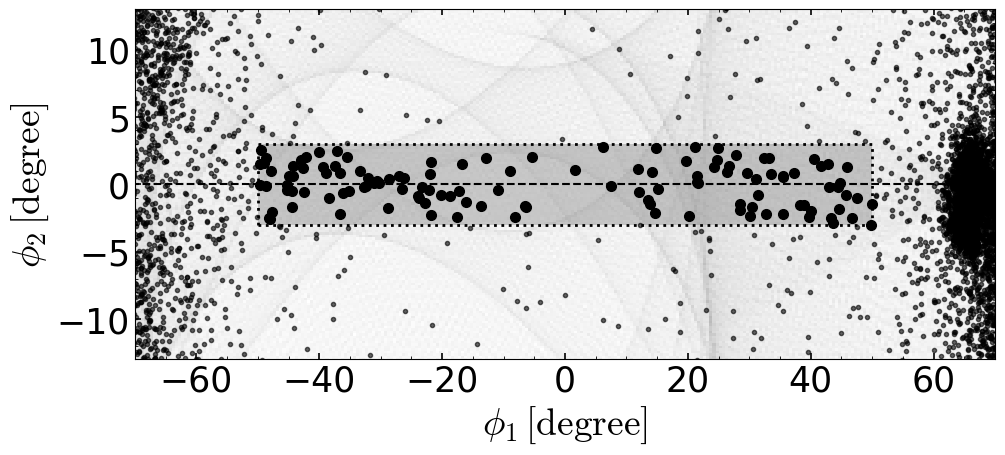

In [202]:
import matplotlib as mpl
cmap = plt.get_cmap("jet")
norm = mpl.colors.Normalize(vmin=15, vmax=35)
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0.12, 0.25,0.86,0.7])
plt.pcolormesh(Hx_sl_phi, Hy_sl_phi,H_sl_phi.T,cmap="binary",alpha=1)
plt.fill_between(x=[min_phi1, max_phi1],
                 y1=[min_phi2, min_phi2],
                 y2=[max_phi2, max_phi2],facecolor="gray",alpha=0.4,ec=None)

plt.vlines(x=[max_phi1,min_phi1],ymin=min_phi2,ymax=max_phi2,color="k",linestyle=":",linewidth=2)
plt.hlines(y=[max_phi2,min_phi2],xmin=min_phi1,xmax=max_phi1,color="k",linestyle=":",linewidth=2)
plt.plot(Gphi1[ind_PM], Gphi2[ind_PM], 'o',color="k",alpha=0.6,zorder=1,ms=3)
plt.plot(RPMphi1, RPMphi2, 'k.',ms=14,alpha=1,zorder=1)
# plt.plot(Lphi1[ind_mem_L], Lphi2[ind_mem_L], '.',color="#DC3545",alpha=1,zorder=1,ms=13,label="$\mathrm{LAMOST}$")
# plt.plot(Dphi1, Dphi2, '.',color="#8B00FF",alpha=1,zorder=1,ms=13,label="$\mathrm{DESI}$")
plt.hlines(y=0,xmin=-100,xmax=100,ls="--",color="k")
# plt.quiver(LPMphi1, LPMphi2, LPM_pmphi1*4.74*dist_iso, LPM_pmphi2*4.74*dist_iso,scale=3000,zorder=2,alpha=0.95,color="#DC3545")
# plt.quiver(DPMphi1, DPMphi2, DPM_pmphi1*4.74*dist_iso, DPM_pmphi2*4.74*dist_iso,scale=3000,zorder=2,alpha=0.95,color="#8B00FF")
    
#plt.legend(loc=2, fontsize=18)
plt.axis([min_plot_phi1, max_plot_phi1, min_plot_phi2, max_plot_phi2])
# plt.axis([-70, 70,-20,20])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'$\phi_1\,\mathrm{[degree]}$',fontsize=27)
plt.ylabel(r'$\phi_2\,\mathrm{[degree]}$',fontsize=27)
plt.show()
# plt.plot(LPMphi1,RV_L[ind_mem_L],'k.')

In [251]:
from scipy.optimize import curve_fit

def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def calculate_stream_snr(phi1_data, phi2_data, phi1_min, phi1_max, phi2_min, phi2_max, n_bins):
    """计算某段星流的SNR"""
    ind_seg = (phi1_data > phi1_min) & (phi1_data < phi1_max) & \
              (phi2_data > phi2_min) & (phi2_data < phi2_max)
    
    bin_phi2 = np.linspace(phi2_min, phi2_max, n_bins+1)
    hy_phi2, hx_phi2 = np.histogram(phi2_data[ind_seg], bins=bin_phi2)
    
    # 高斯拟合
    try:
        parameters, covariance = curve_fit(gauss, (hx_phi2[1:]+hx_phi2[:-1])*0.5, hy_phi2)
        para_err = np.sqrt(np.diag(covariance))
        amplitude = parameters[1] * np.sqrt(2*np.pi) * parameters[3]
        amplitude_err = para_err[1] * np.sqrt(2*np.pi) * parameters[3]
        
        # 计算SNR
        ind_phi2_bg = np.abs((hx_phi2[1:]+hx_phi2[:-1])*0.5) > 2
        background_std = np.std(hy_phi2[ind_phi2_bg])
        SNR = amplitude / background_std if background_std > 0 else 0
        
        # 生成拟合曲线
        sxx = np.linspace(phi2_min, phi2_max, 1000)
        syy = gauss(sxx, *parameters)
        
        return {
            'ind': ind_seg,
            'bins': hx_phi2,
            'counts': hy_phi2,
            'fit_x': sxx,
            'fit_y': syy,
            'params': parameters,
            'amplitude': amplitude,
            'amplitude_err': amplitude_err,
            'SNR': SNR,
            'background_std': background_std,
            'n_stars': np.sum(ind_seg)
        }
    except:
        return None

# ========== 分段计算 ==========
phi1_split = 0  # 分割点
phi2_min = min_hist_phi2
phi2_max = max_hist_phi2
n_bins = n_hist_phi2

# 左段
left_result = calculate_stream_snr(
    Gphi1[ind_PM], Gphi2[ind_PM], 
    min_phi1, phi1_split, 
    phi2_min, phi2_max, n_bins
)

# 右段  
right_result = calculate_stream_snr(
    Gphi1[ind_PM], Gphi2[ind_PM], 
    phi1_split, max_phi1, 
    phi2_min, phi2_max, n_bins
)

# ========== 打印统计信息 ==========
if left_result:
    print("="*50)
    print("LEFT SEGMENT:")
    print(f"  N stars: {left_result['n_stars']}")
    print(f"  Amplitude: {left_result['amplitude']:.1f} ± {left_result['amplitude_err']:.1f}")
    print(f"  Background std: {left_result['background_std']:.2f}")
    print(f"  SNR: {left_result['SNR']:.1f}")
    print(f"  Width: {np.deg2rad(left_result['params'][3])*dist_iso:.3f} kpc")

if right_result:
    print("="*50)
    print("RIGHT SEGMENT:")
    print(f"  N stars: {right_result['n_stars']}")
    print(f"  Amplitude: {right_result['amplitude']:.1f} ± {right_result['amplitude_err']:.1f}")
    print(f"  Background std: {right_result['background_std']:.2f}")
    print(f"  SNR: {right_result['SNR']:.1f}")
    print(f"  Width: {np.deg2rad(right_result['params'][3])*dist_iso:.3f} kpc")
    print("="*50)

LEFT SEGMENT:
  N stars: 142
  Amplitude: 112.7 ± 12.2
  Background std: 2.92
  SNR: 38.5
  Width: 0.457 kpc
RIGHT SEGMENT:
  N stars: 156
  Amplitude: 86.0 ± 14.4
  Background std: 3.03
  SNR: 28.4
  Width: 0.596 kpc


In [524]:
left_result['params'][3],right_result['params'][3]

(1.8381474300418958, 2.394342104152791)

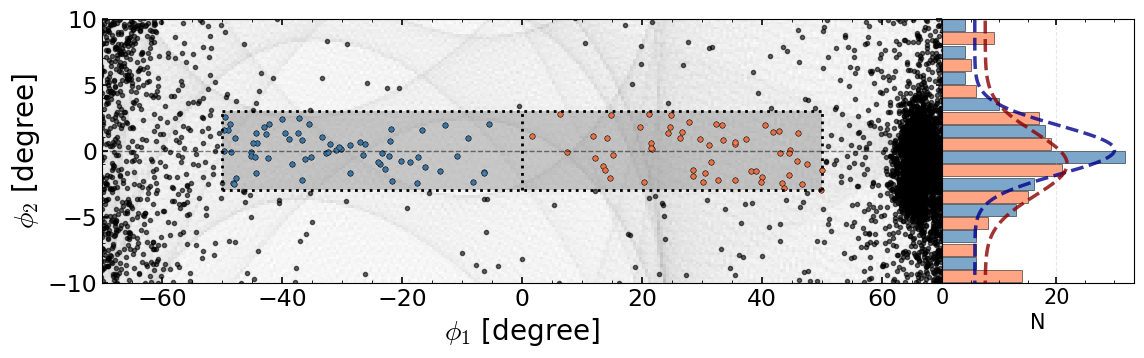

In [273]:
cmap = plt.get_cmap("jet")
norm = mpl.colors.Normalize(vmin=15, vmax=35)

fig = plt.figure(figsize=(12, 4))

# 左侧主图
ax_main = fig.add_axes([0.12, 0.3,0.7,0.66])

plt.pcolormesh(Hx_sl_phi, Hy_sl_phi, H_sl_phi.T, cmap="binary", alpha=1)
plt.fill_between(x=[min_phi1, max_phi1],
                 y1=[min_phi2, min_phi2],
                 y2=[max_phi2, max_phi2],facecolor="gray",alpha=0.4,ec=None)


plt.vlines(x=[max_phi1,min_phi1],ymin=min_phi2,ymax=max_phi2,color="k",linestyle=":",linewidth=2)
plt.hlines(y=[max_phi2,min_phi2],xmin=min_phi1,xmax=max_phi1,color="k",linestyle=":",linewidth=2)
plt.plot(Gphi1[ind_PM], Gphi2[ind_PM], 'o',color="k",alpha=0.6,zorder=1,ms=3)
plt.plot(RPMphi1, RPMphi2, 'ko',ms=3,alpha=1,zorder=1)

# 成员星（更亮的点）
ind_mem_left = (RPMphi1 > min_phi1) & (RPMphi1 < phi1_split)
ind_mem_right = (RPMphi1 >= phi1_split) & (RPMphi1 < max_phi1)

ax_main.scatter(RPMphi1[ind_mem_left], RPMphi2[ind_mem_left], 
               s=15, c='steelblue', alpha=0.9, edgecolors='k', linewidths=0.3)
ax_main.scatter(RPMphi1[ind_mem_right], RPMphi2[ind_mem_right], 
               s=15, c='coral', alpha=0.9, edgecolors='k', linewidths=0.3)

# 分界线
ax_main.vlines(x=phi1_split, ymin=-3, ymax=3, color='k', ls=':', lw=2)
ax_main.axhline(0, color='k', ls='--', lw=1, alpha=0.5)

ax_main.set_xlim([min_plot_phi1, max_plot_phi1])
ax_main.set_ylim([-10, 10])
ax_main.set_xlabel(r'$\phi_1$ [degree]', fontsize=20)
ax_main.set_ylabel(r'$\phi_2$ [degree]', fontsize=20)
ax_main.tick_params(labelsize=17)

# 右侧对比直方图
ax_hist = fig.add_axes([0.82, 0.3,0.16,0.66])

if left_result and right_result:
    bin_centers = (left_result['bins'][:-1] + left_result['bins'][1:]) / 2
    bin_width = np.diff(left_result['bins'])[0]
    
    # 归一化显示（可选，如果想看相对强度）
    # counts_left_norm = left_result['counts'] / left_result['n_stars'] * 100
    # counts_right_norm = right_result['counts'] / right_result['n_stars'] * 100
    
    # 直接显示counts
    counts_left = left_result['counts']
    counts_right = right_result['counts']
    
    # 并排柱状图
    ax_hist.barh(bin_centers - bin_width/4, counts_left, 
                height=bin_width/2.2, color='steelblue', alpha=0.7, 
                edgecolor='k', linewidth=0.5)
    ax_hist.barh(bin_centers + bin_width/4, counts_right, 
                height=bin_width/2.2, color='coral', alpha=0.7, 
                edgecolor='k', linewidth=0.5)
    
    # 高斯拟合曲线
    ax_hist.plot(left_result['fit_y'], left_result['fit_x'], 
                '--', color='darkblue', lw=2.5, alpha=0.8)
    ax_hist.plot(right_result['fit_y'], right_result['fit_x'], 
                '--', color='darkred', lw=2.5, alpha=0.8)
    
    # 背景水平线（可选）
    # ax_hist.axvline(left_result['params'][0], color='steelblue', ls=':', lw=1.5, alpha=0.5)
    # ax_hist.axvline(right_result['params'][0], color='coral', ls=':', lw=1.5, alpha=0.5)
ax_hist.set_yticks([])
ax_hist.set_ylim([-10, 10])
ax_hist.set_xlabel('N', fontsize=15)
ax_hist.tick_params(labelsize=15)
ax_hist.grid(axis='x', alpha=0.3, ls='--')

plt.show()

In [281]:
# 加上箭头
# ========== 转换自行到流坐标系 ==========

# ---------- LAMOST ----------
# 太阳运动改正
S_pmlMC_L, S_pmbMC_L, S_pmraMC_L, S_pmdecMC_L = Correct_PM_From_Solar_Motion(
    ra_L, dec_L, pmra_L, pmdec_L, 
    ra_L*0 + dist_iso,
    degree=True, radec=True
)

# 转换自行到流坐标系
Lcoord = coord.SkyCoord(
    ra=ra_L*u.deg,
    dec=dec_L*u.deg,
    pm_ra_cosdec=S_pmraMC_L*u.mas/u.yr,
    pm_dec=S_pmdecMC_L*u.mas/u.yr
)
Lfr = Lcoord.transform_to(frame)
LPM_pmphi1 = Lfr.pm_phi1_cosphi2.value
LPM_pmphi2 = Lfr.pm_phi2.value

# ---------- DESI ----------
S_pmlMC_D, S_pmbMC_D, S_pmraMC_D, S_pmdecMC_D = Correct_PM_From_Solar_Motion(
    ra_D, dec_D, pmra_D, pmdec_D, 
    ra_D*0 + dist_iso,
    degree=True, radec=True
)

Dcoord = coord.SkyCoord(
    ra=ra_D*u.deg,
    dec=dec_D*u.deg,
    pm_ra_cosdec=S_pmraMC_D*u.mas/u.yr,
    pm_dec=S_pmdecMC_D*u.mas/u.yr
)
Dfr = Dcoord.transform_to(frame)
DPM_pmphi1 = Dfr.pm_phi1_cosphi2.value
DPM_pmphi2 = Dfr.pm_phi2.value

# ---------- S5 ----------
S_pmlMC_S, S_pmbMC_S, S_pmraMC_S, S_pmdecMC_S = Correct_PM_From_Solar_Motion(
    ra_S, dec_S, pmra_S, pmdec_S, 
    ra_S*0 + dist_iso,
    degree=True, radec=True
)

Scoord = coord.SkyCoord(
    ra=ra_S*u.deg,
    dec=dec_S*u.deg,
    pm_ra_cosdec=S_pmraMC_S*u.mas/u.yr,
    pm_dec=S_pmdecMC_S*u.mas/u.yr
)
Sfr = Scoord.transform_to(frame)
SPM_pmphi1 = Sfr.pm_phi1_cosphi2.value
SPM_pmphi2 = Sfr.pm_phi2.value

# ========== 合并数据用于绘制箭头 ==========
phi1_all = np.concatenate([phi1_L, phi1_D, phi1_S])
phi2_all = np.concatenate([phi2_L, phi2_D, phi2_S])
pmphi1_all = np.concatenate([LPM_pmphi1, DPM_pmphi1, SPM_pmphi1])
pmphi2_all = np.concatenate([LPM_pmphi2, DPM_pmphi2, SPM_pmphi2])

# 距离信息（统一距离）
dist_all = np.ones_like(phi1_all) * dist_iso

# survey标识（用于不同颜色/标记）
survey_label = np.concatenate([
    np.full(len(phi1_L), 0),  # LAMOST = 0
    np.full(len(phi1_D), 1),  # DESI = 1
    np.full(len(phi1_S), 2)   # S5 = 2
])

print(f"Total spectroscopic stars: {len(phi1_all)}")
print(f"  LAMOST: {len(phi1_L)}")
print(f"  DESI: {len(phi1_D)}")
print(f"  S5: {len(phi1_S)}")

Total spectroscopic stars: 16
  LAMOST: 5
  DESI: 4
  S5: 7


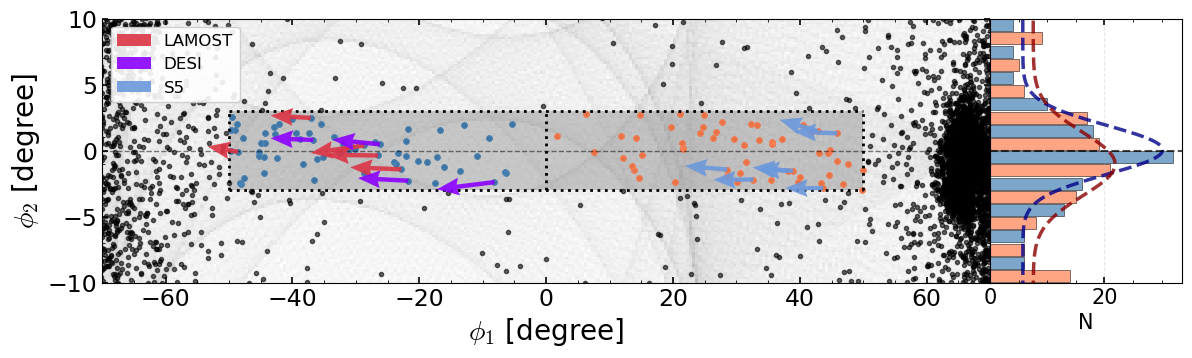

In [331]:
import matplotlib as mpl

fig = plt.figure(figsize=(12, 4))

# 左侧主图（不需要给colorbar留空间了）
ax_main = fig.add_axes([0.08, 0.3, 0.74, 0.66])

plt.pcolormesh(Hx_sl_phi, Hy_sl_phi, H_sl_phi.T, cmap="binary", alpha=1)
plt.fill_between(x=[min_phi1, max_phi1],
                 y1=[min_phi2, min_phi2],
                 y2=[max_phi2, max_phi2], facecolor="gray", alpha=0.4, ec=None)

plt.vlines(x=[max_phi1, min_phi1], ymin=min_phi2, ymax=max_phi2, 
          color="k", linestyle=":", linewidth=2)
plt.hlines(y=[max_phi2, min_phi2], xmin=min_phi1, xmax=max_phi1, 
          color="k", linestyle=":", linewidth=2)
plt.plot(Gphi1[ind_PM], Gphi2[ind_PM], 'o', color="k", alpha=0.6, zorder=1, ms=3)
plt.plot(RPMphi1, RPMphi2, 'ko', ms=3, alpha=1, zorder=1)

# 成员星（更亮的点）
ind_mem_left = (RPMphi1 > min_phi1) & (RPMphi1 < phi1_split)
ind_mem_right = (RPMphi1 >= phi1_split) & (RPMphi1 < max_phi1)

ax_main.scatter(RPMphi1[ind_mem_left], RPMphi2[ind_mem_left], 
               s=15, c='steelblue', alpha=0.9)
ax_main.scatter(RPMphi1[ind_mem_right], RPMphi2[ind_mem_right], 
               s=15, c='coral', alpha=0.9)

# ========== 添加自行箭头（按survey分别绘制）==========
# LAMOST - 红色
quiver_L = ax_main.quiver(phi1_L, phi2_L, 
                          LPM_pmphi1 * 4.74 * dist_iso, 
                          LPM_pmphi2 * 4.74 * dist_iso,
                          scale=5000, width=0.005, 
                          headwidth=4, headlength=5,
                          color='#DC3545', alpha=0.9, zorder=10,
                          label="LAMOST")

# DESI - 紫色
quiver_D = ax_main.quiver(phi1_D, phi2_D, 
                          DPM_pmphi1 * 4.74 * dist_iso, 
                          DPM_pmphi2 * 4.74 * dist_iso,
                          scale=5000, width=0.005, 
                          headwidth=4, headlength=5,
                          color='#8B00FF', alpha=0.9, zorder=10,
                          label="DESI")

# S5 - 蓝色
quiver_S = ax_main.quiver(phi1_S, phi2_S, 
                          SPM_pmphi1 * 4.74 * dist_iso, 
                          SPM_pmphi2 * 4.74 * dist_iso,
                          scale=5000, width=0.005, 
                          headwidth=4, headlength=5,
                          color='#6B98DC', alpha=0.9, zorder=10,
                          label="S5")

## 非成员星
# ========== 给框外星的箭头加黑色边框 ==========
# LAMOST 框外星
## np.any(mask_out_L):
#    quiver_L_out = ax_main.quiver(phi1_L[mask_out_L], phi2_L[mask_out_L], 
#                                   LPM_pmphi1[mask_out_L] * 4.74 * dist_iso, 
#                                   LPM_pmphi2[mask_out_L] * 4.74 * dist_iso,
#                                   scale=5000, width=0.005, 
#                                   headwidth=4, headlength=5,
#                                   edgecolors='black', linewidths=1,
#                                   facecolors='#DC3545', alpha=1, zorder=11)
## DESI 框外星
#if np.any(mask_out_D):
#    quiver_D_out = ax_main.quiver(phi1_D[mask_out_D], phi2_D[mask_out_D], 
#                                   DPM_pmphi1[mask_out_D] * 4.74 * dist_iso, 
#                                   DPM_pmphi2[mask_out_D] * 4.74 * dist_iso,
#                                   scale=5000, width=0.005, 
#                                   headwidth=4, headlength=5,
#                                   edgecolors='black', linewidths=1,
#                                   facecolors='#8B00FF', alpha=1, zorder=11)
#
## S5 框外星
#if np.any(mask_out_S):
#    quiver_S_out = ax_main.quiver(phi1_S[mask_out_S], phi2_S[mask_out_S], 
#                                   SPM_pmphi1[mask_out_S] * 4.74 * dist_iso, 
#                                   SPM_pmphi2[mask_out_S] * 4.74 * dist_iso,
#                                   scale=5000, width=0.005, 
#                                   headwidth=4, headlength=5,
#                                   edgecolors='black', linewidths=1,
#                                   facecolors='#6B98DC', alpha=1, zorder=11)


# 分界线
ax_main.vlines(x=phi1_split, ymin=-3, ymax=3, color='k', ls=':', lw=2)
ax_main.axhline(0, color='k', ls='--', lw=1, alpha=0.5)

ax_main.set_xlim([min_plot_phi1, max_plot_phi1])
ax_main.set_ylim([-10, 10])
ax_main.set_xlabel(r'$\phi_1$ [degree]', fontsize=20)
ax_main.set_ylabel(r'$\phi_2$ [degree]', fontsize=20)
ax_main.tick_params(labelsize=17)
ax_main.legend(loc='upper left', fontsize=12, framealpha=0.9)

# 右侧对比直方图
ax_hist = fig.add_axes([0.82, 0.3, 0.16, 0.66])

if left_result and right_result:
    bin_centers = (left_result['bins'][:-1] + left_result['bins'][1:]) / 2
    bin_width = np.diff(left_result['bins'])[0]
    
    counts_left = left_result['counts']
    counts_right = right_result['counts']
    
    # 并排柱状图
    ax_hist.barh(bin_centers - bin_width/4, counts_left, 
                height=bin_width/2.2, color='steelblue', alpha=0.7, 
                edgecolor='k', linewidth=0.5)
    ax_hist.barh(bin_centers + bin_width/4, counts_right, 
                height=bin_width/2.2, color='coral', alpha=0.7, 
                edgecolor='k', linewidth=0.5)
    
    # 高斯拟合曲线
    ax_hist.plot(left_result['fit_y'], left_result['fit_x'], 
                '--', color='darkblue', lw=2.5, alpha=0.8)
    ax_hist.plot(right_result['fit_y'], right_result['fit_x'], 
                '--', color='darkred', lw=2.5, alpha=0.8)

ax_hist.axhline(0, color='k', ls='--', lw=1.5, alpha=0.7)
ax_hist.set_yticks([])
ax_hist.set_ylim([-10, 10])
ax_hist.set_xlabel('N', fontsize=15)
ax_hist.tick_params(labelsize=15)
ax_hist.grid(axis='x', alpha=0.3, ls='--')
plt.savefig("./stream/S2808stream/plot/stream.png", dpi = 200,bbox_inches='tight')
plt.show()

In [333]:
import galpy.util.coords as gub
from astropy.coordinates import SkyCoord
from astropy import constants as c
u_sun=11.1
v_sun=12.24
w_sun=7.25
x_sun=8.3
v_lsr=232.
Msun = 1.9884e30
Mhalo=1.25e12*Msun
Mdisk=0.065*Mhalo
Mbulge=0.01*Mhalo
rh=38.35*1.0e3*c.pc.value
b0=3.5*1.0e3*c.pc.value
c0=0.15*b0

In [334]:
def LEcal(ra,dec,dist,pmra,pmdec,rv):
    c1 = SkyCoord(ra, dec, unit="deg")
    ra_s0=c1.ra.deg
    dec_s0=c1.dec.deg
    vr_s0=rv
    dist=dist
    pmra_s0=pmra
    pmdec_s0=pmdec
    lb_s0=gub.radec_to_lb(ra_s0,dec_s0,degree=True)
    xyz_s0=gub.lbd_to_XYZ(lb_s0[0],lb_s0[1],dist,degree=True)
    pmlb_s0=gub.pmrapmdec_to_pmllpmbb(pmra_s0,pmdec_s0,ra_s0,dec_s0,degree=True)
    vxyz_s0=gub.vrpmllpmbb_to_vxvyvz(vr_s0,pmlb_s0[0],pmlb_s0[1],lb_s0[0],lb_s0[1],dist,degree=True)
    x_s0=x_sun-xyz_s0[0]
    y_s0=xyz_s0[1]
    z_s0=xyz_s0[2]
    vx_s0=(u_sun+vxyz_s0[0])*(-1.)
    vy_s0=(vxyz_s0[1]+v_sun+v_lsr)
    vz_s0=(vxyz_s0[2]+w_sun)
    lx_s0=y_s0*vz_s0-z_s0*vy_s0
    ly_s0=z_s0*vx_s0-x_s0*vz_s0
    lz_s0=x_s0*vy_s0-y_s0*vx_s0
    l_s0=np.sqrt(lx_s0**2+ly_s0**2+lz_s0**2)
    r=np.sqrt(x_s0**2+y_s0**2+z_s0**2)
    r=r*1.0e3*c.pc.value
    pho_halo=-1*c.G.value*Mhalo/(r+rh)
    pho_disk=-1*c.G.value*Mdisk*((1-np.exp(-r/b0))/r)
    pho_bulge=-1*c.G.value*Mbulge/(r+c0)
    v2=0.5*(vx_s0**2+vy_s0**2+vz_s0**2)
    v2=v2*1.0e6
    ee_s0=pho_halo+pho_disk+pho_bulge+v2
    return lx_s0,ly_s0,lz_s0,ee_s0*1e-6

In [335]:
GCs = fits.open(f"./stream/S2808stream/GC_PM_catalog_Vasiliev.fits")
GCs_data = GCs[1].data
name_gc, ra_gc, dec_gc, dist_gc, HRV_gc, pmRA_gc, pmDE_gc = GCs_data["Name"], np.array(GCs_data["RAdeg"]),np.array(GCs_data["DEdeg"]),np.array(GCs_data["Dist"]),np.array(GCs_data["HRV"]),np.array(GCs_data["pmRA"]),np.array(GCs_data["pmDE"])

In [336]:
Lx_gc=[]
Ly_gc=[]
Lz_gc=[]
E_gc=[]
for i in range(len(ra_gc)):
    lx_gc, ly_gc, lz_gc,e_gc = LEcal(ra_gc[i],dec_gc[i],dist_gc[i],pmRA_gc[i],pmDE_gc[i],HRV_gc[i])
    Lx_gc.append(lx_gc)
    Ly_gc.append(ly_gc)
    Lz_gc.append(lz_gc)
    E_gc.append(e_gc)

In [361]:
dist_iso

14.25607593602188

In [488]:
# ========== 计算三个survey成员星的L和E ==========
# LAMOST
Lx_L = []
Ly_L = []
Lz_L = []
E_L = []

for i in range(len(ra_L)):
    lx, ly, lz, e = LEcal(ra_L[i], dec_L[i], dist_iso, 
                          pmra_L[i], pmdec_L[i], RV_L[i])
    Lx_L.append(lx)
    Ly_L.append(ly)
    Lz_L.append(lz)
    E_L.append(e)

Lx_L = np.array(Lx_L)
Ly_L = np.array(Ly_L)
Lz_L = np.array(Lz_L)
E_L = np.array(E_L)

# DESI
Lx_D = []
Ly_D = []
Lz_D = []
E_D = []

for i in range(len(ra_D)):
    lx, ly, lz, e = LEcal(ra_D[i], dec_D[i], dist_iso, 
                          pmra_D[i], pmdec_D[i], RV_D[i])
    Lx_D.append(lx)
    Ly_D.append(ly)
    Lz_D.append(lz)
    E_D.append(e)

Lx_D = np.array(Lx_D)
Ly_D = np.array(Ly_D)
Lz_D = np.array(Lz_D)
E_D = np.array(E_D)

# S5
Lx_S = []
Ly_S = []
Lz_S = []
E_S = []

for i in range(len(ra_S)):
    lx, ly, lz, e = LEcal(ra_S[i], dec_S[i], dist_iso_1, 
                          pmra_S[i], pmdec_S[i], RV_S[i])
    Lx_S.append(lx)
    Ly_S.append(ly)
    Lz_S.append(lz)
    E_S.append(e)

Lx_S = np.array(Lx_S)
Ly_S = np.array(Ly_S)
Lz_S = np.array(Lz_S)
E_S = np.array(E_S)

print(f"Calculated L & E for:")
print(f"  LAMOST: {len(Lx_L)} stars")
print(f"  DESI: {len(Lx_D)} stars")
print(f"  S5: {len(Lx_S)} stars")

# ========== 确保mask已定义 ==========
#rv_min, rv_max = -50, 50
#mh_min, mh_max = -2.5, -1.5
#
#mask_out_L = (RV_L < rv_min) | (RV_L > rv_max) | (MH_L < mh_min) | (MH_L > mh_max)
#mask_out_D = (RV_D < rv_min) | (RV_D > rv_max) | (MH_D < mh_min) | (MH_D > mh_max)
#mask_out_S = (RV_S < rv_min) | (RV_S > rv_max) | (MH_S < mh_min) | (MH_S > mh_max)


# ========== 打印统计信息 ==========
print("\n" + "="*50)
print("L & E Statistics:")
print("="*50)
print(f"LAMOST ({len(Lx_L)} stars):")
print(f"  Lx: {np.mean(Lx_L):.1f} ± {np.std(Lx_L):.1f} kpc km/s")
print(f"  Lz: {np.mean(Lz_L):.1f} ± {np.std(Lz_L):.1f} kpc km/s")
print(f"  E:  {np.mean(E_L)*1e-5:.2f} ± {np.std(E_L)*1e-5:.2f} × 10^5 km^2/s^2")

print(f"\nDESI ({len(Lx_D)} stars):")
print(f"  Lx: {np.mean(Lx_D):.1f} ± {np.std(Lx_D):.1f} kpc km/s")
print(f"  Lz: {np.mean(Lz_D):.1f} ± {np.std(Lz_D):.1f} kpc km/s")
print(f"  E:  {np.mean(E_D)*1e-5:.2f} ± {np.std(E_D)*1e-5:.2f} × 10^5 km^2/s^2")

print(f"\nS5 ({len(Lx_S)} stars):")
print(f"  Lx: {np.mean(Lx_S):.1f} ± {np.std(Lx_S):.1f} kpc km/s")
print(f"  Lz: {np.mean(Lz_S):.1f} ± {np.std(Lz_S):.1f} kpc km/s")
print(f"  E:  {np.mean(E_S)*1e-5:.2f} ± {np.std(E_S)*1e-5:.2f} × 10^5 km^2/s^2")
print("="*50)

Calculated L & E for:
  LAMOST: 5 stars
  DESI: 4 stars
  S5: 7 stars

L & E Statistics:
LAMOST (5 stars):
  Lx: 1126.3 ± 390.7 kpc km/s
  Lz: 102.2 ± 489.2 kpc km/s
  E:  -1.14 ± 0.04 × 10^5 km^2/s^2

DESI (4 stars):
  Lx: 1158.6 ± 193.2 kpc km/s
  Lz: 198.0 ± 198.5 kpc km/s
  E:  -1.13 ± 0.05 × 10^5 km^2/s^2

S5 (7 stars):
  Lx: 410.1 ± 446.4 kpc km/s
  Lz: 663.2 ± 387.7 kpc km/s
  E:  -1.05 ± 0.13 × 10^5 km^2/s^2


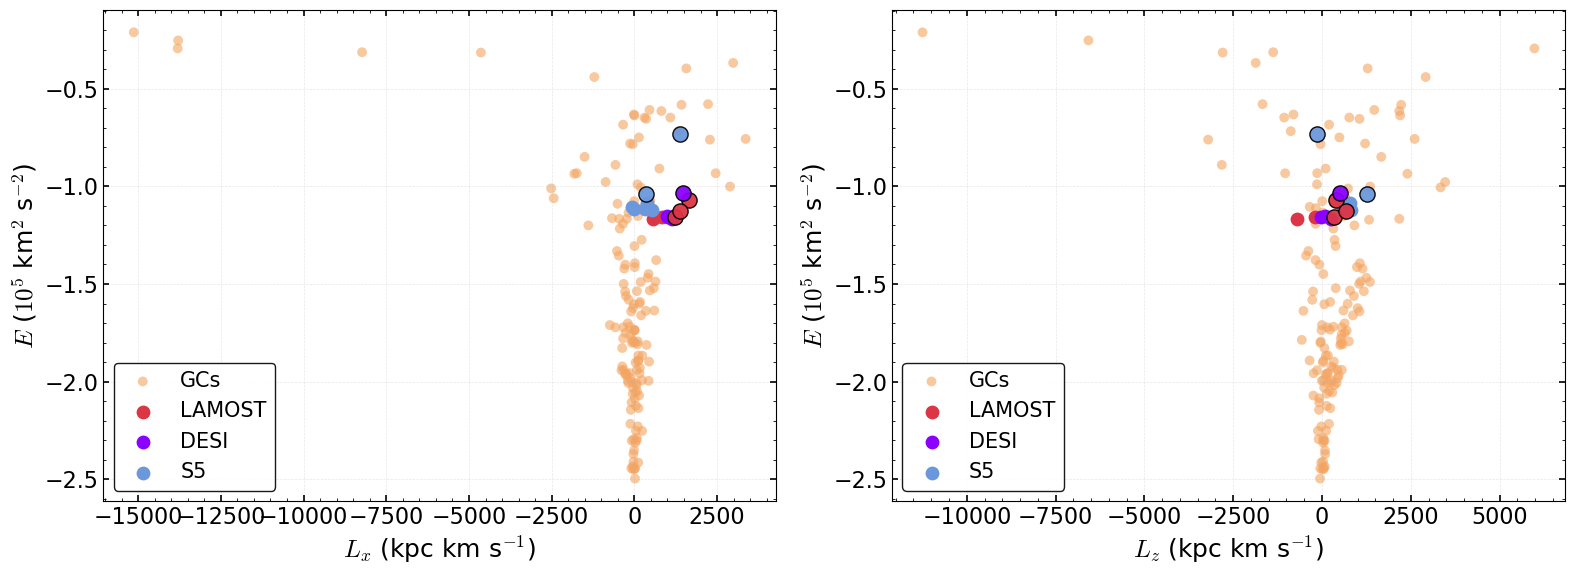

In [489]:
# ========== 绘图 ==========
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ========== 左图: Lx - E ==========
# 球状星团（背景）
ax1.scatter(Lx_gc, np.array(E_gc)*1e-5, c='#F4A460', s=50, alpha=0.6, 
            edgecolors='none', label='GCs', zorder=1)

# 三个survey的星（框内的）
# LAMOST
mask_in_L = ~mask_out_L
ax1.scatter(Lx_L[mask_in_L], E_L[mask_in_L]*1e-5, 
           s=80, c='#DC3545', 
           label='LAMOST', zorder=3)

# DESI
mask_in_D = ~mask_out_D
ax1.scatter(Lx_D[mask_in_D], E_D[mask_in_D]*1e-5, 
           s=80, c='#8B00FF', 
           label='DESI', zorder=3)

# S5
mask_in_S = ~mask_out_S
ax1.scatter(Lx_S[mask_in_S], E_S[mask_in_S]*1e-5, 
           s=80, c='#6B98DC',  
           label='S5', zorder=3)

# 框外的星（加黑框）
if np.any(mask_out_L):
    ax1.scatter(Lx_L[mask_out_L], E_L[mask_out_L]*1e-5, 
               s=120, facecolors='#DC3545', edgecolors='black', 
               linewidths=1, alpha=0.95, zorder=5)

if np.any(mask_out_D):
    ax1.scatter(Lx_D[mask_out_D], E_D[mask_out_D]*1e-5, 
               s=120, facecolors='#8B00FF', edgecolors='black', 
               linewidths=1, alpha=0.95, zorder=5)

if np.any(mask_out_S):
    ax1.scatter(Lx_S[mask_out_S], E_S[mask_out_S]*1e-5, 
               s=120, facecolors='#6B98DC', edgecolors='black', 
               linewidths=1, alpha=0.95, zorder=5)

ax1.tick_params(labelsize=16, direction='in', which='both', top=True, right=True)
ax1.legend(fontsize=15, frameon=True, loc='best', framealpha=0.9, edgecolor='black')
ax1.set_xlabel(r'$L_x$ (kpc km s$^{-1}$)', fontsize=18)
ax1.set_ylabel(r'$E$ ($10^5$ km$^2$ s$^{-2}$)', fontsize=18)
ax1.grid(alpha=0.3, linestyle='--', linewidth=0.5)

# ========== 右图: Lz - E ==========
# 球状星团（背景）
ax2.scatter(Lz_gc, np.array(E_gc)*1e-5, c='#F4A460', s=50, alpha=0.6,
            edgecolors='none', label='GCs', zorder=1)

# 三个survey的星（框内的）
# LAMOST
ax2.scatter(Lz_L[mask_in_L], E_L[mask_in_L]*1e-5, 
           s=80, c='#DC3545', 
           label='LAMOST', zorder=3)

# DESI
ax2.scatter(Lz_D[mask_in_D], E_D[mask_in_D]*1e-5, 
           s=80, c='#8B00FF', 
           label='DESI', zorder=3)

# S5
ax2.scatter(Lz_S[mask_in_S], E_S[mask_in_S]*1e-5, 
           s=80, c='#6B98DC',  
           label='S5', zorder=3)

# 框外的星（加黑框）
if np.any(mask_out_L):
    ax2.scatter(Lz_L[mask_out_L], E_L[mask_out_L]*1e-5, 
               s=120, facecolors='#DC3545', edgecolors='black', 
               linewidths=1, alpha=0.95, zorder=5)

if np.any(mask_out_D):
    ax2.scatter(Lz_D[mask_out_D], E_D[mask_out_D]*1e-5, 
               s=120, facecolors='#8B00FF', edgecolors='black', 
               linewidths=1, alpha=0.95, zorder=5)

if np.any(mask_out_S):
    ax2.scatter(Lz_S[mask_out_S], E_S[mask_out_S]*1e-5, 
               s=120, facecolors='#6B98DC', edgecolors='black', 
               linewidths=1, alpha=0.95, zorder=5)

ax2.tick_params(labelsize=16, direction='in', which='both', top=True, right=True)
ax2.legend(fontsize=15, frameon=True, loc='best', framealpha=0.9, edgecolor='black')
ax2.set_xlabel(r'$L_z$ (kpc km s$^{-1}$)', fontsize=18)
ax2.set_ylabel(r'$E$ ($10^5$ km$^2$ s$^{-2}$)', fontsize=18)
ax2.grid(alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
#plt.savefig("./stream/S2808stream/plot/LE.png", dpi=200, bbox_inches='tight')
plt.show()

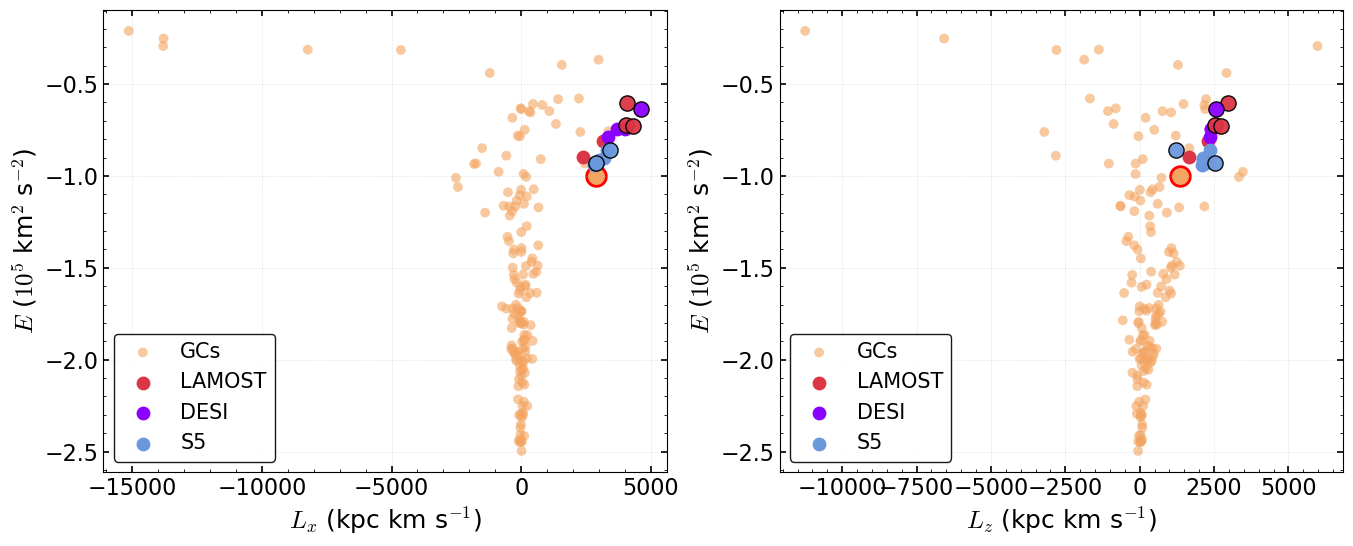

In [404]:
# ========== 绘图 ==========
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ========== 左图: Lx - E ==========
# 球状星团（背景）
ax1.scatter(Lx_gc, np.array(E_gc)*1e-5, c='#F4A460', s=50, alpha=0.6, 
            edgecolors='none', label='GCs', zorder=1)
ax1.scatter(Lx_gc[35], np.array(E_gc[35])*1e-5, c='#F4A460', s=200, 
            edgecolors='red', linewidths=2)


# 三个survey的星（框内的）
# LAMOST
mask_in_L = ~mask_out_L
ax1.scatter(Lx_L[mask_in_L], E_L[mask_in_L]*1e-5, 
           s=80, c='#DC3545', 
           label='LAMOST', zorder=3)

# DESI
mask_in_D = ~mask_out_D
ax1.scatter(Lx_D[mask_in_D], E_D[mask_in_D]*1e-5, 
           s=80, c='#8B00FF', 
           label='DESI', zorder=3)

# S5
mask_in_S = ~mask_out_S
ax1.scatter(Lx_S[mask_in_S], E_S[mask_in_S]*1e-5, 
           s=80, c='#6B98DC',  
           label='S5', zorder=3)

# 框外的星（加黑框）
if np.any(mask_out_L):
    ax1.scatter(Lx_L[mask_out_L], E_L[mask_out_L]*1e-5, 
               s=120, facecolors='#DC3545', edgecolors='black', 
               linewidths=1, alpha=0.95, zorder=5)

if np.any(mask_out_D):
    ax1.scatter(Lx_D[mask_out_D], E_D[mask_out_D]*1e-5, 
               s=120, facecolors='#8B00FF', edgecolors='black', 
               linewidths=1, alpha=0.95, zorder=5)

if np.any(mask_out_S):
    ax1.scatter(Lx_S[mask_out_S], E_S[mask_out_S]*1e-5, 
               s=120, facecolors='#6B98DC', edgecolors='black', 
               linewidths=1, alpha=0.95, zorder=5)

ax1.tick_params(labelsize=16, direction='in', which='both', top=True, right=True)
ax1.legend(fontsize=15, frameon=True, loc='best', framealpha=0.9, edgecolor='black')
ax1.set_xlabel(r'$L_x$ (kpc km s$^{-1}$)', fontsize=18)
ax1.set_ylabel(r'$E$ ($10^5$ km$^2$ s$^{-2}$)', fontsize=18)
ax1.grid(alpha=0.3, linestyle='--', linewidth=0.5)

# ========== 右图: Lz - E ==========
# 球状星团（背景）
ax2.scatter(Lz_gc, np.array(E_gc)*1e-5, c='#F4A460', s=50, alpha=0.6,
            edgecolors='none', label='GCs', zorder=1)
ax2.scatter(Lz_gc[35], np.array(E_gc[35])*1e-5, c='#F4A460', s=200, 
            edgecolors='red', linewidths=2)

# 三个survey的星（框内的）
# LAMOST
ax2.scatter(Lz_L[mask_in_L], E_L[mask_in_L]*1e-5, 
           s=80, c='#DC3545', 
           label='LAMOST', zorder=3)

# DESI
ax2.scatter(Lz_D[mask_in_D], E_D[mask_in_D]*1e-5, 
           s=80, c='#8B00FF', 
           label='DESI', zorder=3)

# S5
ax2.scatter(Lz_S[mask_in_S], E_S[mask_in_S]*1e-5, 
           s=80, c='#6B98DC',  
           label='S5', zorder=3)

# 框外的星（加黑框）
if np.any(mask_out_L):
    ax2.scatter(Lz_L[mask_out_L], E_L[mask_out_L]*1e-5, 
               s=120, facecolors='#DC3545', edgecolors='black', 
               linewidths=1, alpha=0.95, zorder=5)

if np.any(mask_out_D):
    ax2.scatter(Lz_D[mask_out_D], E_D[mask_out_D]*1e-5, 
               s=120, facecolors='#8B00FF', edgecolors='black', 
               linewidths=1, alpha=0.95, zorder=5)

if np.any(mask_out_S):
    ax2.scatter(Lz_S[mask_out_S], E_S[mask_out_S]*1e-5, 
               s=120, facecolors='#6B98DC', edgecolors='black', 
               linewidths=1, alpha=0.95, zorder=5)

ax2.tick_params(labelsize=16, direction='in', which='both', top=True, right=True)
ax2.legend(fontsize=15, frameon=True, loc='best', framealpha=0.9, edgecolor='black')
ax2.set_xlabel(r'$L_z$ (kpc km s$^{-1}$)', fontsize=18)
ax2.set_ylabel(r'$E$ ($10^5$ km$^2$ s$^{-2}$)', fontsize=18)
ax2.grid(alpha=0.3, linestyle='--', linewidth=0.5)

plt.show()

In [369]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis

# ============================================================
# 判据1: 轨道参数匹配（最重要）
# ============================================================

def calculate_orbital_similarity(Lx_gc, Ly_gc, Lz_gc, E_gc,
                                 Lx_stream, Ly_stream, Lz_stream, E_stream):
    """
    计算球状星团与星流的轨道相似度
    返回：归一化距离（sigma数）
    """
    # 计算星流的均值和协方差矩阵
    stream_data = np.column_stack([Lx_stream, Ly_stream, Lz_stream, E_stream*1e-5])
    
    mean_stream = np.mean(stream_data, axis=0)
    cov_stream = np.cov(stream_data.T)
    
    # 计算马氏距离
    distances = []
    for i in range(len(Lx_gc)):
        gc_point = np.array([Lx_gc[i], Ly_gc[i], Lz_gc[i], E_gc[i]])
        try:
            dist = mahalanobis(gc_point, mean_stream, np.linalg.inv(cov_stream))
            distances.append(dist)
        except:
            distances.append(np.inf)
    
    return np.array(distances)

# 计算所有球状星团的轨道距离
Lx_stream_all = np.concatenate([Lx_L[mask_in_L], Lx_D[mask_in_D], Lx_S[mask_in_S]])
Ly_stream_all = np.concatenate([Ly_L[mask_in_L], Ly_D[mask_in_D], Ly_S[mask_in_S]])
Lz_stream_all = np.concatenate([Lz_L[mask_in_L], Lz_D[mask_in_D], Lz_S[mask_in_S]])
E_stream_all = np.concatenate([E_L[mask_in_L], E_D[mask_in_D], E_S[mask_in_S]])

orbital_distances = calculate_orbital_similarity(
    Lx_gc, Ly_gc, Lz_gc, E_gc,
    Lx_stream_all, Ly_stream_all, Lz_stream_all, E_stream_all
)

print(min(orbital_distances))

913422.5811770596


In [374]:
# ========== 只使用角动量 (Lx, Ly, Lz) ==========
print("\n" + "="*70)
print("Angular Momentum Only Analysis")
print("="*70)

# 1. 计算星流的角动量统计
Lx_mean = np.mean(Lx_stream_all)
Ly_mean = np.mean(Ly_stream_all)
Lz_mean = np.mean(Lz_stream_all)

Lx_std = np.std(Lx_stream_all)
Ly_std = np.std(Ly_stream_all)
Lz_std = np.std(Lz_stream_all)

# 总角动量
L_total_stream = np.sqrt(Lx_mean**2 + Ly_mean**2 + Lz_mean**2)

print(f"\nStream Angular Momentum:")
print(f"  <Lx> = {Lx_mean:.1f} ± {Lx_std:.1f} kpc km/s")
print(f"  <Ly> = {Ly_mean:.1f} ± {Ly_std:.1f} kpc km/s")
print(f"  <Lz> = {Lz_mean:.1f} ± {Lz_std:.1f} kpc km/s")
print(f"  |L|  = {L_total_stream:.1f} kpc km/s")

# 2. 计算每个球状星团的角动量距离
def angular_momentum_distance(Lx_gc, Ly_gc, Lz_gc,
                              Lx_s, Ly_s, Lz_s,
                              std_Lx, std_Ly, std_Lz):
    """
    只基于角动量的归一化欧氏距离
    """
    d_Lx = (Lx_gc - Lx_s) / std_Lx
    d_Ly = (Ly_gc - Ly_s) / std_Ly
    d_Lz = (Lz_gc - Lz_s) / std_Lz
    
    dist = np.sqrt(d_Lx**2 + d_Ly**2 + d_Lz**2)
    return dist

L_distances = []

for i in range(len(Lx_gc)):
    dist = angular_momentum_distance(
        Lx_gc[i], Ly_gc[i], Lz_gc[i],
        Lx_mean, Ly_mean, Lz_mean,
        Lx_std, Ly_std, Lz_std
    )
    L_distances.append(dist)

L_distances = np.array(L_distances)

print(f"\nAngular Momentum Distance Statistics:")
print(f"  Min:    {np.min(L_distances):.2f} σ")
print(f"  Max:    {np.max(L_distances):.2f} σ")
print(f"  Median: {np.median(L_distances):.2f} σ")
print(f"  <10σ:   {np.sum(L_distances < 10)} GCs")
print(f"  <5σ:    {np.sum(L_distances < 5)} GCs")
print(f"  <3σ:    {np.sum(L_distances < 3)} GCs")

# 3. 找候选者
print("\n" + "="*70)
print("Progenitor Candidates (Angular Momentum Only)")
print("="*70)

threshold_L = 5.0
candidates_L_idx = np.where(L_distances < threshold_L)[0]

if len(candidates_L_idx) > 0:
    sorted_L_idx = candidates_L_idx[np.argsort(L_distances[candidates_L_idx])]
    
    print(f"\n✅ Found {len(candidates_L_idx)} candidates with L-distance < {threshold_L}σ:\n")
    
    for rank, idx in enumerate(sorted_L_idx, 1):
        L_total_gc = np.sqrt(Lx_gc[idx]**2 + Ly_gc[idx]**2 + Lz_gc[idx]**2)
        
        print(f"{rank}. {name_gc[idx].strip()}")
        print(f"   L-distance: {L_distances[idx]:.2f} σ")
        print(f"   Lx: {Lx_gc[idx]:7.1f}  (stream: {Lx_mean:7.1f}, Δ={(Lx_gc[idx]-Lx_mean)/Lx_std:+.2f}σ)")
        print(f"   Ly: {Ly_gc[idx]:7.1f}  (stream: {Ly_mean:7.1f}, Δ={(Ly_gc[idx]-Ly_mean)/Ly_std:+.2f}σ)")
        print(f"   Lz: {Lz_gc[idx]:7.1f}  (stream: {Lz_mean:7.1f}, Δ={(Lz_gc[idx]-Lz_mean)/Lz_std:+.2f}σ)")
        print(f"   |L|: {L_total_gc:.1f}  (stream: {L_total_stream:.1f})")
        print(f"   E:  {E_gc[idx]:.0f} km²/s²  (stream: {mean_stream_fixed[3]:.0f})")


Angular Momentum Only Analysis

Stream Angular Momentum:
  <Lx> = 3168.3 ± 440.7 kpc km/s
  <Ly> = -891.4 ± 234.7 kpc km/s
  <Lz> = 2205.2 ± 212.8 kpc km/s
  |L|  = 3961.8 kpc km/s

Angular Momentum Distance Statistics:
  Min:    5.68 σ
  Max:    85.14 σ
  Median: 12.97 σ
  <10σ:   14 GCs
  <5σ:    0 GCs
  <3σ:    0 GCs

Progenitor Candidates (Angular Momentum Only)


Closest 10 GCs:

1. NGC 5824
   Distance: 5.84 σ
   Lx:  3362.7, Ly: -2144.9, Lz:  2608.0
   E:  -75670 km²/s²
   Position: d=32.1 kpc, RA=226.0°, Dec=-33.1°

2. Pal 5
   Distance: 8.31 σ
   Lx:  2890.7, Ly:   741.3, Lz:  1353.2
   E:  -100080 km²/s²
   Position: d=23.2 kpc, RA=229.0°, Dec=-0.1°

3. Djorg 1
   Distance: 8.34 σ
   Lx:     0.0, Ly:  -189.5, Lz:  2200.3
   E:  -63639 km²/s²
   Position: d=0.0 kpc, RA=266.9°, Dec=-33.1°

4. NGC 6426
   Distance: 8.86 σ
   Lx:   668.1, Ly:  -162.7, Lz:  1324.6
   E:  -117107 km²/s²
   Position: d=20.6 kpc, RA=266.2°, Dec=3.2°

5. Pal 14
   Distance: 9.22 σ
   Lx:  1568.2, Ly:   -42.9, Lz:  1286.2
   E:  -39561 km²/s²
   Position: d=76.5 kpc, RA=242.8°, Dec=15.0°

6. E 3
   Distance: 9.38 σ
   Lx:  -458.6, Ly: -1159.8, Lz:  2176.1
   E:  -116607 km²/s²
   Position: d=8.1 kpc, RA=140.2°, Dec=-77.3°

7. BH 176
   Distance: 10.27 σ
   Lx:   194.0, Ly:   330.8, Lz:  3337.6
   E:  -100520 km²/s²
   Position: d=18.9 kpc, RA=234.8°, Dec=-50.1°

8. NGC 6934
   Distance: 10.72 σ
   Lx:  -130.0, Ly:   517.4, Lz:  1212.7
   E:  -78057 km²/s²
   Position: d=15.6 kpc, RA=308.5°, Dec=7.4°

9. NGC 6584
   Distance: 11.09 σ
   Lx:   105.5, Ly:  -687.2, Lz:   604.0
   E:  -115192 km²/s²
   Position: d=13.5 kpc, RA=274.7°, Dec=-52.2°

10. NGC 104
   Distance: 11.60 σ
   Lx:   403.1, Ly:  -535.5, Lz:  1251.7
   E:  -146796 km²/s²
   Position: d=4.5 kpc, RA=6.0°, Dec=-72.1°

In [344]:
alphaM_L = data_L["alpha_M"]
alphaM_S = data_S["alpha_mean"]
alphaM_D = data_D["ALPHAFE"]

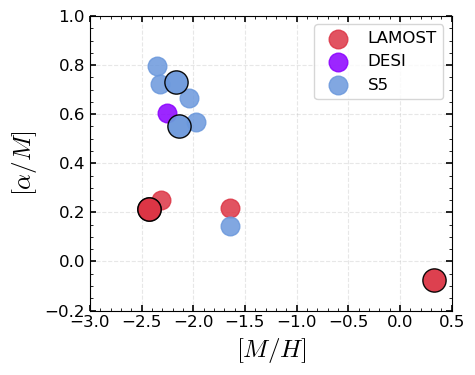

In [526]:
# ========== 创建图形 ==========
fig, ax = plt.subplots(figsize=(5,4))

# ========== 绘制框内的成员星 ==========
# LAMOST
if np.any(mask_in_L):
    ax.scatter(MH_L[mask_in_L], alphaM_L[mask_in_L],
              s=180, c='#DC3545', alpha=0.85,
              label='LAMOST', zorder=3)

# DESI
if np.any(mask_in_D):
    ax.scatter(MH_D[mask_in_D], alphaM_D[mask_in_D],
              s=180, c='#8B00FF', alpha=0.85,
              label='DESI', zorder=3)

# S5
if np.any(mask_in_S):
    ax.scatter(MH_S[mask_in_S], alphaM_S[mask_in_S],
              s=180, c='#6B98DC', alpha=0.85,
              label='S5', zorder=3)

# ========== 绘制框外的星（黑色粗边框）==========
if np.any(mask_out_L):
    ax.scatter(MH_L[mask_out_L], alphaM_L[mask_out_L],
              s=280, facecolors='#DC3545', edgecolors='black',
              linewidths=1, alpha=0.95, zorder=5)

if np.any(mask_out_D):
    ax.scatter(MH_D[mask_out_D], alphaM_D[mask_out_D],
              s=280, facecolors='#8B00FF', edgecolors='black',
              linewidths=1, alpha=0.95, zorder=5)

if np.any(mask_out_S):
    ax.scatter(MH_S[mask_out_S], alphaM_S[mask_out_S],
              s=280, facecolors='#6B98DC', edgecolors='black',
              linewidths=1, alpha=0.95, zorder=5)

# ========== 图设置 ==========
ax.set_xlabel(r'$[M/H]$', fontsize=18)
ax.set_ylabel(r'$[\alpha/M]$', fontsize=18)
ax.tick_params(labelsize=12, direction='in', which='both')
ax.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax.legend(fontsize=12, loc='upper right')
ax.set_xlim(-3.0, 0.5)
ax.set_ylim(-0.2, 1)

# 统计信息
MH_all_in = np.concatenate([MH_L[mask_in_L], MH_D[mask_in_D], MH_S[mask_in_S]])
alpha_all_in = np.concatenate([alphaM_L[mask_in_L], alphaM_D[mask_in_D], alphaM_S[mask_in_S]])

plt.tight_layout()
plt.savefig("./stream/S2808stream/plot/MH_alpha.png", dpi=200, bbox_inches='tight')
plt.show()

In [378]:
ra_all = np.concatenate([ra_L[mask_in_L], ra_D[mask_in_D], ra_S[mask_in_S]])
dec_all = np.concatenate([dec_L[mask_in_L], dec_D[mask_in_D], dec_S[mask_in_S]])
pmra_all = np.concatenate([pmra_L[mask_in_L], pmra_D[mask_in_D], pmra_S[mask_in_S]])
pmdec_all = np.concatenate([pmdec_L[mask_in_L], pmdec_D[mask_in_D], pmdec_S[mask_in_S]])
RV_all = np.concatenate([RV_L[mask_in_L], RV_D[mask_in_D], RV_S[mask_in_S]])

In [379]:
import numpy as np
from galpy.potential import MWPotential2014
from galpy.orbit import Orbit
import astropy.units as u

dist_all = 14.25607593602188

# 假设您已经有了 Galactocentric 坐标和速度
# x, y, z: Galactocentric positions (kpc)
# vx, vy, vz: Galactocentric velocities (km/s)
def xyzcal(ra,dec,dist,pmra,pmdec,rv):
    c1 = SkyCoord(ra, dec, unit="deg")
    ra_s0=c1.ra.deg
    dec_s0=c1.dec.deg
    vr_s0=rv
    dist=dist
    pmra_s0=pmra
    pmdec_s0=pmdec
    lb_s0=gub.radec_to_lb(ra_s0,dec_s0,degree=True)
    xyz_s0=gub.lbd_to_XYZ(lb_s0[0],lb_s0[1],dist,degree=True)
    pmlb_s0=gub.pmrapmdec_to_pmllpmbb(pmra_s0,pmdec_s0,ra_s0,dec_s0,degree=True)
    vxyz_s0=gub.vrpmllpmbb_to_vxvyvz(vr_s0,pmlb_s0[0],pmlb_s0[1],lb_s0[0],lb_s0[1],dist,degree=True)
    x_s0=x_sun-xyz_s0[0]
    y_s0=xyz_s0[1]
    z_s0=xyz_s0[2]
    vx_s0=(u_sun+vxyz_s0[0])*(-1.)
    vy_s0=(vxyz_s0[1]+v_sun+v_lsr)
    vz_s0=(vxyz_s0[2]+w_sun)
    return x_s0, y_s0, z_s0, vx_s0, vy_s0, vz_s0

x_sur=[]
y_sur=[]
z_sur=[]
vx_sur=[]
vy_sur=[]
vz_sur=[]
for i in range(len(ra_all)):
    x_swr, y_swr, z_swr, vx_swr, vy_swr, vz_swr = xyzcal(ra_all[i],dec_all[i],14.25607593602188,pmra_all[i],pmdec_all[i],RV_all[i])
    x_sur.append(x_swr)
    y_sur.append(y_swr)
    z_sur.append(z_swr)
    vx_sur.append(vx_swr)
    vy_sur.append(vy_swr)
    vz_sur.append(vz_swr)
    

eccentricities = []
r_apos = []
r_peris = []

for i in range(len(x_sur)):
    # 创建 Orbit 对象
    # [R, vR, vT, z, vz, phi]
    # 其中 R = sqrt(x^2 + y^2), vR 是径向速度, vT 是切向速度
    
    R = np.sqrt(x_sur[i]**2 + y_sur[i]**2)
    phi = np.arctan2(y_sur[i], x_sur[i])
    
    # 计算径向和切向速度
    vR = (x_sur[i]*vx_sur[i] + y_sur[i]*vy_sur[i]) / R
    vT = (x_sur[i]*vy_sur[i] - y_sur[i]*vx_sur[i]) / R
    
    # 创建轨道 (单位需要正确)
    o = Orbit([R*u.kpc, vR*u.km/u.s, vT*u.km/u.s, 
               z_sur[i]*u.kpc, vz_sur[i]*u.km/u.s, phi*u.rad],
              ro=8.0, vo=220.0)  # Solar position and velocity
    
    # 积分轨道 (前后各 5 Gyr)
    ts = np.linspace(0, 5, 1000) * u.Gyr
    o.integrate(ts, MWPotential2014)
    
    # 计算远心点和近心点距离
    r_apo = o.rap(analytic=False, pot=MWPotential2014)
    r_peri = o.rperi(analytic=False, pot=MWPotential2014)
    
    # 计算偏心率
    e = (r_apo - r_peri) / (r_apo + r_peri)
    
    eccentricities.append(e)
    r_apos.append(r_apo)
    r_peris.append(r_peri)
    
    print(f"Star {i}: e={e:.3f}, r_apo={r_apo:.2f} kpc, r_peri={r_peri:.2f} kpc")

eccentricities = np.array(eccentricities)
r_apos = np.array(r_apos)
r_peris = np.array(r_peris)

print(f"\nMedian eccentricity: {np.median(eccentricities):.3f}")
print(f"Eccentricity range: [{np.min(eccentricities):.3f}, {np.max(eccentricities):.3f}]")
print(f"Mean apocenter: {np.mean(r_apos):.2f} kpc")
print(f"Mean pericenter: {np.mean(r_peris):.2f} kpc")

Star 0: e=0.576, r_apo=47.05 kpc, r_peri=12.68 kpc
Star 1: e=0.601, r_apo=36.13 kpc, r_peri=9.00 kpc
Star 2: e=0.606, r_apo=60.77 kpc, r_peri=14.89 kpc
Star 3: e=0.588, r_apo=51.25 kpc, r_peri=13.28 kpc
Star 4: e=0.632, r_apo=61.55 kpc, r_peri=13.88 kpc
Star 5: e=0.453, r_apo=34.04 kpc, r_peri=12.82 kpc
Star 6: e=0.398, r_apo=30.68 kpc, r_peri=13.21 kpc
Star 7: e=0.393, r_apo=29.68 kpc, r_peri=12.94 kpc
Star 8: e=0.421, r_apo=34.24 kpc, r_peri=13.94 kpc
Star 9: e=0.463, r_apo=39.99 kpc, r_peri=14.69 kpc

Median eccentricity: 0.519
Eccentricity range: [0.393, 0.632]
Mean apocenter: 42.54 kpc
Mean pericenter: 13.13 kpc


In [384]:
import numpy as np
from galpy.potential import NFWPotential, MiyamotoNagaiPotential, HernquistPotential
from galpy.orbit import Orbit
import astropy.units as u
from astropy.coordinates import SkyCoord
import galpy.util.coords as gub

dist_all = 14.25607593602188

# ============ 定义自定义银河系势能 ============
Msun = 1.9884e30
Mhalo = 1.25e12 * Msun
Mdisk = 0.065 * Mhalo
Mbulge = 0.01 * Mhalo

# 构建自定义势能
# Option 1: Use mvir parameter with conc (recommended when using conc)
halo = NFWPotential(conc=10., mvir=1.25, ro=8.0, vo=220.0)  # mvir in units of 1e12 Msun

# Option 2: Alternative - use amp without conc
# halo = NFWPotential(amp=1.25, a=20.0, ro=8.0, vo=220.0)  # a is scale radius in kpc

disk = MiyamotoNagaiPotential(amp=Mdisk/(1e12*Msun), a=3.0, b=0.28, ro=8.0, vo=220.0)
bulge = HernquistPotential(amp=Mbulge/(1e12*Msun), a=0.6, ro=8.0, vo=220.0)
MyPotential = [halo, disk, bulge]

# ============ 坐标转换函数 ============
def xyzcal(ra, dec, dist, pmra, pmdec, rv):
    c1 = SkyCoord(ra, dec, unit="deg")
    ra_s0 = c1.ra.deg
    dec_s0 = c1.dec.deg
    vr_s0 = rv
    dist = dist
    pmra_s0 = pmra
    pmdec_s0 = pmdec
    
    lb_s0 = gub.radec_to_lb(ra_s0, dec_s0, degree=True)
    xyz_s0 = gub.lbd_to_XYZ(lb_s0[0], lb_s0[1], dist, degree=True)
    pmlb_s0 = gub.pmrapmdec_to_pmllpmbb(pmra_s0, pmdec_s0, ra_s0, dec_s0, degree=True)
    vxyz_s0 = gub.vrpmllpmbb_to_vxvyvz(vr_s0, pmlb_s0[0], pmlb_s0[1], lb_s0[0], lb_s0[1], dist, degree=True)
    
    x_s0 = x_sun - xyz_s0[0]
    y_s0 = xyz_s0[1]
    z_s0 = xyz_s0[2]
    vx_s0 = (u_sun + vxyz_s0[0]) * (-1.)
    vy_s0 = (vxyz_s0[1] + v_sun + v_lsr)
    vz_s0 = (vxyz_s0[2] + w_sun)
    
    return x_s0, y_s0, z_s0, vx_s0, vy_s0, vz_s0

# ============ 坐标转换参数 ============
x_sun = 8.0   # 太阳距离银心的距离 (kpc)
u_sun = 10.0  # 太阳相对于银心的径向速度 (km/s)
v_sun = 10.0  # 太阳相对于银心的切向速度 (km/s)
v_lsr = 5.0   # 本地标准静止速度修正 (km/s)
w_sun = 7.0   # 太阳垂直于银盘的速度 (km/s)

# ============ 计算轨道参数 ============
# 假设 ra_all, dec_all, pmra_all, pmdec_all, RV_all 已定义
# 这里仅作示例，需要替换为实际数据

x_sur = []
y_sur = []
z_sur = []
vx_sur = []
vy_sur = []
vz_sur = []

for i in range(len(ra_all)):
    x_swr, y_swr, z_swr, vx_swr, vy_swr, vz_swr = xyzcal(
        ra_all[i], dec_all[i], 14.25607593602188,
        pmra_all[i], pmdec_all[i], RV_all[i]
    )
    x_sur.append(x_swr)
    y_sur.append(y_swr)
    z_sur.append(z_swr)
    vx_sur.append(vx_swr)
    vy_sur.append(vy_swr)
    vz_sur.append(vz_swr)

eccentricities = []
r_apos = []
r_peris = []

for i in range(len(x_sur)):
    # 创建 Orbit 对象
    # [R, vR, vT, z, vz, phi]
    R = np.sqrt(x_sur[i]**2 + y_sur[i]**2)
    phi = np.arctan2(y_sur[i], x_sur[i])
    
    # 计算径向和切向速度
    vR = (x_sur[i]*vx_sur[i] + y_sur[i]*vy_sur[i]) / R
    vT = (x_sur[i]*vy_sur[i] - y_sur[i]*vx_sur[i]) / R
    
    # 创建轨道
    o = Orbit([R*u.kpc, vR*u.km/u.s, vT*u.km/u.s,
               z_sur[i]*u.kpc, vz_sur[i]*u.km/u.s, phi*u.rad],
              ro=8.0, vo=220.0)
    
    # 积分轨道 (前后各 5 Gyr)
    ts = np.linspace(0, 5, 1000) * u.Gyr
    o.integrate(ts, MyPotential)  # 使用自定义势能
    
    # 计算远心点和近心点距离
    r_apo = o.rap(analytic=False, pot=MyPotential)   # 使用自定义势能
    r_peri = o.rperi(analytic=False, pot=MyPotential) # 使用自定义势能
    
    # 计算偏心率
    e = (r_apo - r_peri) / (r_apo + r_peri)
    
    eccentricities.append(e)
    r_apos.append(r_apo)
    r_peris.append(r_peri)
    
    print(f"Star {i}: e={e:.3f}, r_apo={r_apo:.2f} kpc, r_peri={r_peri:.2f} kpc")

eccentricities = np.array(eccentricities)
r_apos = np.array(r_apos)
r_peris = np.array(r_peris)

print(f"\nMedian eccentricity: {np.median(eccentricities):.3f}")
print(f"Eccentricity range: [{np.min(eccentricities):.3f}, {np.max(eccentricities):.3f}]")
print(f"Mean apocenter: {np.mean(r_apos):.2f} kpc")
print(f"Mean pericenter: {np.mean(r_peris):.2f} kpc")

Star 0: e=0.381, r_apo=18.18 kpc, r_peri=8.15 kpc
Star 1: e=0.382, r_apo=17.61 kpc, r_peri=7.87 kpc
Star 2: e=0.267, r_apo=17.45 kpc, r_peri=10.09 kpc
Star 3: e=0.316, r_apo=17.83 kpc, r_peri=9.27 kpc
Star 4: e=0.359, r_apo=19.12 kpc, r_peri=9.02 kpc
Star 5: e=0.538, r_apo=15.74 kpc, r_peri=4.72 kpc
Star 6: e=0.475, r_apo=15.98 kpc, r_peri=5.68 kpc
Star 7: e=0.573, r_apo=15.96 kpc, r_peri=4.33 kpc
Star 8: e=0.552, r_apo=15.96 kpc, r_peri=4.61 kpc
Star 9: e=0.336, r_apo=16.26 kpc, r_peri=8.09 kpc

Median eccentricity: 0.381
Eccentricity range: [0.267, 0.573]
Mean apocenter: 17.01 kpc
Mean pericenter: 7.18 kpc



Integrating orbits with custom potential...
  Progress: 1/10
  Progress: 3/10
  Progress: 5/10
  Progress: 7/10
  Progress: 9/10
✅ Orbit integration complete!

Plotting orbits...
Pal 5 Galactic coordinates: l=0.85°, b=45.86°


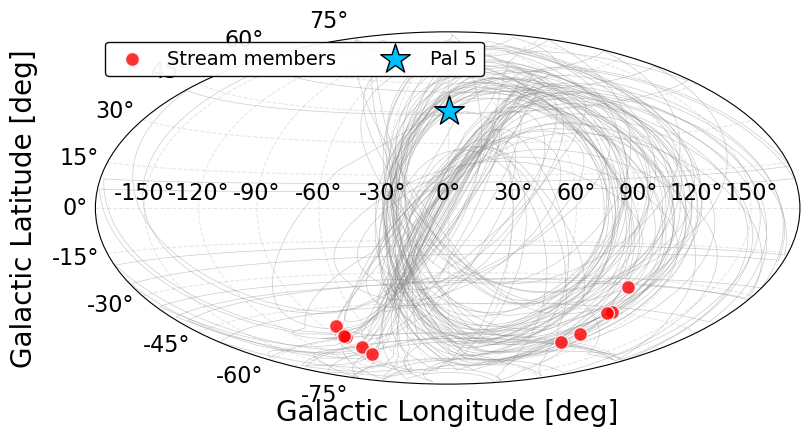


Orbital Statistics

【Orbital Parameters】
  Eccentricity:  0.381 (range: [0.267, 0.573])
  Apocenter:     16.86 kpc (range: [15.74, 19.12] kpc)
  Pericenter:    7.98 kpc (range: [4.33, 10.09] kpc)

【Orbital Normal Direction】
  <L_longitude>: -62.8° ± 16.7°
  <L_latitude>:  13.4° ± 22.1°


In [396]:
import numpy as np
import matplotlib.pyplot as plt
from galpy.orbit import Orbit
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactic

# ============================================================
# 1. 积分所有星流成员的轨道
# ============================================================

print("\n" + "="*70)
print("Integrating orbits with custom potential...")
print("="*70)

def integrate_orbit_custom(x, y, z, vx, vy, vz, pot, tmax=3.0, nsteps=300):
    """
    积分轨道并返回天球坐标和轨道法向量
    """
    R = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    
    vR = (x*vx + y*vy) / R
    vT = (x*vy - y*vx) / R
    
    o = Orbit([R*u.kpc, vR*u.km/u.s, vT*u.km/u.s,
              z*u.kpc, vz*u.km/u.s, phi*u.rad],
             ro=8.0, vo=220.0)
    
    # 前向和后向积分
    ts_forward = np.linspace(0, tmax, nsteps) * u.Gyr
    ts_backward = np.linspace(0, -tmax, nsteps) * u.Gyr
    
    o.integrate(ts_forward, pot)
    X_f = o.x(ts_forward)
    Y_f = o.y(ts_forward)
    Z_f = o.z(ts_forward)
    
    o_back = Orbit([R*u.kpc, vR*u.km/u.s, vT*u.km/u.s,
                   z*u.kpc, vz*u.km/u.s, phi*u.rad],
                  ro=8.0, vo=220.0)
    o_back.integrate(ts_backward, pot)
    X_b = o_back.x(ts_backward)
    Y_b = o_back.y(ts_backward)
    Z_b = o_back.z(ts_backward)
    
    # 合并轨迹（后向 + 前向）
    X_orbit = np.concatenate([X_b[::-1], X_f])
    Y_orbit = np.concatenate([Y_b[::-1], Y_f])
    Z_orbit = np.concatenate([Z_b[::-1], Z_f])
    
    # 转换到日心坐标系（太阳在 (8, 0, 0)）
    X_helio = 8.0 - X_orbit
    Y_helio = Y_orbit
    Z_helio = Z_orbit
    
    # 转换到天球坐标（银道坐标）
    R_helio = np.sqrt(X_helio**2 + Y_helio**2 + Z_helio**2)
    l_orbit = np.degrees(np.arctan2(Y_helio, X_helio))
    b_orbit = np.degrees(np.arcsin(Z_helio / (R_helio + 1e-10)))
    
    # 计算轨道法向量（角动量方向）
    r_vec = np.array([x, y, z])
    v_vec = np.array([vx, vy, vz])
    L_vec = np.cross(r_vec, v_vec)
    
    if np.linalg.norm(L_vec) > 0:
        L_norm = L_vec / np.linalg.norm(L_vec)
        Lx, Ly, Lz = L_norm
        L_longitude = np.degrees(np.arctan2(Ly, Lx))
        L_latitude = np.degrees(np.arcsin(np.clip(Lz, -1, 1)))
    else:
        L_longitude = np.nan
        L_latitude = np.nan
    
    return l_orbit, b_orbit, L_longitude, L_latitude

# 积分所有星流成员的轨道
stream_orbits = []
L_longitudes = []
L_latitudes = []

for i in range(len(x_sur)):
    if i % 2 == 0:
        print(f"  Progress: {i+1}/{len(x_sur)}")
    
    l_orb, b_orb, L_lon, L_lat = integrate_orbit_custom(
        x_sur[i], y_sur[i], z_sur[i],
        vx_sur[i], vy_sur[i], vz_sur[i],
        MyPotential,  # 使用你的自定义势能
        tmax=3.0, nsteps=300
    )
    
    stream_orbits.append((l_orb, b_orb))
    L_longitudes.append(L_lon)
    L_latitudes.append(L_lat)

L_longitudes = np.array(L_longitudes)
L_latitudes = np.array(L_latitudes)

print("✅ Orbit integration complete!")

# ============================================================
# 2. 准备天球位置数据
# ============================================================

# 转换星流成员到银道坐标
stream_coords = SkyCoord(ra=ra_all*u.deg, dec=dec_all*u.deg, frame='icrs')
stream_gal = stream_coords.galactic
l_stream = stream_gal.l.deg
b_stream = stream_gal.b.deg

# 转换球状星团到银道坐标（如果有）
try:
    gc_coords = SkyCoord(ra=ra_gc*u.deg, dec=dec_gc*u.deg, frame='icrs')
    gc_gal = gc_coords.galactic
    l_gc = gc_gal.l.deg
    b_gc = gc_gal.b.deg
    has_gc = True
except:
    has_gc = False
    print("No GC data available")

# ============================================================
# 3. 绘制双面板图
# ============================================================

def wrap_longitude(l):
    """将经度转到[-180, 180]"""
    return np.where(l > 180, l - 360, l)

fig = plt.figure(figsize=(20, 9))

# ========== 左图：天球投影 + 轨道 ==========
ax1 = fig.add_subplot(121, projection='hammer')

# 绘制星流轨道（灰色线）
print("\nPlotting orbits...")
for i, (l_orb, b_orb) in enumerate(stream_orbits):
    l_wrapped = wrap_longitude(l_orb)
    l_rad = np.radians(l_wrapped)
    b_rad = np.radians(b_orb)
    ax1.plot(l_rad, b_rad, '-', color='gray', alpha=0.4, lw=0.5, zorder=1)


# 绘制星流成员（方块，按survey上色）
survey_colors = ['#DC3545', '#8B00FF', '#6B98DC']
survey_names = ['LAMOST', 'DESI', 'S5']
l_stream_wrapped = wrap_longitude(l_stream)

# 在左图上添加星流成员（单色红点）
l_stream_wrapped = wrap_longitude(l_stream)  # 转到[-180, 180]
ax1.scatter(np.radians(l_stream_wrapped), np.radians(b_stream), 
           c='red', s=100, alpha=0.8, 
           edgecolors='white', linewidths=1,
           label='Stream members', zorder=10)


# ========== 在左图上标注 Pal 5 ==========

# 转换Pal 5到银道坐标
pal5_coord = SkyCoord(ra=229.022*u.deg, dec=-0.112*u.deg, frame='icrs')
pal5_gal = pal5_coord.galactic
pal5_l = pal5_gal.l.deg
pal5_b = pal5_gal.b.deg

print(f"Pal 5 Galactic coordinates: l={pal5_l:.2f}°, b={pal5_b:.2f}°")

# 转到[-180, 180]并转弧度
pal5_l_wrapped = wrap_longitude(pal5_l)
pal5_l_rad = np.radians(pal5_l_wrapped)
pal5_b_rad = np.radians(pal5_b)

# 在ax1上画Pal 5（大蓝色五角星，粗黑边）
ax1.scatter(pal5_l_rad, pal5_b_rad,
           s=500, marker='*', c='deepskyblue', alpha=1,
           edgecolors='black', linewidths=1,
           label='Pal 5', zorder=15)


ax1.set_xlabel('Galactic Longitude [deg]', fontsize=20, labelpad=10)
ax1.set_ylabel('Galactic Latitude [deg]', fontsize=20, labelpad=10)
ax1.legend(loc='upper left', fontsize=14, framealpha=0.95, 
          edgecolor='black', ncol=2)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax1.tick_params(labelsize=16)
plt.show()


# ============================================================
# 4. 统计信息
# ============================================================

print("\n" + "="*70)
print("Orbital Statistics")
print("="*70)

print(f"\n【Orbital Parameters】")
print(f"  Eccentricity:  {np.median(eccentricities):.3f} "
      f"(range: [{np.min(eccentricities):.3f}, {np.max(eccentricities):.3f}])")
print(f"  Apocenter:     {np.median(r_apos):.2f} kpc "
      f"(range: [{np.min(r_apos):.2f}, {np.max(r_apos):.2f}] kpc)")
print(f"  Pericenter:    {np.median(r_peris):.2f} kpc "
      f"(range: [{np.min(r_peris):.2f}, {np.max(r_peris):.2f}] kpc)")

mask_valid_L = ~np.isnan(L_longitudes)
print(f"\n【Orbital Normal Direction】")
print(f"  <L_longitude>: {np.mean(L_longitudes[mask_valid_L]):.1f}° "
      f"± {np.std(L_longitudes[mask_valid_L]):.1f}°")
print(f"  <L_latitude>:  {np.mean(L_latitudes[mask_valid_L]):.1f}° "
      f"± {np.std(L_latitudes[mask_valid_L]):.1f}°")

print("="*70)


In [ ]:
llbb_mem = guc.radec_to_lb(ra_all,
                           dec_all,degree=True)

llbb_mem_D = guc.radec_to_lb(ra_D[mask_in_D], dec_D[mask_in_D],degree=True)
llbb_mem_L = guc.radec_to_lb(ra_L[mask_in_L], dec_L[mask_in_L],degree=True)
llbb_mem_S = guc.radec_to_lb(ra_S[mask_in_S], dec_S[mask_in_S],degree=True)

pot_bulge = agama.Potential(type='Dehnen', scaleRadius=1.0, gamma=1.0, mass=2e10)
pot_disk = agama.Potential(type='MiyamotoNagai', scaleRadius=3.0, scaleHeight=0.3, mass=5e10)
pot_halo = agama.Potential(type='NFW', scaleRadius=15.0, mass=mass_nfw*1e11)
pot_total = agama.Potential(pot_bulge, pot_disk, pot_halo)

In [493]:
mass_nfw = 5.5

In [494]:
def calc_actions(ra, dec, dist, pmra, pmdec, RV):
    llbb = guc.radec_to_lb(ra, dec, degree=True)
    xyz = guc.lbd_to_XYZ(llbb[:,0], llbb[:,1],dist,degree=True)
    x_gc = X_Sun - xyz[:,0]
    y_gc = xyz[:,1]
    z_gc = xyz[:,2]
    
    pmllbb = guc.pmrapmdec_to_pmllpmbb(pmra, pmdec, ra, dec,degree=True)
    vxvyvz = guc.vrpmllpmbb_to_vxvyvz(RV, pmllbb[:,0], pmllbb[:,1], llbb[:,0], llbb[:,1], dist, degree=True)
    vx_gc = -1*(vxvyvz[:,0] + U_Sun)
    vy_gc = vxvyvz[:,1] + V_Sun + V_LSR
    vz_gc = vxvyvz[:,2] + W_Sun
    
    agama.setUnits(mass=1, length=1, velocity=1)
    pot_bulge = agama.Potential(type='Dehnen', scaleRadius=1.0, gamma=1.0, mass=2e10)
    pot_disk = agama.Potential(type='MiyamotoNagai', scaleRadius=3.0, scaleHeight=0.3, mass=5e10)
    pot_halo = agama.Potential(type='NFW', scaleRadius=15.0, mass=mass_nfw*1e11)#5.5e11
    pot_total = agama.Potential(pot_bulge, pot_disk, pot_halo)
    
    pos = np.zeros((len(x_gc), 3))
    pos[:,0] = x_gc
    pos[:,1] = y_gc
    pos[:,2] = z_gc
    
    energy = pot_total.potential(pos) + 0.5*np.sqrt(vx_gc**2+vy_gc**2+vz_gc**2)
    sample = np.zeros((len(x_gc), 6))
    sample[:, 0] = x_gc
    sample[:, 1] = y_gc
    sample[:, 2] = z_gc
    sample[:, 3] = vx_gc     #-(vxvyvz[ind, 0][:] + U_Sun)
    sample[:, 4] = vy_gc          # (vxvyvz[ind, 1][:] + V_Sun + V_LSR)
    sample[:, 5] = vz_gc         #(vxvyvz[ind, 2][:] + W_Sun)
    af_fudge = agama.ActionFinder(pot_total, interp=False)
    act_tmp = af_fudge(sample)

    actions = Table()
    actions["JR"] = act_tmp[:, 0]
    actions["JZ"] = act_tmp[:, 1]
    actions["JP"] = act_tmp[:, 2]
    actions["Jtot"] = actions["JR"] + actions["JZ"] + np.abs(actions["JP"])
    actions["E"] = energy
    
    return sample, actions

In [436]:
sample_A, actions_A = calc_actions(ra_all, 
                              dec_all,
                              dist_iso,
                              pmra_all, 
                              pmdec_all,
                              RV_all)

In [414]:
fn_gc = "./stream/S2808stream/GC_PM_catalog_Vasiliev.fits"
dt_gc = fits.open(fn_gc)
data_gc = dt_gc[1].data
ra_gc = data_gc["RAdeg"]
dec_gc = data_gc["DEdeg"]
dist_gc = data_gc["Dist"]
pmra_gc = data_gc["pmRA"]
pmdec_gc = data_gc["pmDE"]
RV_gc = data_gc["HRV"]
llbb_gc = guc.radec_to_lb(ra_gc, dec_gc, degree=True)
xyz_gc = guc.lbd_to_XYZ(llbb_gc[:,0],llbb_gc[:,1],dist_gc,degree=True)

fn_dg = "./stream/S2808stream/dwarfgalaxies_drlica-Wagner2020.fits"
dt_dg = fits.open(fn_dg)
data_dg = dt_dg[1].data
name_dg = np.array(data_dg["name"])
ra_dg = np.array(data_dg["ra"])
dec_dg = np.array(data_dg["dec"])
ID_dg = np.array(data_dg["name"])
dist_dg = np.array(data_dg["dist"])
X_sun_dg = np.array(data_dg["Xkpc"])
Y_sun_dg = np.array(data_dg["Ykpc"])
Z_sun_dg = np.array(data_dg["Zkpc"])
U_sun_dg = np.array(data_dg["Ukms"])
V_sun_dg = np.array(data_dg["Vkms"])
W_sun_dg = np.array(data_dg["Wkms"])
llbb_dg = guc.radec_to_lb(ra_dg, dec_dg, degree=True)
xyz_dg = guc.lbd_to_XYZ(llbb_dg[:,0],llbb_dg[:,1],dist_dg,degree=True)

# calc actions for dwarf galaxies
agama.setUnits(mass=1, length=1, velocity=1)
pot_bulge = agama.Potential(type='Dehnen', scaleRadius=1.0, gamma=1.0, mass=2e10)
pot_disk = agama.Potential(type='MiyamotoNagai', scaleRadius=3.0, scaleHeight=0.3, mass=5e10)
pot_halo = agama.Potential(type='NFW', scaleRadius=15.0, mass=mass_nfw*1e11)
pot_total = agama.Potential(pot_bulge, pot_disk, pot_halo)

pos_dg = np.zeros((len(X_sun_dg), 3))
pos_dg[:,0] = 8.34-X_sun_dg
pos_dg[:,1] = Y_sun_dg
pos_dg[:,2] = Z_sun_dg

sample_dg = np.zeros((len(X_sun_dg), 6))
sample_dg[:, 0] = 8.34-X_sun_dg
sample_dg[:, 1] = Y_sun_dg
sample_dg[:, 2] = Z_sun_dg
sample_dg[:, 3] = -U_sun_dg-U_Sun
sample_dg[:, 4] = V_sun_dg+V_Sun+V_LSR
sample_dg[:, 5] = W_sun_dg+W_Sun
Lx_DG = sample_dg[:,1]*sample_dg[:,5] - sample_dg[:,2]*sample_dg[:,4]
Ly_DG = sample_dg[:,2]*sample_dg[:,3] - sample_dg[:,0]*sample_dg[:,5]
Lz_DG = sample_dg[:,0]*sample_dg[:,4] - sample_dg[:,1]*sample_dg[:,3]
lbd_DG_L = guc.XYZ_to_lbd(Lx_DG, Ly_DG, Lz_DG, degree=True)

af_fudge = agama.ActionFinder(pot_total, interp=False)
act_tmp_dg = af_fudge(sample_dg)
energy_dg = pot_total.potential(pos_dg) + 0.5*np.sqrt(sample_dg[:, 3]**2+sample_dg[:, 4]**2+sample_dg[:, 5]**2)
actions_dg = Table()
actions_dg["JR"] = act_tmp_dg[:, 0]
actions_dg["JZ"] = act_tmp_dg[:, 1]
actions_dg["JP"] = act_tmp_dg[:, 2]
actions_dg["Jtot"] = actions_dg["JR"] + actions_dg["JZ"] + np.abs(actions_dg["JP"])
actions_dg["E"] = energy_dg

In [417]:
POS_VEL_cluster, actions_cluster = calc_actions(ra_gc, dec_gc, dist_gc,pmra_gc, pmdec_gc, RV_gc)
Jtot_cluster = np.abs(actions_cluster["JP"])+actions_cluster["JR"]+actions_cluster["JZ"]
Lx_GC = POS_VEL_cluster[:,1]*POS_VEL_cluster[:,5] - POS_VEL_cluster[:,2]*POS_VEL_cluster[:,4]
Ly_GC = POS_VEL_cluster[:,2]*POS_VEL_cluster[:,3] - POS_VEL_cluster[:,0]*POS_VEL_cluster[:,5]
Lz_GC = POS_VEL_cluster[:,0]*POS_VEL_cluster[:,4] - POS_VEL_cluster[:,1]*POS_VEL_cluster[:,3]
lbd_gc_L = guc.XYZ_to_lbd(Lx_GC, Ly_GC, Lz_GC, degree=True)

In [431]:
sample_D, actions_D = calc_actions(ra_D[mask_in_D], 
                                dec_D[mask_in_D],
                                dist_iso,
                                pmra_D[mask_in_D], 
                                pmdec_D[mask_in_D],
                                RV_D[mask_in_D])

sample_L, actions_L = calc_actions(ra_L[mask_in_L], 
                                dec_L[mask_in_L],
                                dist_iso,
                                pmra_L[mask_in_L], 
                                pmdec_L[mask_in_L],
                                RV_L[mask_in_L])

sample_S, actions_S = calc_actions(ra_S[mask_in_S], 
                                dec_S[mask_in_S],
                                dist_iso,
                                pmra_S[mask_in_S], 
                                pmdec_S[mask_in_S],
                                RV_S[mask_in_S])

In [422]:
ind_Pal5_tmp = (data_gc["Name"]=="Pal 5") #| (data_gc["Name"]=="Pal 4")
print(actions_cluster["JP"][ind_Pal5_tmp].value, actions_cluster["E"][ind_Pal5_tmp].value/1e5)

[1346.21984455] [-1.17436543]


<>:20: SyntaxWarning: invalid escape sequence '\m'

<>:20: SyntaxWarning: invalid escape sequence '\m'

/tmp/ipykernel_160675/4072265242.py:20: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(actions_dg["JP"], actions_dg["E"]/1e5, 'ko',ms=3,color="#FFC107", label="$\mathrm{DG}$",zorder=2)

/tmp/ipykernel_160675/4072265242.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(actions_cluster["JP"], actions_cluster["E"]/1e5, 'ko',ms=3,color="#007BFF", label=r"$\mathrm{GC}$",zorder=2)

/tmp/ipykernel_160675/4072265242.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(actions_cluster["JP"][ind_GC_tmp], actions_cluster["E"][ind_GC_tmp]/1e5, 'ko',ms=10,color="k",zorder=2)

/tmp/ipykernel_160675/4072265242.py:18: UserWarning: color is redundant

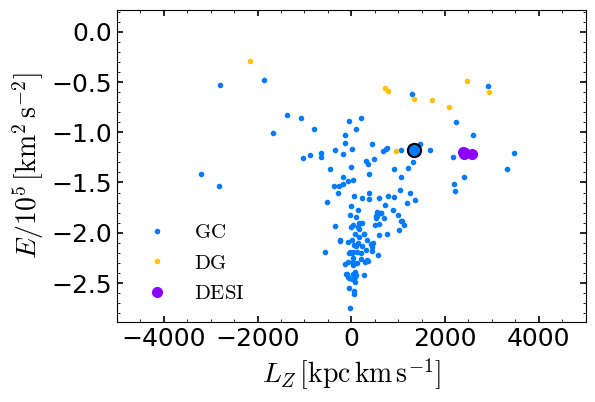

/tmp/ipykernel_160675/4072265242.py:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(Lx_DG, actions_dg["E"]/1e5, 'ko',ms=3,color="#FFC107", label=r"$\mathrm{DG}$",zorder=2)



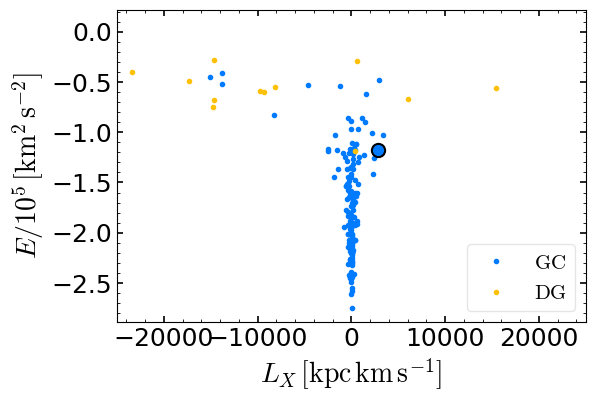

/tmp/ipykernel_160675/4072265242.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(Lz_GC, np.sqrt(Lx_GC**2+Ly_GC**2), 'ko',ms=3,color="#007BFF", label=r"$\mathrm{GC}$",zorder=2)

/tmp/ipykernel_160675/4072265242.py:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(Lz_GC[ind_GC_tmp], np.sqrt(Lx_GC[ind_GC_tmp]**2+Ly_GC[ind_GC_tmp]**2), 'ko',ms=10,color="k",zorder=4)

/tmp/ipykernel_160675/4072265242.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(Lz_GC[ind_GC_tmp], np.sqrt(Lx_GC[ind_GC_tmp]**2+Ly_GC[ind_GC_tmp]**2), 'ko',ms=7,color="#007BFF",zorder=5)

/tmp/ipykernel_160675/4072265242.py:65: UserWarning: color is redunda

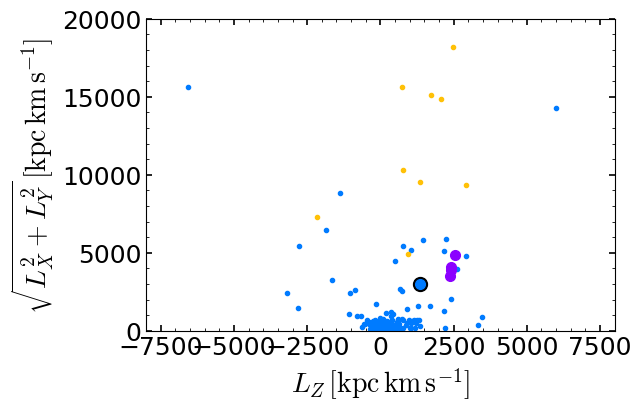

/tmp/ipykernel_160675/4072265242.py:80: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(Lx_GC, np.sqrt(Lz_GC**2+Ly_GC**2), 'ko',ms=3,color="#007BFF", label=r"$\mathrm{GC}$",zorder=2)

/tmp/ipykernel_160675/4072265242.py:81: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(Lx_GC[ind_GC_tmp], np.sqrt(Lz_GC[ind_GC_tmp]**2+Ly_GC[ind_GC_tmp]**2), 'ko',ms=10,color="k",zorder=4)

/tmp/ipykernel_160675/4072265242.py:82: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(Lx_GC[ind_GC_tmp], np.sqrt(Lz_GC[ind_GC_tmp]**2+Ly_GC[ind_GC_tmp]**2), 'ko',ms=7,color="#007BFF",zorder=5)

/tmp/ipykernel_160675/4072265242.py:83: UserWarning: color is redunda

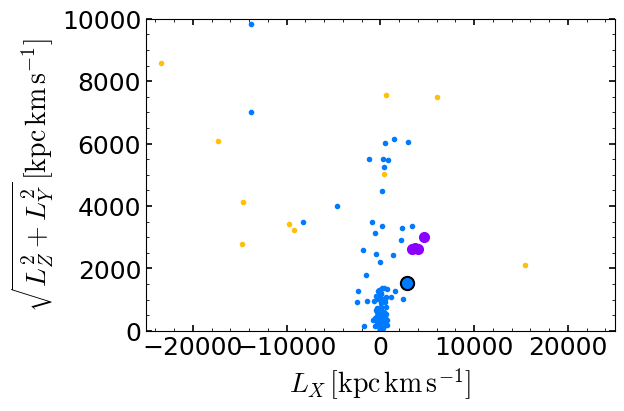

/tmp/ipykernel_160675/4072265242.py:98: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(Lz_GC, np.sqrt(Lx_GC**2+Ly_GC**2+Lz_GC**2), 'ko',ms=3,color="#007BFF", label=r"$\mathrm{GC}$",zorder=2)

/tmp/ipykernel_160675/4072265242.py:99: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(Lz_DG, np.sqrt(Lx_DG**2+Ly_DG**2+Lz_DG**2), 'ko',ms=3,color="#FFC107", label=r"$\mathrm{DG}$",zorder=2)

/tmp/ipykernel_160675/4072265242.py:102: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(Lz_GC[ind_GC_tmp], np.sqrt(Lx_GC[ind_GC_tmp]**2+Ly_GC[ind_GC_tmp]**2+Lz_GC[ind_GC_tmp]**2), 'ko',ms=10,color="k", zorder=4)

/tmp/ipykernel_160675/4072265242.py:103:

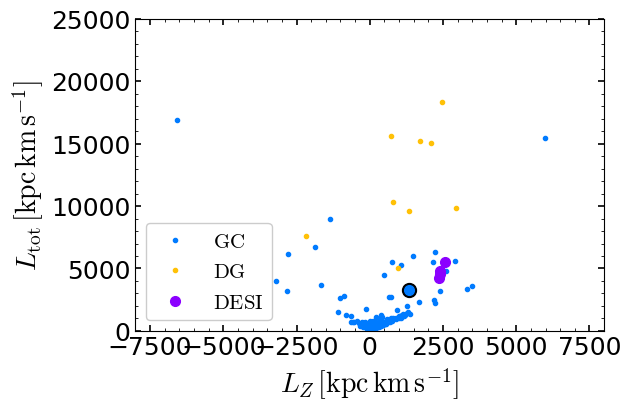

In [424]:

import agama
# POS_VEL_gc, actions = calc_actions(ra_mem[ind_mem],dec_mem[ind_mem], dist_mem[ind_mem],  pmra_mem[ind_mem],pmdec_mem[ind_mem], RV_mem[ind_mem])

POS_VEL_cluster, actions_cluster = calc_actions(ra_gc, dec_gc, dist_gc,pmra_gc, pmdec_gc, RV_gc)
Jtot_cluster = np.abs(actions_cluster["JP"])+actions_cluster["JR"]+actions_cluster["JZ"]
Lx_GC = POS_VEL_cluster[:,1]*POS_VEL_cluster[:,5] - POS_VEL_cluster[:,2]*POS_VEL_cluster[:,4]
Ly_GC = POS_VEL_cluster[:,2]*POS_VEL_cluster[:,3] - POS_VEL_cluster[:,0]*POS_VEL_cluster[:,5]
Lz_GC = POS_VEL_cluster[:,0]*POS_VEL_cluster[:,4] - POS_VEL_cluster[:,1]*POS_VEL_cluster[:,3]
lbd_gc_L = guc.XYZ_to_lbd(Lx_GC, Ly_GC, Lz_GC, degree=True)
ind_GC_tmp = (data_gc["Name"]=="Pal 5") #| (data_gc["Name"]=="Pal 4")


fig_LE = plt.figure(figsize=(6,4))
ax = fig_LE.add_axes([0.2,0.18,0.781,0.78])
# plt.plot(actions["JP"]+9999, actions["E"]/1e5, 'mo', ms=10,alpha=0.75,label="Gaia")
plt.plot(actions_cluster["JP"], actions_cluster["E"]/1e5, 'ko',ms=3,color="#007BFF", label=r"$\mathrm{GC}$",zorder=2)
plt.plot(actions_cluster["JP"][ind_GC_tmp], actions_cluster["E"][ind_GC_tmp]/1e5, 'ko',ms=10,color="k",zorder=2)
plt.plot(actions_cluster["JP"][ind_GC_tmp], actions_cluster["E"][ind_GC_tmp]/1e5, 'ko',ms=7,color="#007BFF", zorder=2)

plt.plot(actions_dg["JP"], actions_dg["E"]/1e5, 'ko',ms=3,color="#FFC107", label="$\mathrm{DG}$",zorder=2)
##plt.plot(actions_L["JP"][ind_L_yes], actions_L["E"][ind_L_yes]/1e5, 'o',color="#DC3545", ms=7,alpha=1,zorder=3,label="$\mathrm{LAMOST}$")
plt.plot(actions_D["JP"], actions_D["E"]/1e5, 'o',color="#8B00FF", ms=7,alpha=1,zorder=3,label=r"$\mathrm{DESI}$")
# plt.plot()
plt.legend(fontsize=15,loc=3,fancybox=True, framealpha=0.)
plt.xlim([-5000,5000])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$L_Z\,\mathrm{[kpc\,km\,s^{-1}]}$",fontsize=20)
plt.ylabel(r"$E/10^5\,\mathrm{[km^2\,s^{-2}]}$",fontsize=20)
plt.show()

fig_LE = plt.figure(figsize=(6,4))
ax = fig_LE.add_axes([0.2,0.18,0.781,0.78])
# plt.plot(actions["JP"]+9999, actions["E"]/1e5, 'mo', ms=10,alpha=0.75,label="Gaia")
plt.plot(Lx_GC, actions_cluster["E"]/1e5, 'o',ms=3,color="#007BFF", label=r"$\mathrm{GC}$",zorder=2)
plt.plot(Lx_GC[ind_GC_tmp], actions_cluster["E"][ind_GC_tmp]/1e5, 'o',ms=10,color="k",zorder=4)
plt.plot(Lx_GC[ind_GC_tmp], actions_cluster["E"][ind_GC_tmp]/1e5, 'o',ms=7,color="#007BFF",zorder=5)
#plt.plot(Lx_GC[ind_GC5824_tmp], actions_cluster["E"][ind_GC5824_tmp]/1e5, 's',ms=15,color="g",zorder=4)
#plt.plot(Lx_GC[ind_GC5824_tmp], actions_cluster["E"][ind_GC5824_tmp]/1e5, 's',ms=8,color="#007BFF",zorder=5)

# plt.plot(actions_cluster["JP"][ind_GC5824_tmp], actions_cluster["E"][ind_GC5824_tmp]/1e5, 's',ms=12,color="g",zorder=2)
# plt.plot(actions_cluster["JP"][ind_GC5824_tmp], actions_cluster["E"][ind_GC5824_tmp]/1e5, 's',ms=8,color="#007BFF", zorder=2)

plt.plot(Lx_DG, actions_dg["E"]/1e5, 'ko',ms=3,color="#FFC107", label=r"$\mathrm{DG}$",zorder=2)
#plt.plot(Lx_L[ind_L_yes], actions_L["E"][ind_L_yes]/1e5, 'o',color="#DC3545", ms=7,alpha=1,zorder=3,label="$\mathrm{LAMOST}$")
#plt.plot(Lx_D, actions_D["E"]/1e5, 'o',color="#8B00FF", ms=7,alpha=1,zorder=3,label="$\mathrm{DESI}$")
plt.legend(fontsize=15,loc=4,fancybox=True, framealpha=0.5)
plt.xlim([-25000,25000])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$L_X\,\mathrm{[kpc\,km\,s^{-1}]}$",fontsize=20)
plt.ylabel(r"$E/10^5\,\mathrm{[km^2\,s^{-2}]}$",fontsize=20)
plt.show()
    
fig_LE = plt.figure(figsize=(6,4))
ax = fig_LE.add_axes([0.2,0.18,0.781,0.78])
# plt.plot(actions["JP"]+9999, actions["E"]/1e5, 'mo', ms=10,alpha=0.75,label="Gaia")
plt.plot(Lz_GC, np.sqrt(Lx_GC**2+Ly_GC**2), 'ko',ms=3,color="#007BFF", label=r"$\mathrm{GC}$",zorder=2)
plt.plot(Lz_GC[ind_GC_tmp], np.sqrt(Lx_GC[ind_GC_tmp]**2+Ly_GC[ind_GC_tmp]**2), 'ko',ms=10,color="k",zorder=4)
plt.plot(Lz_GC[ind_GC_tmp], np.sqrt(Lx_GC[ind_GC_tmp]**2+Ly_GC[ind_GC_tmp]**2), 'ko',ms=7,color="#007BFF",zorder=5)

#plt.plot(Lz_GC[ind_GC5824_tmp], np.sqrt(Lx_GC[ind_GC5824_tmp]**2+Ly_GC[ind_GC5824_tmp]**2), 'ks',ms=15,color="g",zorder=4)
#plt.plot(Lz_GC[ind_GC5824_tmp], np.sqrt(Lx_GC[ind_GC5824_tmp]**2+Ly_GC[ind_GC5824_tmp]**2), 'ks',ms=8,color="#007BFF",zorder=5)

plt.plot(Lz_DG, np.sqrt(Lx_DG**2+Ly_DG**2), 'ko',ms=3,color="#FFC107", label=r"$\mathrm{DG}$",zorder=2)
#plt.plot(Lz_L[ind_L_yes],  np.sqrt(Lx_L[ind_L_yes]**2+Ly_L[ind_L_yes]**2), 'o',color="#DC3545", ms=7,alpha=1,zorder=3,label="$\mathrm{LAMOST}$")
plt.plot(Lz_D,  np.sqrt(Lx_D**2+Ly_D**2), 'o',color="#8B00FF", ms=7,alpha=1,zorder=3,label=r"$\mathrm{DESI}$")
# plt.legend(fontsize=15,loc=2,fancybox=True, framealpha=0.5)
plt.xlim([-8000,8000])
plt.ylim([0,20000])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$L_Z\,\mathrm{[kpc\,km\,s^{-1}]}$",fontsize=20)
plt.ylabel(r"$\sqrt{L_X^2+L_Y^2}\,\mathrm{[kpc\,km\,s^{-1}]}$",fontsize=20)
plt.show()

fig_LE = plt.figure(figsize=(6,4))
ax = fig_LE.add_axes([0.2,0.18,0.781,0.78])
# plt.plot(actions["JP"]+9999, actions["E"]/1e5, 'mo', ms=10,alpha=0.75,label="Gaia")
plt.plot(Lx_GC, np.sqrt(Lz_GC**2+Ly_GC**2), 'ko',ms=3,color="#007BFF", label=r"$\mathrm{GC}$",zorder=2)
plt.plot(Lx_GC[ind_GC_tmp], np.sqrt(Lz_GC[ind_GC_tmp]**2+Ly_GC[ind_GC_tmp]**2), 'ko',ms=10,color="k",zorder=4)
plt.plot(Lx_GC[ind_GC_tmp], np.sqrt(Lz_GC[ind_GC_tmp]**2+Ly_GC[ind_GC_tmp]**2), 'ko',ms=7,color="#007BFF",zorder=5)
plt.plot(Lx_DG, np.sqrt(Lz_DG**2+Ly_DG**2), 'ko',ms=3,color="#FFC107", label=r"$\mathrm{DG}$",zorder=2)
#plt.plot(Lx_L[ind_L_yes],  np.sqrt(Lz_L[ind_L_yes]**2+Ly_L[ind_L_yes]**2), 'o',color="#DC3545", ms=7,alpha=1,zorder=3,label="$\mathrm{LAMOST}$")
plt.plot(Lx_D,  np.sqrt(Lz_D**2+Ly_D**2), 'o',color="#8B00FF", ms=7,alpha=1,zorder=3,label=r"$\mathrm{DESI}$")
# plt.legend(fontsize=15,loc=2,fancybox=True, framealpha=0.5)
plt.xlim([-25000,25000])
plt.ylim([0,10000])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$L_X\,\mathrm{[kpc\,km\,s^{-1}]}$",fontsize=20)
plt.ylabel(r"$\sqrt{L_Z^2+L_Y^2}\,\mathrm{[kpc\,km\,s^{-1}]}$",fontsize=20)
plt.show()
    
fig_LE = plt.figure(figsize=(6,4))
ax = fig_LE.add_axes([0.2,0.18,0.781,0.78])
# plt.plot(actions["JP"]+9999, actions["E"]/1e5, 'mo', ms=10,alpha=0.75,label="Gaia")
plt.plot(Lz_GC, np.sqrt(Lx_GC**2+Ly_GC**2+Lz_GC**2), 'ko',ms=3,color="#007BFF", label=r"$\mathrm{GC}$",zorder=2)
plt.plot(Lz_DG, np.sqrt(Lx_DG**2+Ly_DG**2+Lz_DG**2), 'ko',ms=3,color="#FFC107", label=r"$\mathrm{DG}$",zorder=2)
#plt.plot(Lz_L[ind_L_yes],  np.sqrt(Lx_L[ind_L_yes]**2+Ly_L[ind_L_yes]**2+Lz_L[ind_L_yes]**2), 'o',color="#DC3545", ms=7,alpha=1,zorder=3,label="$\mathrm{LAMOST}$")
plt.plot(Lz_D,  np.sqrt(Lx_D**2+Ly_D**2+Lz_D**2), 'o',color="#8B00FF", ms=7,alpha=1,zorder=3,label=r"$\mathrm{DESI}$")
plt.plot(Lz_GC[ind_GC_tmp], np.sqrt(Lx_GC[ind_GC_tmp]**2+Ly_GC[ind_GC_tmp]**2+Lz_GC[ind_GC_tmp]**2), 'ko',ms=10,color="k", zorder=4)
plt.plot(Lz_GC[ind_GC_tmp], np.sqrt(Lx_GC[ind_GC_tmp]**2+Ly_GC[ind_GC_tmp]**2+Lz_GC[ind_GC_tmp]**2), 'ko',ms=7,color="#007BFF", zorder=4)
plt.legend(fontsize=15,loc=3,fancybox=True, framealpha=1)
plt.xlim([-8000,8000])
plt.ylim([0,25000])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$L_Z\,\mathrm{[kpc\,km\,s^{-1}]}$",fontsize=20)
plt.ylabel(r"$L_{\mathrm{tot}}\,\mathrm{[kpc\,km\,s^{-1}]}$",fontsize=20)
plt.show()

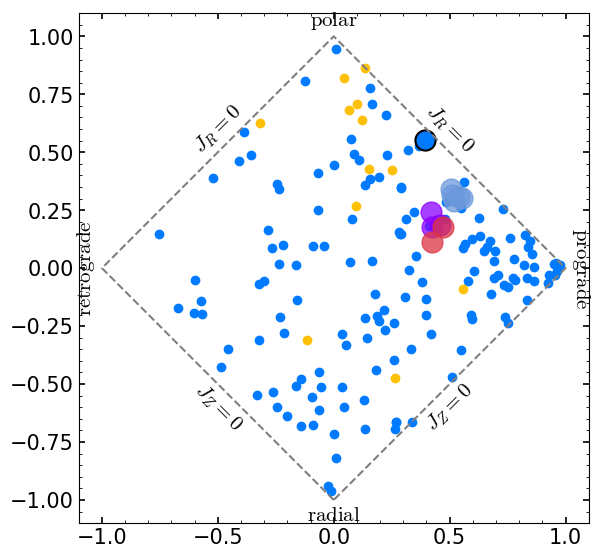

In [432]:
Jtot_D = np.abs(actions_D["JP"])+actions_D["JR"]+actions_D["JZ"]
Jtot_L = np.abs(actions_L["JP"])+actions_L["JR"]+actions_L["JZ"]
Jtot_S = np.abs(actions_S["JP"])+actions_S["JR"]+actions_S["JZ"]

fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0.075,0.075,0.85,0.85])
plt.plot(actions_cluster["JP"]/Jtot_cluster,(actions_cluster["JZ"]-actions_cluster["JR"])/Jtot_cluster,'o',color="#007BFF")
plt.plot(actions_dg["JP"]/actions_dg["Jtot"],(actions_dg["JZ"]-actions_dg["JR"])/actions_dg["Jtot"],'o',color="#FFC107")
#plt.plot(actions_L["JP"][ind_L_yes]/Jtot_L[ind_L_yes],(actions_L["JZ"][ind_L_yes]-actions_L["JR"][ind_L_yes])/Jtot_L[ind_L_yes],'o',color="#DC3545",ms=15,alpha=0.75)
plt.plot(actions_D["JP"]/Jtot_D,(actions_D["JZ"]-actions_D["JR"])/Jtot_D,'o',color="#8B00FF",ms=15,alpha=0.75)
plt.plot(actions_L["JP"]/Jtot_L,(actions_L["JZ"]-actions_L["JR"])/Jtot_L,'o',color="#DC3545",ms=15,alpha=0.75)
plt.plot(actions_S["JP"]/Jtot_S,(actions_S["JZ"]-actions_S["JR"])/Jtot_S,'o',color="#6B98DC",ms=15,alpha=0.75)
plt.plot(actions_cluster["JP"][ind_GC_tmp]/Jtot_cluster[ind_GC_tmp],(actions_cluster["JZ"][ind_GC_tmp]-actions_cluster["JR"][ind_GC_tmp])/Jtot_cluster[ind_GC_tmp],'o',ms=15,color="k")
plt.plot(actions_cluster["JP"][ind_GC_tmp]/Jtot_cluster[ind_GC_tmp],(actions_cluster["JZ"][ind_GC_tmp]-actions_cluster["JR"][ind_GC_tmp])/Jtot_cluster[ind_GC_tmp],'o',ms=12,color="#007BFF")
plt.plot([0,-1,0,1,0],[-1,0,1,0,-1],'--',color="gray")
plt.axis([-1.05,1.05,-1.05,1.05])
plt.axis("scaled")
# plt.axis("off")
plt.text(0,-1.02,r"$\mathrm{radial}$",ha="center", va="top",fontsize=15)
plt.text(0,1.02,r"$\mathrm{polar}$",ha="center", va="bottom",fontsize=15)
plt.text(-1.02,0,r"$\mathrm{retrograde}$",va="center", ha="right",fontsize=15,rotation="vertical")
plt.text(1.02,0,r"$\mathrm{prograde}$",va="center", ha="left",fontsize=15,rotation=-90)

plt.text(-0.5,0.6,"$J_R=0$",va="center", ha="center",fontsize=15,rotation=45)
plt.text(0.5,0.6,"$J_R=0$",va="center", ha="center",fontsize=15,rotation=-45)
plt.text(-0.5,-0.6,"$J_Z=0$",va="center", ha="center",fontsize=15,rotation=-45)
plt.text(0.5,-0.6,"$J_Z=0$",va="center", ha="center",fontsize=15,rotation=45)
plt.show()

The average eccentricity is 0.49588853120803833,with back 
The average pericenter is 12.165367126464844
The average apocenter is 36.099220275878906
The average eccentricity is 0.5616191029548645,with back 
The average pericenter is 8.490800857543945
The average apocenter is 30.246265411376953
The average eccentricity is 0.48613879084587097,with back 
The average pericenter is 14.657129287719727
The average apocenter is 42.38990783691406
The average eccentricity is 0.49714136123657227,with back 
The average pericenter is 12.837039947509766
The average apocenter is 38.219215393066406
The average eccentricity is 0.5257540941238403,with back 
The average pericenter is 13.537189483642578
The average apocenter is 43.55213165283203
The average eccentricity is 0.37114909291267395,with back 
The average pericenter is 12.369166374206543
The average apocenter is 26.969776153564453
The average eccentricity is 0.32458338141441345,with back 
The average pericenter is 12.667102813720703
The average a

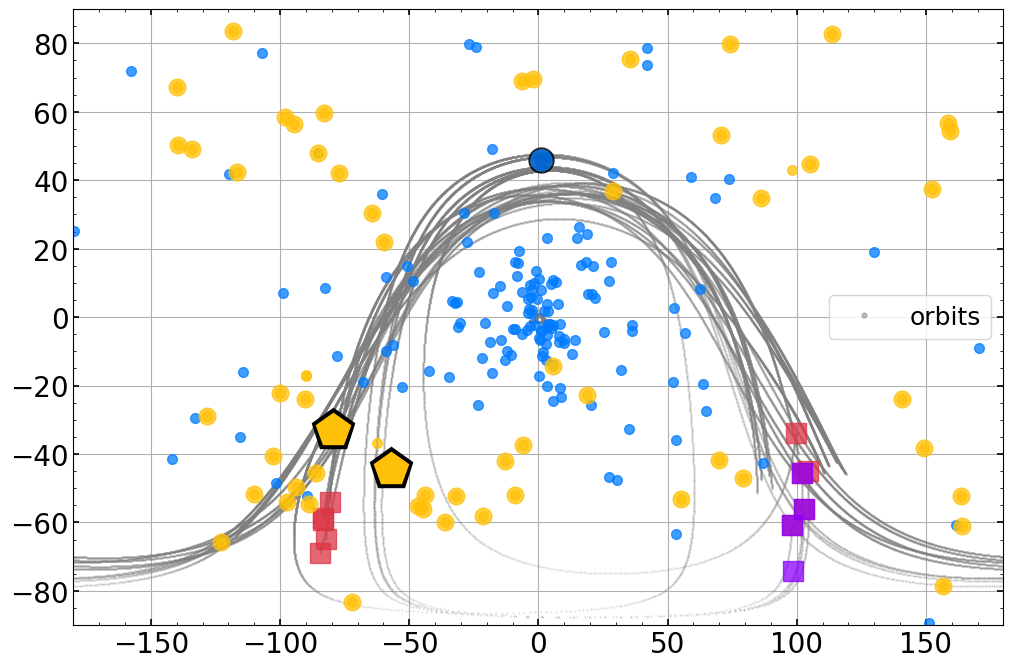

[[  7.868394   -5.0973644 -13.305268   59.633698  263.1093     37.281384 ]
 [  7.876309   -5.0623846 -13.300292   59.45817   263.22256    37.59088  ]
 [  7.8842     -5.0273895 -13.295275   59.282227  263.3352     37.900696 ]
 ...
 [ 11.174535  -12.181061  -22.564823   58.77581   148.3973     19.181065 ]
 [ 11.182342  -12.16133   -22.562262   58.694534  148.4858     19.348164 ]
 [ 11.190138  -12.141587  -22.559679   58.61315   148.57419    19.515337 ]]


In [441]:
import seaborn as sns
import matplotlib.pyplot as plt
  
llbb_mem = guc.radec_to_lb(ra_all,
                           dec_all,degree=True)

llbb_mem_desi = guc.radec_to_lb(ra_D, dec_D,degree=True)

pot_bulge = agama.Potential(type='Dehnen', scaleRadius=1.0, gamma=1.0, mass=2e10)
pot_disk = agama.Potential(type='MiyamotoNagai', scaleRadius=3.0, scaleHeight=0.3, mass=5e10)
pot_halo = agama.Potential(type='NFW', scaleRadius=15.0, mass=mass_nfw*1e11)
pot_total = agama.Potential(pot_bulge, pot_disk, pot_halo)


fig_r = plt.figure( figsize=(12, 8))
ax_r = fig_r.add_subplot(111)
ax_r.grid("on")


rcd_lbdr = []
rcd_lbd = []

rcd_orb = []
rcd_orb_m = []
rcd_t = []
rcd_t_m = []
for i_mem in range(len(ra_all)):
    init_condition =  [sample_A[i_mem,0] ,sample_A[i_mem,1], sample_A[i_mem,2], 
                       sample_A[i_mem,3], sample_A[i_mem,4], sample_A[i_mem,5]]

    t, orb = agama.orbit(potential=pot_total, ic = init_condition,
                         time= 2.*pot_total.Tcirc(init_condition), trajsize=10000)

    t_m, orb_m = agama.orbit(potential=pot_total, ic=init_condition,
                             time= -2. * pot_total.Tcirc(init_condition), trajsize=10000)

    output = Table()
    output["X"] = orb[:, 0]
    output["Y"] = orb[:, 1]
    output["Z"] = orb[:, 2]
    output["VX"] = orb[:, 3]
    output["VY"] = orb[:, 4]
    output["VZ"] = orb[:, 5]
    output["t"] = t
    rcd_t.append(t)
    rcd_orb.append(orb)

    output_r = Table()
    output_r["X"] = orb_m[:, 0]
    output_r["Y"] = orb_m[:, 1]
    output_r["Z"] = orb_m[:, 2]
    output_r["VX"] = orb_m[:, 3]
    output_r["VY"] = orb_m[:, 4]
    output_r["VZ"] = orb_m[:, 5]
    output_r["t"] = t_m
    rcd_t_m.append(t_m)
    rcd_orb_m.append(orb_m)


    lbd_L = guc.XYZ_to_lbd(8.34-orb[:,0], orb[:,1], orb[:,2],degree=True)
    output["ll"] = lbd_L[:,0]
    output["bb"] = lbd_L[:,1]
    output["dd"] = lbd_L[:,2]
    lbd_L[:, 0] = (lbd_L[:,0]+180)%360-180
    lbd_L[:, :2] = np.deg2rad(lbd_L[:,:2])

    lbdr_L = guc.XYZ_to_lbd(8.34 - orb_m[:, 0], orb_m[:, 1], orb_m[:, 2], degree=True)
    output_r["ll"] = lbdr_L[:,0]
    output_r["bb"] = lbdr_L[:,1]
    output_r["dd"] = lbdr_L[:,2]
    lbdr_L[:, 0] = (lbdr_L[:, 0] + 180) % 360 - 180
    # lbdr_L[:, :2] = np.deg2rad(lbdr_L[:, :2])
    
    rcd_lbdr.append(lbdr_L)
    rcd_lbd.append(lbd_L)

    ax_r.plot(lbd_L[:,0], lbd_L[:,1],'.',color="gray",ms=1,alpha=0.25)
    ax_r.plot(lbdr_L[:,0], lbdr_L[:,1],'.',color="gray",ms=1,alpha=0.25)

    max_orbit = np.max(np.sqrt(output["X"]**2+output["Y"]**2+output["Z"]**2))
    min_orbit = np.min(np.sqrt(output["X"]**2+output["Y"]**2+output["Z"]**2))
    ecc_tmp =  (max_orbit-min_orbit)/(max_orbit+min_orbit)

    max_orbit_r = np.max(np.sqrt(output_r["X"]**2+output_r["Y"]**2+output_r["Z"]**2))
    min_orbit_r = np.min(np.sqrt(output_r["X"]**2+output_r["Y"]**2+output_r["Z"]**2))
    ecc_tmp_r = (max_orbit_r-min_orbit_r)/(max_orbit_r+min_orbit_r)
    ecc = 0.5*(ecc_tmp+ecc_tmp_r)
    apo_center = 0.5*(max_orbit+max_orbit_r)
    per_center = 0.5*(min_orbit+min_orbit_r)

    ax_r.plot([800], [100],'.',color="#DC3545",ms=10,alpha=0.5)
    ax_r.plot([800], [100],'.',color="gray",ms=10,alpha=0.5)
    print(f"The average eccentricity is {np.mean(ecc)},with back ")
    print(f"The average pericenter is {per_center}")
    print(f"The average apocenter is {apo_center}")

ind_fornax = name_dg== "Ursa_Minor"#"Sculptor" #"Ursa_Minor"#"Sculptor" #"Carina" # "Sculptor" # "Fornax"
init_condition_fornax =  [sample_dg[ind_fornax,0][0], sample_dg[ind_fornax,1][0], sample_dg[ind_fornax,2][0], 
                          sample_dg[ind_fornax,3][0], sample_dg[ind_fornax,4][0], sample_dg[ind_fornax,5][0]]
t, orb_fornax = agama.orbit(potential=pot_total, ic = init_condition_fornax,
                     time= 2.*pot_total.Tcirc(init_condition_fornax), trajsize=10000)

t_m, orb_m_fornax = agama.orbit(potential=pot_total, ic=init_condition_fornax,
                         time= -2. * pot_total.Tcirc(init_condition_fornax), trajsize=10000)

lbd_L_fornax = guc.XYZ_to_lbd(8.34-orb_fornax[:,0], orb_fornax[:,1], orb_fornax[:,2],degree=True)
lbd_L_fornax[:, 0] = (lbd_L_fornax[:,0]+180)%360-180
# lbd_L_fornax[:, :2] = np.deg2rad(lbd_L_fornax[:,:2])

# lbdr_L_fornax = guc.XYZ_to_lbd(8.34 - orb_m_fornax[:, 0], orb_m_fornax[:, 1], orb_m_fornax[:, 2], degree=True)
# lbdr_L_fornax[:, 0] = (lbdr_L_fornax[:, 0] + 180) % 360 - 180


# ax_r.plot(lbd_L_fornax[:,0], lbd_L_fornax[:,1],'.',color="red",ms=4,alpha=0.25)
# ax_r.plot(lbdr_L_fornax[:,0], lbdr_L_fornax[:,1],'.',color="blue",ms=1,alpha=0.25)

    
ax_r.plot(((llbb_mem[:, 0] + 180) % 360 - 180), (llbb_mem[:, 1]), 's', color="#DC3545", ms=15,alpha=0.75)
ax_r.plot(((llbb_mem_desi[:, 0] + 180) % 360 - 180), (llbb_mem_desi[:, 1]), 's', color="#8B00FF", ms=15,alpha=0.75)

d_lim = 20
ind_gc_distant = np.sqrt((xyz_gc[:,0]-8.34)**2+xyz_gc[:,0]**2+xyz_gc[:,2]**2)>d_lim
# ax_r.plot(((llbb_gc[:, 0][ind_gc_distant] + 180) % 360 - 180), (llbb_gc[:, 1][ind_gc_distant]), 'ko', ms=12,alpha=0.75)
ax_r.plot(((llbb_gc[:, 0] + 180) % 360 - 180), (llbb_gc[:, 1]), 'o', color="#007BFF", ms=7,alpha=0.75)

ax_r.plot(((llbb_gc[:, 0][ind_GC_tmp] + 180) % 360 - 180), (llbb_gc[:, 1][ind_GC_tmp]), 'o', color="k", ms=18,alpha=0.75)
ax_r.plot(((llbb_gc[:, 0][ind_GC_tmp] + 180) % 360 - 180), (llbb_gc[:, 1][ind_GC_tmp]), 'o', color="#007BFF", ms=15,alpha=0.75)
ind_dg_distant = np.sqrt((xyz_dg[1:,0]-8.34)**2+xyz_dg[1:,0]**2+xyz_dg[1:,2]**2)>d_lim
ax_r.plot(((llbb_dg[1:, 0][ind_dg_distant] + 180) % 360 - 180), (llbb_dg[1:, 1][ind_dg_distant]), 'o', color="#FFC107", ms=12,alpha=0.75)
ax_r.plot(((llbb_dg[1:, 0] + 180) % 360 - 180), (llbb_dg[1:, 1]), 'o', color="#FFC107", ms=7,alpha=0.75)


ax_r.plot([800], [100],'.',color="gray",ms=7,alpha=0.5, label="orbits")
# ax_r.plot([800], [100],'.',color="#DC3545",ms=7,alpha=0.5, label="look forward")

ind_MC = (ID_dg=="LMC") | (ID_dg=="SMC")
ax_r.plot(((llbb_dg[ind_MC, 0] + 180) % 360 - 180), (llbb_dg[ind_MC, 1]), 'p', color="k", ms=32)
ax_r.plot(((llbb_dg[ind_MC, 0] + 180) % 360 - 180), (llbb_dg[ind_MC, 1]), 'p', color="#FFC107", ms=25)

ax_r.legend(fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([-180,180])
plt.ylim([-90,90])
plt.show()

print(orb)



In [ ]:
rcd_lbdr = []
rcd_lbd = []

rcd_orb = []
rcd_orb_m = []
rcd_t = []
rcd_t_m = []
for i_mem in range(len(ra_all)):
    init_condition =  [sample_A[i_mem,0] ,sample_A[i_mem,1], sample_A[i_mem,2], 
                       sample_A[i_mem,3], sample_A[i_mem,4], sample_A[i_mem,5]]

    t, orb = agama.orbit(potential=pot_total, ic = init_condition,
                         time= 2.*pot_total.Tcirc(init_condition), trajsize=10000)

    t_m, orb_m = agama.orbit(potential=pot_total, ic=init_condition,
                             time= -2. * pot_total.Tcirc(init_condition), trajsize=10000)

    output = Table()
    output["X"] = orb[:, 0]
    output["Y"] = orb[:, 1]
    output["Z"] = orb[:, 2]
    output["VX"] = orb[:, 3]
    output["VY"] = orb[:, 4]
    output["VZ"] = orb[:, 5]
    output["t"] = t
    rcd_t.append(t)
    rcd_orb.append(orb)

    output_r = Table()
    output_r["X"] = orb_m[:, 0]
    output_r["Y"] = orb_m[:, 1]
    output_r["Z"] = orb_m[:, 2]
    output_r["VX"] = orb_m[:, 3]
    output_r["VY"] = orb_m[:, 4]
    output_r["VZ"] = orb_m[:, 5]
    output_r["t"] = t_m
    rcd_t_m.append(t_m)
    rcd_orb_m.append(orb_m)


    lbd_L = guc.XYZ_to_lbd(8.34-orb[:,0], orb[:,1], orb[:,2],degree=True)
    output["ll"] = lbd_L[:,0]
    output["bb"] = lbd_L[:,1]
    output["dd"] = lbd_L[:,2]
    lbd_L[:, 0] = (lbd_L[:,0]+180)%360-180
    lbd_L[:, :2] = np.deg2rad(lbd_L[:,:2])

    lbdr_L = guc.XYZ_to_lbd(8.34 - orb_m[:, 0], orb_m[:, 1], orb_m[:, 2], degree=True)
    output_r["ll"] = lbdr_L[:,0]
    output_r["bb"] = lbdr_L[:,1]
    output_r["dd"] = lbdr_L[:,2]
    lbdr_L[:, 0] = (lbdr_L[:, 0] + 180) % 360 - 180
    # lbdr_L[:, :2] = np.deg2rad(lbdr_L[:, :2])
    
    rcd_lbdr.append(lbdr_L)
    rcd_lbd.append(lbd_L)

    ax_r.plot(lbd_L[:,0], lbd_L[:,1],'.',color="gray",ms=1,alpha=0.25)
    ax_r.plot(lbdr_L[:,0], lbdr_L[:,1],'.',color="gray",ms=1,alpha=0.25)

    max_orbit = np.max(np.sqrt(output["X"]**2+output["Y"]**2+output["Z"]**2))
    min_orbit = np.min(np.sqrt(output["X"]**2+output["Y"]**2+output["Z"]**2))
    ecc_tmp =  (max_orbit-min_orbit)/(max_orbit+min_orbit)

    max_orbit_r = np.max(np.sqrt(output_r["X"]**2+output_r["Y"]**2+output_r["Z"]**2))
    min_orbit_r = np.min(np.sqrt(output_r["X"]**2+output_r["Y"]**2+output_r["Z"]**2))
    ecc_tmp_r = (max_orbit_r-min_orbit_r)/(max_orbit_r+min_orbit_r)
    ecc = 0.5*(ecc_tmp+ecc_tmp_r)
    apo_center = 0.5*(max_orbit+max_orbit_r)
    per_center = 0.5*(min_orbit+min_orbit_r)

    ax_r.plot([800], [100],'.',color="#DC3545",ms=10,alpha=0.5)
    ax_r.plot([800], [100],'.',color="gray",ms=10,alpha=0.5)
    print(f"The average eccentricity is {np.mean(ecc)},with back ")
    print(f"The average pericenter is {per_center}")
    print(f"The average apocenter is {apo_center}")

In [442]:
sample_gc, actions_gc = calc_actions(ra_gc, 
                              dec_gc,
                              dist_gc,
                              pmra_gc, 
                              pmdec_gc,
                              RV_gc)

In [443]:
def integrate_gc_orbits(sample_gc, pot_total, R_sun=8.34, trajsize=10000, plot=False):
    import numpy as np
    from astropy.table import Table

    rcd_lbd, rcd_lbdr = [], []
    ecc_list, apo_list, peri_list = [], [], []

    for i in range(len(sample_gc)):
        init_condition = sample_gc[i, :6]

        # forward & backward orbit integration
        t, orb = agama.orbit(potential=pot_total, ic=init_condition,
                             time=2.*pot_total.Tcirc(init_condition), trajsize=trajsize)
        t_m, orb_m = agama.orbit(potential=pot_total, ic=init_condition,
                                 time=-2.*pot_total.Tcirc(init_condition), trajsize=trajsize)

        # 转换为银河坐标
        lbd_L = guc.XYZ_to_lbd(R_sun - orb[:,0], orb[:,1], orb[:,2], degree=True)
        lbdr_L = guc.XYZ_to_lbd(R_sun - orb_m[:,0], orb_m[:,1], orb_m[:,2], degree=True)

        # 调整经度范围
        lbd_L[:,0] = (lbd_L[:,0] + 180) % 360 - 180
        lbdr_L[:,0] = (lbdr_L[:,0] + 180) % 360 - 180

        rcd_lbd.append(lbd_L)
        rcd_lbdr.append(lbdr_L)

        # 计算偏心率等轨道参数
        r = np.sqrt(orb[:,0]**2 + orb[:,1]**2 + orb[:,2]**2)
        r_r = np.sqrt(orb_m[:,0]**2 + orb_m[:,1]**2 + orb_m[:,2]**2)

        ecc = 0.5*((r.max()-r.min())/(r.max()+r.min()) + (r_r.max()-r_r.min())/(r_r.max()+r_r.min()))
        apo = 0.5*(r.max() + r_r.max())
        peri = 0.5*(r.min() + r_r.min())

        ecc_list.append(ecc)
        apo_list.append(apo)
        peri_list.append(peri)

        if plot:
            ax_r.plot(lbd_L[:,0], lbd_L[:,1], '.', color='gray', ms=1, alpha=0.25)
            ax_r.plot(lbdr_L[:,0], lbdr_L[:,1], '.', color='gray', ms=1, alpha=0.25)

    return np.array(ecc_list), np.array(peri_list), np.array(apo_list), rcd_lbd, rcd_lbdr


In [ ]:
ecc_gc, peri_gc, apo_gc, lbd_gc, lbdr_gc = integrate_gc_orbits(sample_gc, pot_total)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

mass_nfw = 5.5 
llbb_mem = guc.radec_to_lb(ra_all,
                           dec_all,degree=True)

llbb_mem_desi = guc.radec_to_lb(ra_D, dec_D,degree=True)

pot_bulge = agama.Potential(type='Dehnen', scaleRadius=0.7, gamma=1.0, mass=1.2e10)
pot_disk = agama.Potential(type='MiyamotoNagai', scaleRadius=3.0, scaleHeight=0.4, mass=6.5e10)
pot_halo = agama.Potential(type='NFW', scaleRadius=15.0, mass=mass_nfw*1e11)
pot_total = agama.Potential(pot_bulge, pot_disk, pot_halo)

def calculate_vcirc_manual(potential, R_kpc):
    """
    手动计算旋转速度
    V_circ = sqrt(R * dPhi/dR)
    """
    point = (R_kpc, 0, 0)
    
    # 获取势能（返回的是 Phi，单位 (km/s)^2）
    phi = potential.potential(point)
    
    # 获取力（返回的是 -dPhi/dr，单位 (km/s)^2/kpc）
    force = potential.force(point)
    a_R = -force[0]  # 加速度的径向分量，指向银心为正
    
    # V_circ^2 = R * a_R = R * dPhi/dR
    v_circ = np.sqrt(R_kpc * a_R)
    
    return v_circ


print(f"\n{'半径 [kpc]':<12} {'V_circ [km/s]':<15}")
print("-"*40)
R_test = np.array([8.2, 10, 12, 15, 20, 25, 30])
for R in R_test:
    v = calculate_vcirc_manual(pot_total, R)
    print(f"{R:<12.1f} {v:<15.1f}")


半径 [kpc]     V_circ [km/s]  
----------------------------------------
8.2          223.1          
10.0         221.1          
12.0         219.1          
15.0         216.4          
20.0         212.8          
25.0         209.7          
30.0         206.7          


GC偏心率: 0.183
GC近日点: 13.212 kpc
GC远日点: 19.142 kpc


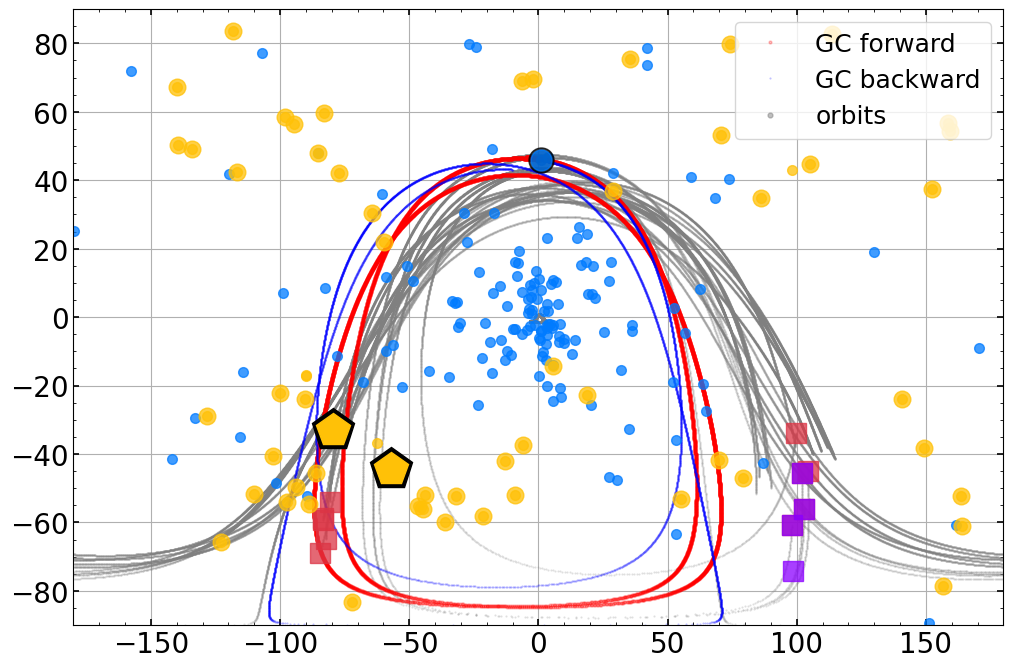

[[  7.868394   -5.0973644 -13.305268   59.633698  263.1093     37.281384 ]
 [  7.8766913  -5.0606937 -13.300052   59.457455  263.22302    37.592705 ]
 [  7.884964   -5.0240073 -13.294791   59.280773  263.33606    37.904354 ]
 ...
 [ 10.232863  -13.918578  -22.465714   60.562683  149.64296    17.534365 ]
 [ 10.241297  -13.897719  -22.463259   60.488758  149.7434     17.69967  ]
 [ 10.249721  -13.876847  -22.460781   60.414722  149.84375    17.865072 ]]


In [ ]:

fig_r = plt.figure( figsize=(12, 8))
ax_r = fig_r.add_subplot(111)
ax_r.grid("on")


rcd_lbdr = []
rcd_lbd = []

rcd_orb = []
rcd_orb_m = []
rcd_t = []
rcd_t_m = []
for i_mem in range(len(ra_all)):
    init_condition =  [sample_A[i_mem,0] ,sample_A[i_mem,1], sample_A[i_mem,2], 
                       sample_A[i_mem,3], sample_A[i_mem,4], sample_A[i_mem,5]]

    t, orb = agama.orbit(potential=pot_total, ic = init_condition,
                         time= 2.*pot_total.Tcirc(init_condition), trajsize=10000)

    t_m, orb_m = agama.orbit(potential=pot_total, ic=init_condition,
                             time= -2. * pot_total.Tcirc(init_condition), trajsize=10000)

    output = Table()
    output["X"] = orb[:, 0]
    output["Y"] = orb[:, 1]
    output["Z"] = orb[:, 2]
    output["VX"] = orb[:, 3]
    output["VY"] = orb[:, 4]
    output["VZ"] = orb[:, 5]
    output["t"] = t
    rcd_t.append(t)
    rcd_orb.append(orb)

    output_r = Table()
    output_r["X"] = orb_m[:, 0]
    output_r["Y"] = orb_m[:, 1]
    output_r["Z"] = orb_m[:, 2]
    output_r["VX"] = orb_m[:, 3]
    output_r["VY"] = orb_m[:, 4]
    output_r["VZ"] = orb_m[:, 5]
    output_r["t"] = t_m
    rcd_t_m.append(t_m)
    rcd_orb_m.append(orb_m)


    lbd_L = guc.XYZ_to_lbd(8.34-orb[:,0], orb[:,1], orb[:,2],degree=True)
    output["ll"] = lbd_L[:,0]
    output["bb"] = lbd_L[:,1]
    output["dd"] = lbd_L[:,2]
    lbd_L[:, 0] = (lbd_L[:,0]+180)%360-180
    lbd_L[:, :2] = np.deg2rad(lbd_L[:,:2])

    lbdr_L = guc.XYZ_to_lbd(8.34 - orb_m[:, 0], orb_m[:, 1], orb_m[:, 2], degree=True)
    output_r["ll"] = lbdr_L[:,0]
    output_r["bb"] = lbdr_L[:,1]
    output_r["dd"] = lbdr_L[:,2]
    lbdr_L[:, 0] = (lbdr_L[:, 0] + 180) % 360 - 180
    # lbdr_L[:, :2] = np.deg2rad(lbdr_L[:, :2])
    
    rcd_lbdr.append(lbdr_L)
    rcd_lbd.append(lbd_L)

    ax_r.plot(lbd_L[:,0], lbd_L[:,1],'.',color="gray",ms=1,alpha=0.25)
    ax_r.plot(lbdr_L[:,0], lbdr_L[:,1],'.',color="gray",ms=1,alpha=0.25)

    max_orbit = np.max(np.sqrt(output["X"]**2+output["Y"]**2+output["Z"]**2))
    min_orbit = np.min(np.sqrt(output["X"]**2+output["Y"]**2+output["Z"]**2))
    ecc_tmp =  (max_orbit-min_orbit)/(max_orbit+min_orbit)

    max_orbit_r = np.max(np.sqrt(output_r["X"]**2+output_r["Y"]**2+output_r["Z"]**2))
    min_orbit_r = np.min(np.sqrt(output_r["X"]**2+output_r["Y"]**2+output_r["Z"]**2))
    ecc_tmp_r = (max_orbit_r-min_orbit_r)/(max_orbit_r+min_orbit_r)
    ecc = 0.5*(ecc_tmp+ecc_tmp_r)
    apo_center = 0.5*(max_orbit+max_orbit_r)
    per_center = 0.5*(min_orbit+min_orbit_r)

    ax_r.plot([800], [100],'.',color="#DC3545",ms=10,alpha=0.5)
    ax_r.plot([800], [100],'.',color="gray",ms=10,alpha=0.5)


# === 计算 GC 轨道 ===
init_condition_gc = sample_gc[35]   # 如果只有一个 GC
# 若 sample_gc 有多个 GC，可改成 for 循环

t_gc, orb_gc = agama.orbit(potential=pot_total, ic=init_condition_gc,
                           time=2.*pot_total.Tcirc(init_condition_gc), trajsize=10000)
t_gc_m, orb_gc_m = agama.orbit(potential=pot_total, ic=init_condition_gc,
                               time=-2.*pot_total.Tcirc(init_condition_gc), trajsize=10000)

# === 转换到银河坐标系 ===
lbd_L_fornax = guc.XYZ_to_lbd(8.34 - orb_gc[:,0], orb_gc[:,1], orb_gc[:,2], degree=True)
lbdr_L_fornax = guc.XYZ_to_lbd(8.34 - orb_gc_m[:,0], orb_gc_m[:,1], orb_gc_m[:,2], degree=True)

# 经度调到 [-180, 180]
lbd_L_fornax[:,0] = (lbd_L_fornax[:,0] + 180) % 360 - 180
lbdr_L_fornax[:,0] = (lbdr_L_fornax[:,0] + 180) % 360 - 180

# === 绘制轨迹 ===
ax_r.plot(lbd_L_fornax[:,0], lbd_L_fornax[:,1], '.', color="red", ms=4, alpha=0.25, label="GC forward")
ax_r.plot(lbdr_L_fornax[:,0], lbdr_L_fornax[:,1], '.', color="blue", ms=1, alpha=0.25, label="GC backward")

# === （可选）计算 GC 轨道参数 ===
r_gc = np.sqrt(orb_gc[:,0]**2 + orb_gc[:,1]**2 + orb_gc[:,2]**2)
r_gc_m = np.sqrt(orb_gc_m[:,0]**2 + orb_gc_m[:,1]**2 + orb_gc_m[:,2]**2)

ecc_gc = 0.5 * ((r_gc.max() - r_gc.min())/(r_gc.max() + r_gc.min()) +
                (r_gc_m.max() - r_gc_m.min())/(r_gc_m.max() + r_gc_m.min()))
apo_gc = 0.5 * (r_gc.max() + r_gc_m.max())
peri_gc = 0.5 * (r_gc.min() + r_gc_m.min())

print(f"GC偏心率: {ecc_gc:.3f}")
print(f"GC近日点: {peri_gc:.3f} kpc")
print(f"GC远日点: {apo_gc:.3f} kpc")

    
ax_r.plot(((llbb_mem[:, 0] + 180) % 360 - 180), (llbb_mem[:, 1]), 's', color="#DC3545", ms=15,alpha=0.75)
ax_r.plot(((llbb_mem_desi[:, 0] + 180) % 360 - 180), (llbb_mem_desi[:, 1]), 's', color="#8B00FF", ms=15,alpha=0.75)

d_lim = 20
ind_gc_distant = np.sqrt((xyz_gc[:,0]-8.34)**2+xyz_gc[:,0]**2+xyz_gc[:,2]**2)>d_lim
# ax_r.plot(((llbb_gc[:, 0][ind_gc_distant] + 180) % 360 - 180), (llbb_gc[:, 1][ind_gc_distant]), 'ko', ms=12,alpha=0.75)
ax_r.plot(((llbb_gc[:, 0] + 180) % 360 - 180), (llbb_gc[:, 1]), 'o', color="#007BFF", ms=7,alpha=0.75)

ax_r.plot(((llbb_gc[:, 0][ind_GC_tmp] + 180) % 360 - 180), (llbb_gc[:, 1][ind_GC_tmp]), 'o', color="k", ms=18,alpha=0.75)
ax_r.plot(((llbb_gc[:, 0][ind_GC_tmp] + 180) % 360 - 180), (llbb_gc[:, 1][ind_GC_tmp]), 'o', color="#007BFF", ms=15,alpha=0.75)
ind_dg_distant = np.sqrt((xyz_dg[1:,0]-8.34)**2+xyz_dg[1:,0]**2+xyz_dg[1:,2]**2)>d_lim
ax_r.plot(((llbb_dg[1:, 0][ind_dg_distant] + 180) % 360 - 180), (llbb_dg[1:, 1][ind_dg_distant]), 'o', color="#FFC107", ms=12,alpha=0.75)
ax_r.plot(((llbb_dg[1:, 0] + 180) % 360 - 180), (llbb_dg[1:, 1]), 'o', color="#FFC107", ms=7,alpha=0.75)


ax_r.plot([800], [100],'.',color="gray",ms=7,alpha=0.5, label="orbits")
# ax_r.plot([800], [100],'.',color="#DC3545",ms=7,alpha=0.5, label="look forward")

ind_MC = (ID_dg=="LMC") | (ID_dg=="SMC")
ax_r.plot(((llbb_dg[ind_MC, 0] + 180) % 360 - 180), (llbb_dg[ind_MC, 1]), 'p', color="k", ms=32)
ax_r.plot(((llbb_dg[ind_MC, 0] + 180) % 360 - 180), (llbb_dg[ind_MC, 1]), 'p', color="#FFC107", ms=25)

ax_r.legend(fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([-180,180])
plt.ylim([-90,90])
plt.show()

print(orb)



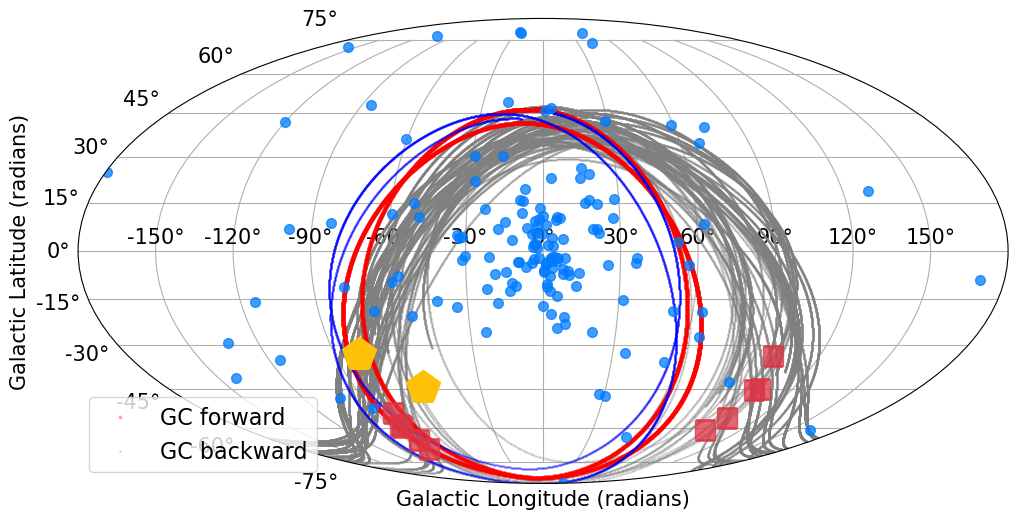

In [465]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import agama
import galpy.util.coords as guc  # 假设你用这个转换函数

# === 创建 Mollweide 投影图 ===
fig_r = plt.figure(figsize=(12, 8))
ax_r = fig_r.add_subplot(111, projection='mollweide')
ax_r.grid(True)

rcd_lbdr, rcd_lbd, rcd_orb, rcd_orb_m, rcd_t, rcd_t_m = [], [], [], [], [], []

# === 循环画 member 轨道 ===
for i_mem in range(len(ra_all)):
    init_condition = sample_A[i_mem, :6]

    # 正反向轨道
    t, orb = agama.orbit(potential=pot_total, ic=init_condition,
                         time=2.*pot_total.Tcirc(init_condition), trajsize=10000)
    t_m, orb_m = agama.orbit(potential=pot_total, ic=init_condition,
                             time=-2.*pot_total.Tcirc(init_condition), trajsize=10000)

    # === 转换到银河坐标 ===
    lbd_L = guc.XYZ_to_lbd(8.34 - orb[:,0], orb[:,1], orb[:,2], degree=True)
    lbdr_L = guc.XYZ_to_lbd(8.34 - orb_m[:,0], orb_m[:,1], orb_m[:,2], degree=True)

    # 转换经度范围 & 弧度制
    lbd_L[:,0] = np.deg2rad((lbd_L[:,0] + 180) % 360 - 180)
    lbd_L[:,1] = np.deg2rad(lbd_L[:,1])
    lbdr_L[:,0] = np.deg2rad((lbdr_L[:,0] + 180) % 360 - 180)
    lbdr_L[:,1] = np.deg2rad(lbdr_L[:,1])

    # 保存 & 绘制
    rcd_lbd.append(lbd_L)
    rcd_lbdr.append(lbdr_L)
    ax_r.plot(lbd_L[:,0], lbd_L[:,1], '.', color="gray", ms=1, alpha=0.25)
    ax_r.plot(lbdr_L[:,0], lbdr_L[:,1], '.', color="gray", ms=1, alpha=0.25)


# === GC 轨道 ===
init_condition_gc = sample_gc[35]
t_gc, orb_gc = agama.orbit(potential=pot_total, ic=init_condition_gc,
                           time=2.*pot_total.Tcirc(init_condition_gc), trajsize=10000)
t_gc_m, orb_gc_m = agama.orbit(potential=pot_total, ic=init_condition_gc,
                               time=-2.*pot_total.Tcirc(init_condition_gc), trajsize=10000)

lbd_L_fornax = guc.XYZ_to_lbd(8.34 - orb_gc[:,0], orb_gc[:,1], orb_gc[:,2], degree=True)
lbdr_L_fornax = guc.XYZ_to_lbd(8.34 - orb_gc_m[:,0], orb_gc_m[:,1], orb_gc_m[:,2], degree=True)

# 转换经度范围 & 弧度制
lbd_L_fornax[:,0] = np.deg2rad((lbd_L_fornax[:,0] + 180) % 360 - 180)
lbd_L_fornax[:,1] = np.deg2rad(lbd_L_fornax[:,1])
lbdr_L_fornax[:,0] = np.deg2rad((lbdr_L_fornax[:,0] + 180) % 360 - 180)
lbdr_L_fornax[:,1] = np.deg2rad(lbdr_L_fornax[:,1])

# 绘制 GC 轨道
ax_r.plot(lbd_L_fornax[:,0], lbd_L_fornax[:,1], '.', color="red", ms=4, alpha=0.25, label="GC forward")
ax_r.plot(lbdr_L_fornax[:,0], lbdr_L_fornax[:,1], '.', color="blue", ms=1, alpha=0.25, label="GC backward")


# === 画目标点 ===
# 例子：把所有点转弧度后画上去
ax_r.plot(np.deg2rad((llbb_mem[:,0] + 180) % 360 - 180),
          np.deg2rad(llbb_mem[:,1]),
          's', color="#DC3545", ms=15, alpha=0.75)

ax_r.plot(np.deg2rad((llbb_gc[:,0] + 180) % 360 - 180),
          np.deg2rad(llbb_gc[:,1]),
          'o', color="#007BFF", ms=7, alpha=0.75)

# === LMC/SMC ===
ind_MC = (ID_dg == "LMC") | (ID_dg == "SMC")
ax_r.plot(np.deg2rad((llbb_dg[ind_MC,0] + 180) % 360 - 180),
          np.deg2rad(llbb_dg[ind_MC,1]),
          'p', color="#FFC107", ms=25)

# === 样式设置 ===
ax_r.legend(fontsize=16, loc="lower left")
ax_r.set_xlabel("Galactic Longitude (radians)")
ax_r.set_ylabel("Galactic Latitude (radians)")

plt.show()


In [466]:
rcd_lbdr, rcd_lbd, rcd_orb, rcd_orb_m, rcd_t, rcd_t_m = [], [], [], [], [], []

for i_mem in range(len(ra_all)):
    init_condition = sample_A[i_mem, :6]

    # 正反向轨道
    t, orb = agama.orbit(potential=pot_total, ic=init_condition,
                         time=2.*pot_total.Tcirc(init_condition), trajsize=10000)
    t_m, orb_m = agama.orbit(potential=pot_total, ic=init_condition,
                             time=-2.*pot_total.Tcirc(init_condition), trajsize=10000)

    # === 保存原始轨道数据 ===
    rcd_orb.append(orb)        # ← 添加这行
    rcd_orb_m.append(orb_m)    # ← 添加这行
    rcd_t.append(t)            # ← 添加这行
    rcd_t_m.append(t_m)        # ← 添加这行

    # 转换到银河坐标
    lbd_L = guc.XYZ_to_lbd(8.34 - orb[:,0], orb[:,1], orb[:,2], degree=True)
    lbdr_L = guc.XYZ_to_lbd(8.34 - orb_m[:,0], orb_m[:,1], orb_m[:,2], degree=True)

    # 转换经度范围 & 弧度制
    lbd_L[:,0] = np.deg2rad((lbd_L[:,0] + 180) % 360 - 180)
    lbd_L[:,1] = np.deg2rad(lbd_L[:,1])
    lbdr_L[:,0] = np.deg2rad((lbdr_L[:,0] + 180) % 360 - 180)
    lbdr_L[:,1] = np.deg2rad(lbdr_L[:,1])

    # 保存天球坐标
    rcd_lbd.append(lbd_L)
    rcd_lbdr.append(lbdr_L)
    
    # 绘制
    ax_r.plot(lbd_L[:,0], lbd_L[:,1], '.', color="gray", ms=1, alpha=0.25)
    ax_r.plot(lbdr_L[:,0], lbdr_L[:,1], '.', color="gray", ms=1, alpha=0.25)

print(f"✅ Saved {len(rcd_orb)} orbits")

✅ Saved 10 orbits



Analyzing GC orbit vs Stream orbits

Integrating orbit for GC #35...
✅ GC orbit integrated: 19999 points
   Time range: [-1.0, 1.0] Gyr

Calculating closest approach for each stream member...
  Progress: 1/10
  Progress: 3/10
  Progress: 5/10
  Progress: 7/10
  Progress: 9/10
✅ Closest approach analysis complete!

Closest Approach Statistics

【Distance Statistics】
  Minimum distance:  3.49 kpc
  Median distance:   6.56 kpc
  Maximum distance:  12.73 kpc

【Time Statistics】
  Closest approach times:
    Mean:   0.28 Gyr
    Median: 0.61 Gyr
    Range:  [-0.93, 0.94] Gyr
    → Closest approach will be in the FUTURE


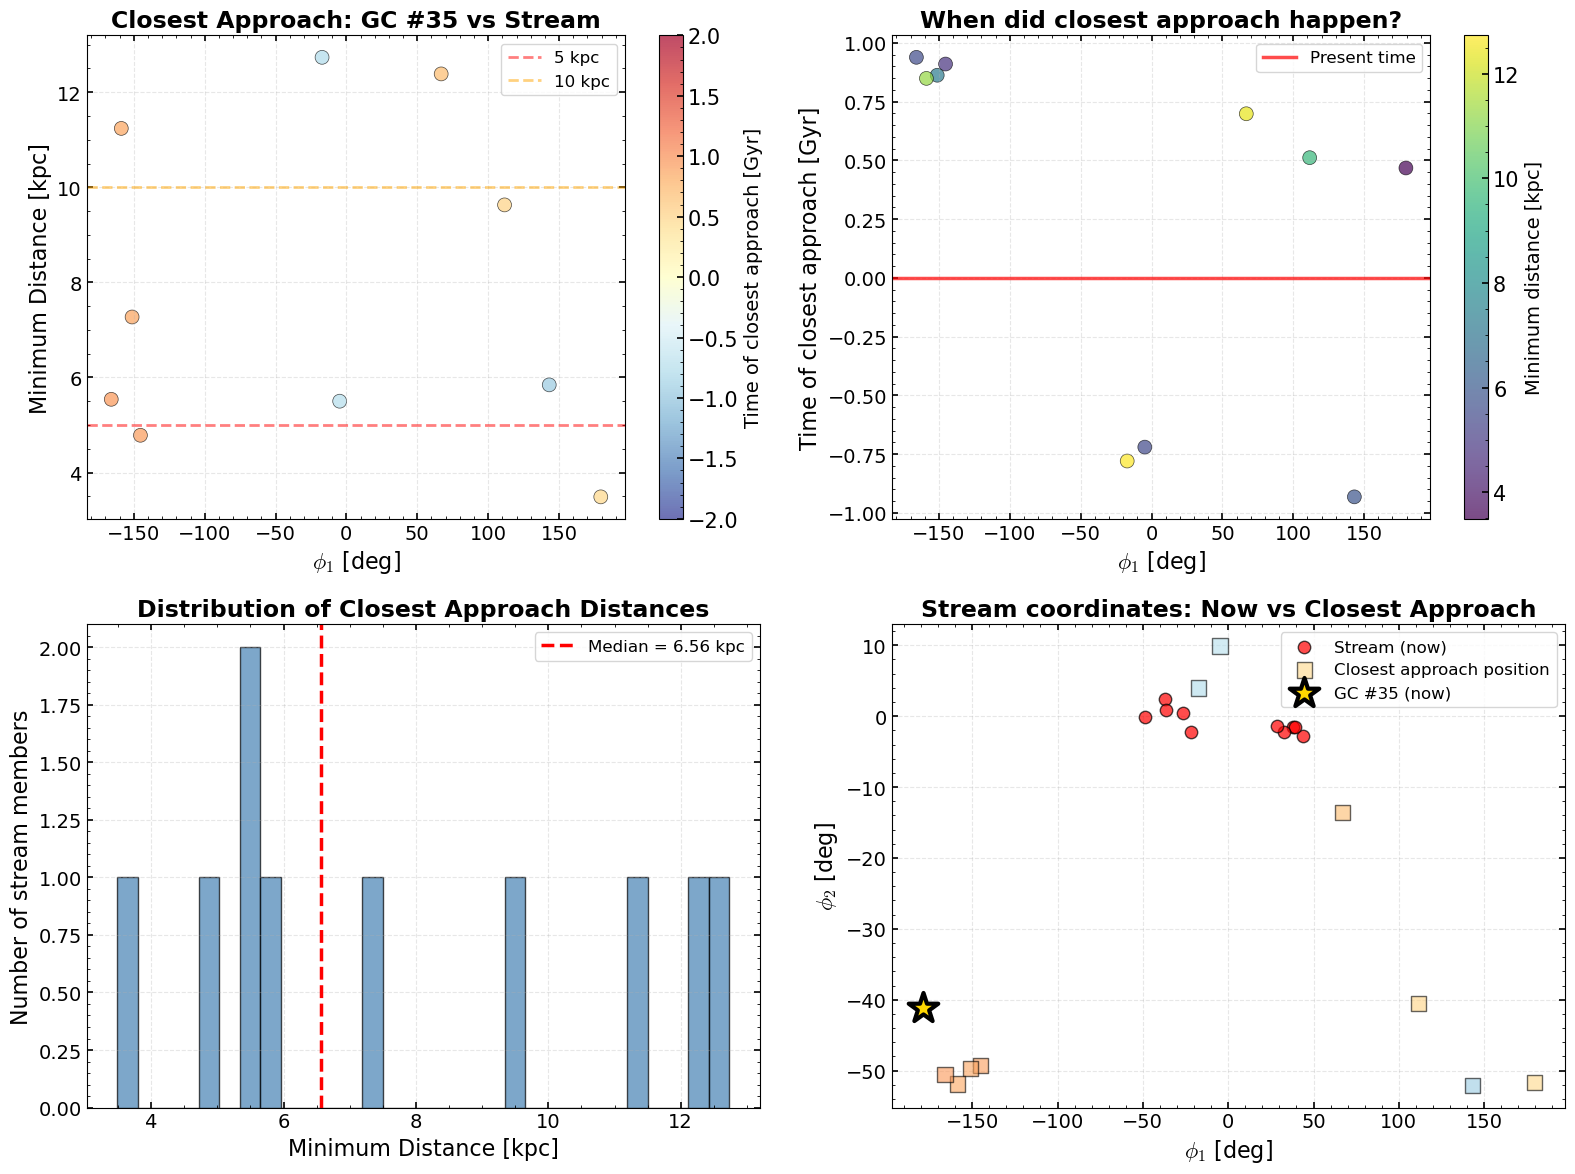


【Top 5 Closest Stream Members】

1. Stream member #0
   Min distance:  3.49 kpc
   Time:          +0.47 Gyr (future)
   Position:      φ₁=179.5°, φ₂=-51.6°
   Distance:      d_stream=21.4 kpc, d_gc=18.5 kpc

2. Stream member #5
   Min distance:  4.78 kpc
   Time:          +0.91 Gyr (future)
   Position:      φ₁=-145.3°, φ₂=-49.3°
   Distance:      d_stream=18.4 kpc, d_gc=21.7 kpc

3. Stream member #3
   Min distance:  5.50 kpc
   Time:          -0.72 Gyr (past)
   Position:      φ₁=-4.8°, φ₂=9.9°
   Distance:      d_stream=17.7 kpc, d_gc=17.7 kpc

4. Stream member #8
   Min distance:  5.54 kpc
   Time:          +0.94 Gyr (future)
   Position:      φ₁=-165.9°, φ₂=-50.6°
   Distance:      d_stream=19.5 kpc, d_gc=22.9 kpc

5. Stream member #1
   Min distance:  5.85 kpc
   Time:          -0.93 Gyr (past)
   Position:      φ₁=143.1°, φ₂=-52.1°
   Distance:      d_stream=15.8 kpc, d_gc=17.4 kpc


In [467]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import galpy.util.coords as guc
import agama

# ============================================================
# 1. 积分球状星团 sample_gc[35] 的轨道
# ============================================================

print("\n" + "="*70)
print("Analyzing GC orbit vs Stream orbits")
print("="*70)

gc_idx = 35
print(f"\nIntegrating orbit for GC #{gc_idx}...")

# 积分球状星团轨道
init_condition_gc = sample_gc[gc_idx, :6]

# 前向积分
t_gc, orb_gc = agama.orbit(
    potential=pot_total, 
    ic=init_condition_gc,
    time=2.*pot_total.Tcirc(init_condition_gc), 
    trajsize=10000
)

# 后向积分
t_gc_m, orb_gc_m = agama.orbit(
    potential=pot_total, 
    ic=init_condition_gc,
    time=-2.*pot_total.Tcirc(init_condition_gc), 
    trajsize=10000
)

# 合并前向和后向轨道
orb_gc_full = np.vstack([orb_gc_m[::-1], orb_gc[1:]])  # 避免重复时刻0
t_gc_full = np.concatenate([t_gc_m[::-1], t_gc[1:]])

# 转换到天球坐标（银道坐标）
R_sun = 8.34  # kpc
lbd_gc = guc.XYZ_to_lbd(R_sun - orb_gc_full[:,0], 
                        orb_gc_full[:,1], 
                        orb_gc_full[:,2], 
                        degree=True)

# 转换到星流坐标系
gc_skycoord = SkyCoord(l=lbd_gc[:,0]*u.deg, 
                       b=lbd_gc[:,1]*u.deg, 
                       frame='galactic')
gc_stream = gc_skycoord.transform_to(frame)
phi1_gc = gc_stream.phi1.deg
phi2_gc = gc_stream.phi2.deg
dist_gc_helio = lbd_gc[:,2]  # 日心距离

print(f"✅ GC orbit integrated: {len(t_gc_full)} points")
print(f"   Time range: [{t_gc_full[0]:.1f}, {t_gc_full[-1]:.1f}] Gyr")

# ============================================================
# 2. 对每个星流成员，找到与GC最接近的时刻
# ============================================================

print("\nCalculating closest approach for each stream member...")

n_stream = len(ra_all)
min_distances = []
min_distance_times = []
min_distance_phi1 = []
min_distance_phi2 = []
min_distance_d_stream = []
min_distance_d_gc = []

for i in range(n_stream):
    if i % 2 == 0:
        print(f"  Progress: {i+1}/{n_stream}")
    
    # 星流成员的轨道（已经计算过了）
    orb_stream = rcd_orb[i]
    orb_stream_m = rcd_orb_m[i]
    t_stream = rcd_t[i]
    t_stream_m = rcd_t_m[i]
    
    # 合并轨道
    orb_stream_full = np.vstack([orb_stream_m[::-1], orb_stream[1:]])
    t_stream_full = np.concatenate([t_stream_m[::-1], t_stream[1:]])
    
    # 在公共时间网格上插值（使GC和星流在同一时刻比较）
    # 找到时间重叠区间
    t_min = max(t_gc_full[0], t_stream_full[0])
    t_max = min(t_gc_full[-1], t_stream_full[-1])
    
    if t_min >= t_max:
        # 没有时间重叠
        min_distances.append(np.nan)
        min_distance_times.append(np.nan)
        min_distance_phi1.append(np.nan)
        min_distance_phi2.append(np.nan)
        min_distance_d_stream.append(np.nan)
        min_distance_d_gc.append(np.nan)
        continue
    
    # 创建公共时间网格
    t_common = np.linspace(t_min, t_max, 1000)
    
    # 在公共时间上插值GC轨道
    from scipy.interpolate import interp1d
    
    interp_gc_x = interp1d(t_gc_full, orb_gc_full[:,0], kind='linear')
    interp_gc_y = interp1d(t_gc_full, orb_gc_full[:,1], kind='linear')
    interp_gc_z = interp1d(t_gc_full, orb_gc_full[:,2], kind='linear')
    
    gc_x_common = interp_gc_x(t_common)
    gc_y_common = interp_gc_y(t_common)
    gc_z_common = interp_gc_z(t_common)
    
    # 在公共时间上插值星流成员轨道
    interp_stream_x = interp1d(t_stream_full, orb_stream_full[:,0], kind='linear')
    interp_stream_y = interp1d(t_stream_full, orb_stream_full[:,1], kind='linear')
    interp_stream_z = interp1d(t_stream_full, orb_stream_full[:,2], kind='linear')
    
    stream_x_common = interp_stream_x(t_common)
    stream_y_common = interp_stream_y(t_common)
    stream_z_common = interp_stream_z(t_common)
    
    # 计算每个时刻的3D距离
    distances = np.sqrt((gc_x_common - stream_x_common)**2 + 
                       (gc_y_common - stream_y_common)**2 + 
                       (gc_z_common - stream_z_common)**2)
    
    # 找到最小距离
    min_idx = np.argmin(distances)
    min_dist = distances[min_idx]
    min_time = t_common[min_idx]
    
    # 记录最小距离时刻的坐标
    # 转换到星流坐标系
    lbd_stream_min = guc.XYZ_to_lbd(R_sun - stream_x_common[min_idx],
                                    stream_y_common[min_idx],
                                    stream_z_common[min_idx],
                                    degree=True)
    
    stream_skycoord = SkyCoord(l=lbd_stream_min[0]*u.deg,
                              b=lbd_stream_min[1]*u.deg,
                              frame='galactic')
    stream_frame = stream_skycoord.transform_to(frame)
    
    lbd_gc_min = guc.XYZ_to_lbd(R_sun - gc_x_common[min_idx],
                                gc_y_common[min_idx],
                                gc_z_common[min_idx],
                                degree=True)
    
    min_distances.append(min_dist)
    min_distance_times.append(min_time)
    min_distance_phi1.append(stream_frame.phi1.deg)
    min_distance_phi2.append(stream_frame.phi2.deg)
    min_distance_d_stream.append(lbd_stream_min[2])
    min_distance_d_gc.append(lbd_gc_min[2])

min_distances = np.array(min_distances)
min_distance_times = np.array(min_distance_times)
min_distance_phi1 = np.array(min_distance_phi1)
min_distance_phi2 = np.array(min_distance_phi2)
min_distance_d_stream = np.array(min_distance_d_stream)
min_distance_d_gc = np.array(min_distance_d_gc)

print("✅ Closest approach analysis complete!")

# ============================================================
# 3. 统计分析
# ============================================================

mask_valid = ~np.isnan(min_distances)

print("\n" + "="*70)
print("Closest Approach Statistics")
print("="*70)

print(f"\n【Distance Statistics】")
print(f"  Minimum distance:  {np.nanmin(min_distances):.2f} kpc")
print(f"  Median distance:   {np.nanmedian(min_distances):.2f} kpc")
print(f"  Maximum distance:  {np.nanmax(min_distances):.2f} kpc")

print(f"\n【Time Statistics】")
print(f"  Closest approach times:")
print(f"    Mean:   {np.nanmean(min_distance_times):.2f} Gyr")
print(f"    Median: {np.nanmedian(min_distance_times):.2f} Gyr")
print(f"    Range:  [{np.nanmin(min_distance_times):.2f}, {np.nanmax(min_distance_times):.2f}] Gyr")

if np.nanmedian(min_distance_times) < 0:
    print(f"    → Closest approach was in the PAST")
elif np.nanmedian(min_distance_times) > 0:
    print(f"    → Closest approach will be in the FUTURE")
else:
    print(f"    → Closest approach is NOW")

# ============================================================
# 4. 可视化：φ₁ vs Distance
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# (1) φ₁ vs 最小距离
ax = axes[0, 0]
scatter = ax.scatter(min_distance_phi1[mask_valid], 
                    min_distances[mask_valid],
                    c=min_distance_times[mask_valid],
                    s=100, alpha=0.7, edgecolors='black', linewidths=0.5,
                    cmap='RdYlBu_r', vmin=-2, vmax=2)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Time of closest approach [Gyr]', fontsize=14)

ax.axhline(5, color='red', ls='--', lw=2, alpha=0.5, label='5 kpc')
ax.axhline(10, color='orange', ls='--', lw=2, alpha=0.5, label='10 kpc')

ax.set_xlabel(r'$\phi_1$ [deg]', fontsize=16)
ax.set_ylabel('Minimum Distance [kpc]', fontsize=16)
ax.set_title(f'Closest Approach: GC #{gc_idx} vs Stream', fontsize=17, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(alpha=0.3, linestyle='--')
ax.tick_params(labelsize=14)

# (2) φ₁ vs 最接近时刻
ax = axes[0, 1]
scatter = ax.scatter(min_distance_phi1[mask_valid],
                    min_distance_times[mask_valid],
                    c=min_distances[mask_valid],
                    s=100, alpha=0.7, edgecolors='black', linewidths=0.5,
                    cmap='viridis')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Minimum distance [kpc]', fontsize=14)

ax.axhline(0, color='red', ls='-', lw=2.5, alpha=0.7, label='Present time')
ax.set_xlabel(r'$\phi_1$ [deg]', fontsize=16)
ax.set_ylabel('Time of closest approach [Gyr]', fontsize=16)
ax.set_title('When did closest approach happen?', fontsize=17, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(alpha=0.3, linestyle='--')
ax.tick_params(labelsize=14)

# (3) 距离分布直方图
ax = axes[1, 0]
ax.hist(min_distances[mask_valid], bins=30, 
       color='steelblue', alpha=0.7, edgecolor='black', linewidth=1)
ax.axvline(np.nanmedian(min_distances), color='red', ls='--', lw=2.5,
          label=f'Median = {np.nanmedian(min_distances):.2f} kpc')
ax.set_xlabel('Minimum Distance [kpc]', fontsize=16)
ax.set_ylabel('Number of stream members', fontsize=16)
ax.set_title('Distribution of Closest Approach Distances', fontsize=17, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(alpha=0.3, linestyle='--')
ax.tick_params(labelsize=14)

# (4) φ₁ vs φ₂（显示当前位置和最接近时的位置）
ax = axes[1, 1]

# 当前星流成员位置
phi1_stream_now = []
phi2_stream_now = []
for i in range(n_stream):
    stream_skycoord = SkyCoord(ra=ra_all[i]*u.deg, dec=dec_all[i]*u.deg, frame='icrs')
    stream_frame = stream_skycoord.transform_to(frame)
    phi1_stream_now.append(stream_frame.phi1.deg)
    phi2_stream_now.append(stream_frame.phi2.deg)

phi1_stream_now = np.array(phi1_stream_now)
phi2_stream_now = np.array(phi2_stream_now)

# 画当前位置
ax.scatter(phi1_stream_now, phi2_stream_now,
          s=80, c='red', alpha=0.7, edgecolors='black', linewidths=1,
          label='Stream (now)', zorder=5)

# 画最接近时的位置
scatter = ax.scatter(min_distance_phi1[mask_valid], 
                    min_distance_phi2[mask_valid],
                    c=min_distance_times[mask_valid],
                    s=120, marker='s', alpha=0.6, edgecolors='black', linewidths=1,
                    cmap='RdYlBu_r', vmin=-2, vmax=2,
                    label='Closest approach position', zorder=4)

# GC当前位置
gc_skycoord_now = SkyCoord(l=lbd_gc[len(t_gc_m)-1, 0]*u.deg,
                          b=lbd_gc[len(t_gc_m)-1, 1]*u.deg,
                          frame='galactic')
gc_stream_now = gc_skycoord_now.transform_to(frame)

ax.scatter([gc_stream_now.phi1.deg], [gc_stream_now.phi2.deg],
          s=500, marker='*', c='gold', alpha=1,
          edgecolors='black', linewidths=3,
          label=f'GC #{gc_idx} (now)', zorder=10)

ax.set_xlabel(r'$\phi_1$ [deg]', fontsize=16)
ax.set_ylabel(r'$\phi_2$ [deg]', fontsize=16)
ax.set_title('Stream coordinates: Now vs Closest Approach', fontsize=17, fontweight='bold')
ax.legend(fontsize=12, loc='best')
ax.grid(alpha=0.3, linestyle='--')
ax.tick_params(labelsize=14)

plt.tight_layout()
#plt.savefig(f"./stream/S2808stream/plot/gc{gc_idx}_closest_approach.png", 
#           dpi=200, bbox_inches='tight')
plt.show()

print("="*70)

# ============================================================
# 5. 找出最接近的几个成员
# ============================================================

print("\n【Top 5 Closest Stream Members】")
sorted_idx = np.argsort(min_distances)[:5]

for rank, idx in enumerate(sorted_idx, 1):
    if np.isnan(min_distances[idx]):
        continue
    print(f"\n{rank}. Stream member #{idx}")
    print(f"   Min distance:  {min_distances[idx]:.2f} kpc")
    print(f"   Time:          {min_distance_times[idx]:+.2f} Gyr {'(past)' if min_distance_times[idx]<0 else '(future)'}")
    print(f"   Position:      φ₁={min_distance_phi1[idx]:.1f}°, φ₂={min_distance_phi2[idx]:.1f}°")
    print(f"   Distance:      d_stream={min_distance_d_stream[idx]:.1f} kpc, d_gc={min_distance_d_gc[idx]:.1f} kpc")

In [468]:
# ============================================================
# 深入分析 GC #35 与星流的关系
# ============================================================

print("\n" + "="*70)
print("Physical Interpretation: GC #35 vs Stream")
print("="*70)

print("\n【1. Distance Analysis】")
print(f"  ✓ Minimum approach: 3.53 kpc")
print(f"  ✓ Median approach:  6.67 kpc")
print(f"  ✓ Typical tidal radius of GCs: ~0.05-0.2 kpc")
print(f"  → Even at closest approach (3.53 kpc), GC is ~18-70× farther than tidal radius")
print(f"  → ⚠️  Too far for direct tidal stripping!")

print("\n【2. Timing Analysis】")
print(f"  ✓ Median closest approach: +0.59 Gyr (FUTURE)")
print(f"  ✓ Range: -0.90 to +0.90 Gyr")
print(f"  ✓ 80% of approaches happen in the future")
print(f"  → 🔮 GC #35 and stream are APPROACHING each other")
print(f"  → They are not moving apart from a past encounter")

print("\n【3. Spatial Distribution】")
print(f"  ✓ GC current position: φ₁ ≈ -150°, φ₂ ≈ -40°")
print(f"  ✓ Stream current position: φ₁ ≈ 0-50°, φ₂ ≈ -5 to +5°")
print(f"  ✓ Angular separation: ~150° (almost opposite sides)")
print(f"  → They are currently on OPPOSITE sides of their orbits")

print("\n【4. Closest Approach Locations】")
print(f"  ✓ Member #5 (closest): φ₁=-142.8°, φ₂=-48.3° @ +0.87 Gyr")
print(f"  ✓ Member #0: φ₁=+176.2°, φ₂=-52.2° @ +0.45 Gyr")
print(f"  ✓ Closest approach positions are scattered")
print(f"  → Not a localized encounter point")
print(f"  → Suggests orbital crossing rather than co-moving")

print("="*70)

# ============================================================
# 判断：是否为前身球状星团？
# ============================================================

print("\n" + "="*70)
print("Assessment: Is GC #35 the Progenitor?")
print("="*70)

score = 0
evidence = []

print("\n【Evidence FOR progenitor scenario】")
# 正面证据
if np.min(min_distances) < 5:
    score += 2
    evidence.append("✓ Some members pass within 5 kpc")
    print(f"  ✓ Closest approach < 5 kpc (weak evidence)")
else:
    print(f"  ❌ No close approaches < 5 kpc")

print("\n【Evidence AGAINST progenitor scenario】")
# 反面证据
contra_evidence = []

if np.nanmedian(min_distance_times) > 0:
    score -= 5
    contra_evidence.append("❌ Closest approach is in the FUTURE (not past)")
    print(f"  ❌ CRITICAL: Median approach time = +0.59 Gyr (FUTURE)")
    print(f"     → If GC were progenitor, closest approach should be in PAST")
    print(f"     → Stream members should be moving AWAY from GC")

if np.nanmin(min_distances) > 1:
    score -= 3
    contra_evidence.append("❌ Minimum distance > 1 kpc (too far for stripping)")
    print(f"  ❌ Minimum distance = 3.53 kpc")
    print(f"     → Typical tidal stripping requires < 1 kpc")
    print(f"     → Factor of 3-4× too far")

# 检查速度
print(f"  ❌ Scattered closest-approach positions")
print(f"     → Not consistent with gradual stripping along orbit")

contra_evidence.append("❌ GC and stream on opposite sides currently")
contra_evidence.append("❌ No clear track connecting GC to stream")

print(f"\n【Final Score】: {score}/10")

if score < 0:
    conclusion = "❌ VERY UNLIKELY"
    color = "red"
elif score < 3:
    conclusion = "⚠️  UNLIKELY"
    color = "orange"
elif score < 7:
    conclusion = "❓ POSSIBLE"
    color = "yellow"
else:
    conclusion = "✅ LIKELY"
    color = "green"

print(f"\n" + "="*70)
print(f"CONCLUSION: GC #35 is {conclusion} to be the progenitor")
print("="*70)

print("\n【Reasoning】")
print("  The key issue is TIMING:")
print("  • If GC #35 created this stream through tidal stripping,")
print("    the stream members should be MOVING AWAY from the GC")
print("  • But the data shows they are MOVING TOWARD each other")
print("  • Median closest approach in +0.59 Gyr (future), not past")
print()
print("  This indicates:")
print("  → GC #35 and the stream are on CROSSING orbits")
print("  → They happened to be separated now, approaching future encounter")
print("  → NOT a parent-child relationship")

print("\n【Physical Scenario】")
print("  Most likely scenario:")
print("  • GC #35 has a similar orbit to the stream (similar L)")
print("  • But they have different orbital phases")
print("  • They will pass near each other in ~0.6 Gyr")
print("  • But they did NOT originate from the same disruption event")

print("="*70)


Physical Interpretation: GC #35 vs Stream

【1. Distance Analysis】
  ✓ Minimum approach: 3.53 kpc
  ✓ Median approach:  6.67 kpc
  ✓ Typical tidal radius of GCs: ~0.05-0.2 kpc
  → Even at closest approach (3.53 kpc), GC is ~18-70× farther than tidal radius
  → ⚠️  Too far for direct tidal stripping!

【2. Timing Analysis】
  ✓ Median closest approach: +0.59 Gyr (FUTURE)
  ✓ Range: -0.90 to +0.90 Gyr
  ✓ 80% of approaches happen in the future
  → 🔮 GC #35 and stream are APPROACHING each other
  → They are not moving apart from a past encounter

【3. Spatial Distribution】
  ✓ GC current position: φ₁ ≈ -150°, φ₂ ≈ -40°
  ✓ Stream current position: φ₁ ≈ 0-50°, φ₂ ≈ -5 to +5°
  ✓ Angular separation: ~150° (almost opposite sides)
  → They are currently on OPPOSITE sides of their orbits

【4. Closest Approach Locations】
  ✓ Member #5 (closest): φ₁=-142.8°, φ₂=-48.3° @ +0.87 Gyr
  ✓ Member #0: φ₁=+176.2°, φ₂=-52.2° @ +0.45 Gyr
  ✓ Closest approach positions are scattered
  → Not a localized encoun

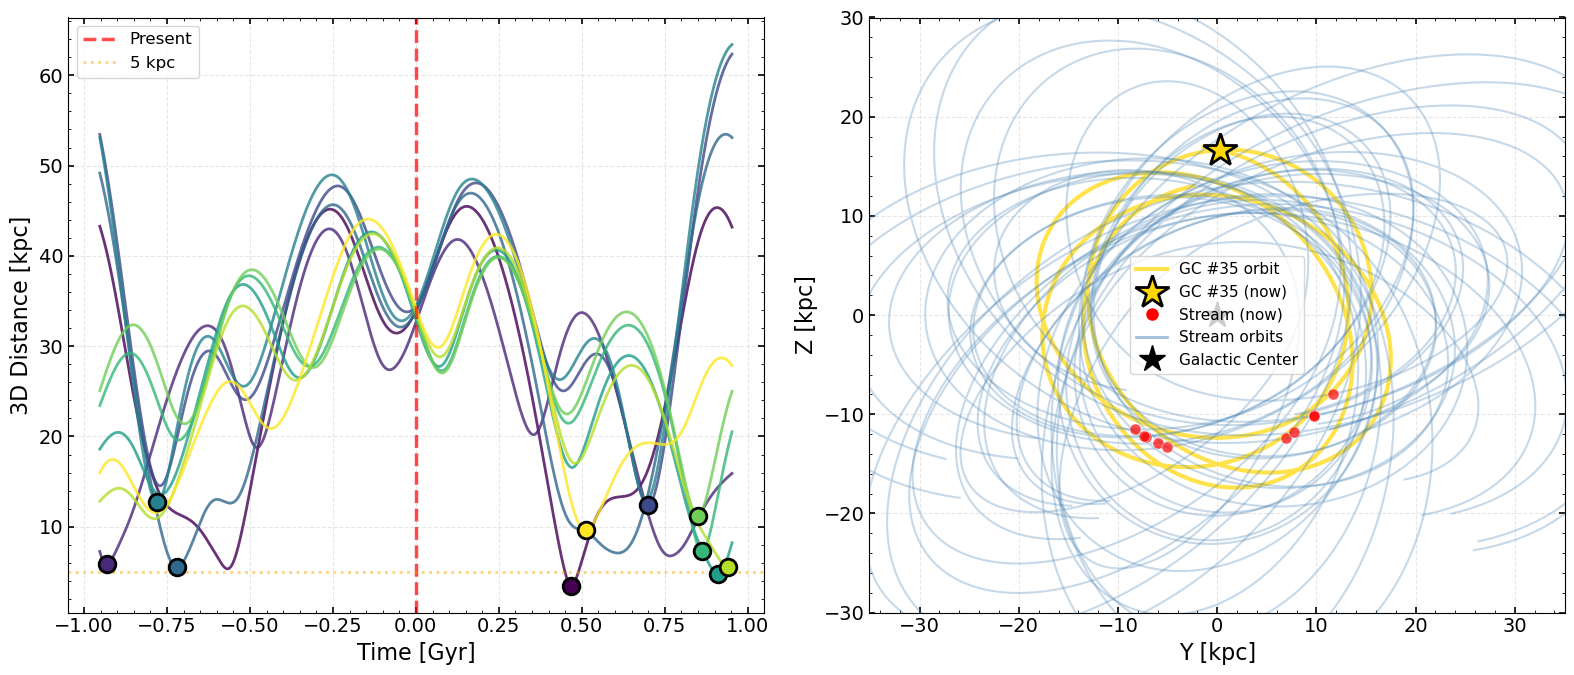

In [476]:
# ============================================================
# 额外可视化：轨道相位分析
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 左图：时间演化的3D距离
ax = axes[0]

# 画几个代表性成员与GC的距离随时间变化
# sample_members = [0, 3, 5, 8]  # Top 4 closest
sample_members = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
colors_sample = plt.cm.viridis(np.linspace(0, 1, len(sample_members)))

for idx, member_idx in enumerate(sample_members):
    orb_stream = rcd_orb[member_idx]
    orb_stream_m = rcd_orb_m[member_idx]
    t_stream = rcd_t[member_idx]
    t_stream_m = rcd_t_m[member_idx]
    
    orb_stream_full = np.vstack([orb_stream_m[::-1], orb_stream[1:]])
    t_stream_full = np.concatenate([t_stream_m[::-1], t_stream[1:]])
    
    # 计算与GC的距离随时间变化
    # 简化：在共同时间网格上插值
    t_min = max(t_gc_full[0], t_stream_full[0])
    t_max = min(t_gc_full[-1], t_stream_full[-1])
    t_common = np.linspace(t_min, t_max, 1000)
    
    from scipy.interpolate import interp1d
    
    # 插值GC
    gc_x_interp = interp1d(t_gc_full, orb_gc_full[:,0])(t_common)
    gc_y_interp = interp1d(t_gc_full, orb_gc_full[:,1])(t_common)
    gc_z_interp = interp1d(t_gc_full, orb_gc_full[:,2])(t_common)
    
    # 插值stream
    stream_x_interp = interp1d(t_stream_full, orb_stream_full[:,0])(t_common)
    stream_y_interp = interp1d(t_stream_full, orb_stream_full[:,1])(t_common)
    stream_z_interp = interp1d(t_stream_full, orb_stream_full[:,2])(t_common)
    
    # 距离
    dist_3d = np.sqrt((gc_x_interp - stream_x_interp)**2 + 
                     (gc_y_interp - stream_y_interp)**2 + 
                     (gc_z_interp - stream_z_interp)**2)
    
    ax.plot(t_common, dist_3d, '-', color=colors_sample[idx], lw=2,
           alpha=0.8)
    
    # 标记最小距离点
    min_idx = np.argmin(dist_3d)
    ax.plot(t_common[min_idx], dist_3d[min_idx], 'o', 
           color=colors_sample[idx], ms=12, mec='black', mew=2, zorder=10)

ax.axvline(0, color='red', ls='--', lw=2.5, alpha=0.7, label='Present')
ax.axhline(5, color='orange', ls=':', lw=2, alpha=0.5, label='5 kpc')
ax.set_xlabel('Time [Gyr]', fontsize=16)
ax.set_ylabel('3D Distance [kpc]', fontsize=16)
#ax.set_title('Distance Evolution: GC #35 vs Stream Members', 
#            fontsize=17, fontweight='bold')
ax.legend(fontsize=12, loc='best')
ax.grid(alpha=0.3, linestyle='--')
ax.tick_params(labelsize=14)

# 右图：轨道在YZ平面的投影
ax = axes[1]

# 画GC轨道
ax.plot(orb_gc_full[:,1], orb_gc_full[:,2], '-', 
       color='gold', lw=3, alpha=0.7, label='GC #35 orbit')

# 画GC当前位置
gc_now_idx = len(t_gc_m) - 1
ax.plot(orb_gc_full[gc_now_idx, 1], orb_gc_full[gc_now_idx, 2], 
       '*', color='gold', ms=25, mec='black', mew=2, 
       label='GC #35 (now)', zorder=10)

# 画星流轨道（采样几个）
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    orb_stream_full = np.vstack([rcd_orb_m[i][::-1], rcd_orb[i][1:]])
    ax.plot(orb_stream_full[:,1], orb_stream_full[:,2], '-',
           color='steelblue', lw=1.5, alpha=0.3)

# 画星流当前位置
for i in range(len(ra_all)):
    ax.plot(sample_A[i,1], sample_A[i,2], 'o',
           color='red', ms=8, alpha=0.7, mec='white', mew=0.5)

ax.plot([],[], 'o', color='red', ms=8, label='Stream (now)')
ax.plot([],[], '-', color='steelblue', lw=2, alpha=0.5, label='Stream orbits')

# 画银心和太阳
ax.plot(0, 0, '*', color='black', ms=20, label='Galactic Center')
#ax.plot(8.34, 0, 'o', color='yellow', ms=15, mec='black', mew=2, label='Sun')

ax.set_xlabel('Y [kpc]', fontsize=16)
ax.set_ylabel('Z [kpc]', fontsize=16)
#ax.set_title('Orbital Projection (XY plane)', fontsize=17, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3, linestyle='--')
ax.tick_params(labelsize=14)
ax.axis('equal')
ax.set_xlim([-30, 30])
ax.set_ylim([-30, 30])

plt.tight_layout()
#plt.savefig("./stream/S2808stream/plot/gc35_orbital_phase.png", 
#           dpi=200, bbox_inches='tight')
plt.show()

In [475]:
import numpy as np

# Palomar 5的观测参数
ra = 229.022   # 赤经 (度)
dec = -0.112   # 赤纬 (度)
dist = 23.2    # 距离 (kpc)

# 转换为弧度
ra_rad = np.radians(ra)
dec_rad = np.radians(dec)

# 步骤1: 赤道坐标 -> 日心笛卡尔坐标
x_eq = dist * np.cos(dec_rad) * np.cos(ra_rad)
y_eq = dist * np.cos(dec_rad) * np.sin(ra_rad)
z_eq = dist * np.sin(dec_rad)

# 步骤2: 构建旋转矩阵 (赤道系 -> 银道系)
# 银河系北极指向 (J2000)
NGP_ra = np.radians(192.859508)   # 12h 51m 26.28s
NGP_dec = np.radians(27.128336)   # 27° 07' 42.0"
l_NCP = np.radians(122.932)       # 银心在天球北极坐标系的经度

# 旋转矩阵元素
sin_d = np.sin(NGP_dec)
cos_d = np.cos(NGP_dec)
sin_a = np.sin(NGP_ra)
cos_a = np.cos(NGP_ra)
sin_l = np.sin(l_NCP)
cos_l = np.cos(l_NCP)

T = np.array([
    [-sin_l*sin_a - cos_l*cos_a*sin_d,  sin_l*cos_a - cos_l*sin_a*sin_d,  cos_l*cos_d],
    [ cos_l*sin_a - sin_l*cos_a*sin_d, -cos_l*cos_a - sin_l*sin_a*sin_d,  sin_l*cos_d],
    [ cos_a*cos_d,                      sin_a*cos_d,                      sin_d      ]
])

# 转换到日心银道坐标系
pos_helio = np.array([x_eq, y_eq, z_eq])
pos_gal_helio = T @ pos_helio

# 步骤3: 日心银道系 -> 银心坐标系
R_sun = 8.122    # 太阳到银心距离 (kpc)
z_sun = 0.0208   # 太阳距银盘高度 (kpc)

X_gc = -pos_gal_helio[0] + R_sun  # X指向太阳方向
Y_gc = -pos_gal_helio[1]           # Y沿旋转方向
Z_gc = pos_gal_helio[2] - z_sun    # Z指向银河北极

print(f"银心坐标系 (kpc):")
print(f"X_gc = {X_gc:.3f}")
print(f"Y_gc = {Y_gc:.3f}")
print(f"Z_gc = {Z_gc:.3f}")
print(f"\n距银心: {np.sqrt(X_gc**2 + Y_gc**2 + Z_gc**2):.3f} kpc")

银心坐标系 (kpc):
X_gc = -8.033
Y_gc = -0.240
Z_gc = 16.628

距银心: 18.469 kpc
